In [1]:
%matplotlib inline
from common import *
from matplotlib import pyplot as plt
import smart_open

In [14]:
import xml.etree.ElementTree as ET

tree = ET.parse('../data/TestDocumentsResult1.xml')
root = tree.getroot()

In [15]:
gold = {}
for child in root:
    sims = []
    for similars in child:
        for sim in similars:
            sims.append(sim.attrib['docId'])
    gold[child.attrib['docId']] = sims

In [2]:
import ujson

def iter_docs():
    with GzipFile('../data/lingvo/corpus_json.txt.gz', 'r') as fr:
        for line in fr:
            _id, sents = ujson.loads(line)
            yield _id, sents
                
class Documents():
    def __iter__(self):
        for _id, doc in iter_docs():
            unlisted = [w for s in doc for w in s]
            yield gensim.models.doc2vec.TaggedDocument(unlisted, [_id])

In [16]:
s = u"к1-_г/м. 3-3"
prog = re.compile("[\W\d]", re.UNICODE)
print(prog.sub('', s))

к_гм


In [5]:
# model = Doc2Vec(size=200, window=15, min_count=5, dm=0, workers=cpu_count, iter=1,
#                sample=1e-4, alpha=.01, min_alpha=.0001) # dbow_words=1

In [6]:
model = Doc2Vec(Documents(), size=200,window=8,min_count=5,dm=1,workers=cpu_count,iter=10)

2017-10-21 03:35:26,159 [MainThread  ] [INFO ]  collecting all words and their counts
2017-10-21 03:35:26,167 [MainThread  ] [INFO ]  PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-10-21 03:35:36,137 [MainThread  ] [INFO ]  PROGRESS: at example #10000, processed 7516342 words (753995/s), 178997 word types, 10000 tags
2017-10-21 03:35:45,979 [MainThread  ] [INFO ]  PROGRESS: at example #20000, processed 15216095 words (782404/s), 291883 word types, 20000 tags
2017-10-21 03:35:55,653 [MainThread  ] [INFO ]  PROGRESS: at example #30000, processed 22780196 words (781972/s), 389575 word types, 30000 tags
2017-10-21 03:36:05,530 [MainThread  ] [INFO ]  PROGRESS: at example #40000, processed 30663046 words (798178/s), 481411 word types, 40000 tags
2017-10-21 03:36:15,322 [MainThread  ] [INFO ]  PROGRESS: at example #50000, processed 38375315 words (787660/s), 563560 word types, 50000 tags
2017-10-21 03:36:24,793 [MainThread  ] [INFO ]  PROGRESS: at example #60000,

KeyboardInterrupt: 

In [ ]:
model.save("../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10")

In [6]:
model = Doc2Vec.load("../data/lingvo/d2v_size=200,window=8,min_count=5,dm=1,iter=10")

In [ ]:
most = model.most_similar(u'стол')
for w, score in most:
    print(w + ' %s' % score)

2017-11-01 06:10:54,500 [MainThread  ] [INFO ]  precomputing L2-norms of word weight vectors


столик 0.81825530529
стул 0.71447956562
табурет 0.68927782774
диван 0.683494329453
табуретка 0.648913502693
кресло 0.634198069572
тарелка 0.633783578873
комната 0.622421741486
подоконник 0.619355797768
стопка 0.618796169758


In [ ]:
preds = {}
for k in gold.keys():
    sims = model.docvecs.most_similar(positive=[k], topn=200)
    preds[k] = [i for i,score in sims]

2017-11-01 06:12:00,566 [MainThread  ] [INFO ]  precomputing L2-norms of doc weight vectors


In [20]:
result = evaluate(preds, gold)

100%|██████████| 184/184 [00:00<00:00, 22147.50it/s]
2017-11-01 06:13:30,556 [MainThread  ] [INFO ]  
acc10     0.226619
acc20     0.280576
acc200    0.435252
dtype: float64


# Use MPK rules

In [5]:
fields = ['section', 'class_']

In [6]:
rules = np.load('../data/rules_%s.npy' % '_'.join(fields))
with open('../data/%s_index.pkl' % '_'.join(fields), 'rb') as f:
    columns, index = pickle.load(f)

In [7]:
df = pd.DataFrame(rules, index = index, columns=columns)

In [44]:
preds = {}
for k, doc in tqdm_notebook(test_docs.items()):
    inferred_vector = model.infer_vector(doc, steps=5)
    sims = model.docvecs.most_similar([inferred_vector], topn=model.docvecs.count)
    if k in df:
        valid = df.index[df[k]]
        preds[k] = [_id for _id,score in sims if _id in valid][:201]
    else:
        preds[k] = [_id for _id,score in sims[:201]]    

100%|██████████| 184/184 [00:00<00:00, 22843.03it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.289855
acc20     0.344203
acc200    0.495652
dtype: float64


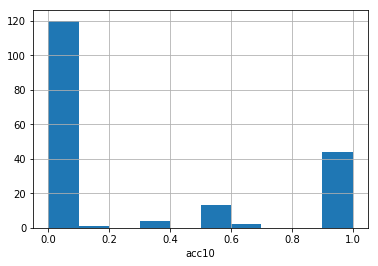

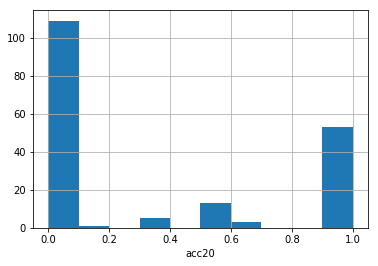

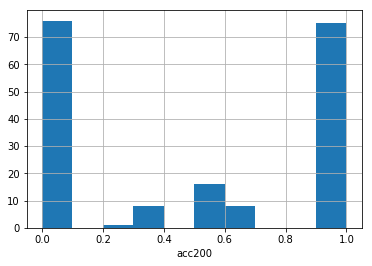

In [45]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [47]:
# section', 'class_
# acc10     0.279891
# acc20     0.316123
# acc200    0.483152

# section
# acc10     0.289855
# acc20     0.344203
# acc200    0.495652

In [ ]:
test_ids = set(gold.keys() + [vi for v in gold.values() for vi in v])

In [ ]:
folder = join(DATA_FOLDER, 'documents/')

test_docs = {}
fnames = glob(join(folder, '*.json.gz'))
for k,doc in iter_docs(fnames):
    if k in test_ids:
        unlisted = [w for s in doc for w in s]
        test_docs[k] = unlisted

2017-10-07 10:52:19,146 [MainThread  ] [INFO ]  0: ../data/documents/72.json.gz
2017-10-07 10:52:19,237 [MainThread  ] [INFO ]  1: ../data/documents/228.json.gz
2017-10-07 10:52:20,138 [MainThread  ] [INFO ]  2: ../data/documents/791.json.gz
2017-10-07 10:52:20,432 [MainThread  ] [INFO ]  3: ../data/documents/369.json.gz
2017-10-07 10:52:21,729 [MainThread  ] [INFO ]  4: ../data/documents/19.json.gz
2017-10-07 10:52:22,565 [MainThread  ] [INFO ]  5: ../data/documents/483.json.gz
2017-10-07 10:52:22,962 [MainThread  ] [INFO ]  6: ../data/documents/165.json.gz
2017-10-07 10:52:23,085 [MainThread  ] [INFO ]  7: ../data/documents/233.json.gz
2017-10-07 10:52:23,163 [MainThread  ] [INFO ]  8: ../data/documents/299.json.gz
2017-10-07 10:52:23,322 [MainThread  ] [INFO ]  9: ../data/documents/482.json.gz
2017-10-07 10:52:23,495 [MainThread  ] [INFO ]  10: ../data/documents/473.json.gz
2017-10-07 10:52:25,047 [MainThread  ] [INFO ]  11: ../data/documents/117.json.gz
2017-10-07 10:52:25,239 [Mai

2017-10-07 10:55:12,330 [MainThread  ] [INFO ]  101: ../data/documents/535.json.gz
2017-10-07 10:55:13,495 [MainThread  ] [INFO ]  102: ../data/documents/328.json.gz
2017-10-07 10:55:16,879 [MainThread  ] [INFO ]  103: ../data/documents/900.json.gz
2017-10-07 10:55:17,676 [MainThread  ] [INFO ]  104: ../data/documents/656.json.gz
2017-10-07 10:55:23,949 [MainThread  ] [INFO ]  105: ../data/documents/666.json.gz
2017-10-07 10:55:27,023 [MainThread  ] [INFO ]  106: ../data/documents/954.json.gz
2017-10-07 10:55:27,984 [MainThread  ] [INFO ]  107: ../data/documents/860.json.gz
2017-10-07 10:55:30,468 [MainThread  ] [INFO ]  108: ../data/documents/908.json.gz
2017-10-07 10:55:38,063 [MainThread  ] [INFO ]  110: ../data/documents/437.json.gz
2017-10-07 10:55:38,999 [MainThread  ] [INFO ]  111: ../data/documents/962.json.gz
2017-10-07 10:55:39,641 [MainThread  ] [INFO ]  112: ../data/documents/46.json.gz
2017-10-07 10:55:41,585 [MainThread  ] [INFO ]  113: ../data/documents/409.json.gz
2017-

2017-10-07 10:58:20,338 [MainThread  ] [INFO ]  201: ../data/documents/828.json.gz
2017-10-07 10:58:23,035 [MainThread  ] [INFO ]  202: ../data/documents/649.json.gz
2017-10-07 10:58:26,438 [MainThread  ] [INFO ]  203: ../data/documents/603.json.gz
2017-10-07 10:58:29,292 [MainThread  ] [INFO ]  204: ../data/documents/255.json.gz
2017-10-07 10:58:31,272 [MainThread  ] [INFO ]  205: ../data/documents/700.json.gz
2017-10-07 10:58:31,688 [MainThread  ] [INFO ]  206: ../data/documents/471.json.gz
2017-10-07 10:58:32,659 [MainThread  ] [INFO ]  207: ../data/documents/798.json.gz
2017-10-07 10:58:33,247 [MainThread  ] [INFO ]  208: ../data/documents/394.json.gz
2017-10-07 10:58:33,484 [MainThread  ] [INFO ]  209: ../data/documents/58.json.gz
2017-10-07 10:58:34,407 [MainThread  ] [INFO ]  210: ../data/documents/948.json.gz
2017-10-07 10:58:35,416 [MainThread  ] [INFO ]  211: ../data/documents/140.json.gz
2017-10-07 10:58:36,585 [MainThread  ] [INFO ]  212: ../data/documents/493.json.gz
2017-

2017-10-07 11:01:54,748 [MainThread  ] [INFO ]  300: ../data/documents/178.json.gz
2017-10-07 11:01:56,379 [MainThread  ] [INFO ]  301: ../data/documents/819.json.gz
2017-10-07 11:02:04,730 [MainThread  ] [INFO ]  302: ../data/documents/380.json.gz
2017-10-07 11:02:08,261 [MainThread  ] [INFO ]  303: ../data/documents/363.json.gz
2017-10-07 11:02:09,613 [MainThread  ] [INFO ]  304: ../data/documents/848.json.gz
2017-10-07 11:02:10,118 [MainThread  ] [INFO ]  305: ../data/documents/524.json.gz
2017-10-07 11:02:10,713 [MainThread  ] [INFO ]  306: ../data/documents/379.json.gz
2017-10-07 11:02:14,911 [MainThread  ] [INFO ]  307: ../data/documents/895.json.gz
2017-10-07 11:02:17,421 [MainThread  ] [INFO ]  308: ../data/documents/557.json.gz
2017-10-07 11:02:23,140 [MainThread  ] [INFO ]  309: ../data/documents/338.json.gz
2017-10-07 11:02:24,190 [MainThread  ] [INFO ]  310: ../data/documents/176.json.gz
2017-10-07 11:02:25,254 [MainThread  ] [INFO ]  311: ../data/documents/794.json.gz
2017

2017-10-07 11:05:13,793 [MainThread  ] [INFO ]  399: ../data/documents/345.json.gz
2017-10-07 11:05:14,187 [MainThread  ] [INFO ]  400: ../data/documents/319.json.gz
2017-10-07 11:05:15,938 [MainThread  ] [INFO ]  401: ../data/documents/66.json.gz
2017-10-07 11:05:16,369 [MainThread  ] [INFO ]  402: ../data/documents/674.json.gz
2017-10-07 11:05:18,977 [MainThread  ] [INFO ]  403: ../data/documents/244.json.gz
2017-10-07 11:05:22,505 [MainThread  ] [INFO ]  404: ../data/documents/767.json.gz
2017-10-07 11:05:23,992 [MainThread  ] [INFO ]  405: ../data/documents/205.json.gz
2017-10-07 11:05:24,448 [MainThread  ] [INFO ]  406: ../data/documents/277.json.gz
2017-10-07 11:05:27,132 [MainThread  ] [INFO ]  407: ../data/documents/642.json.gz
2017-10-07 11:05:29,081 [MainThread  ] [INFO ]  408: ../data/documents/400.json.gz
2017-10-07 11:05:29,756 [MainThread  ] [INFO ]  409: ../data/documents/521.json.gz
2017-10-07 11:05:30,898 [MainThread  ] [INFO ]  410: ../data/documents/737.json.gz
2017-

2017-10-07 11:08:13,435 [MainThread  ] [INFO ]  498: ../data/documents/496.json.gz
2017-10-07 11:08:14,614 [MainThread  ] [INFO ]  499: ../data/documents/170.json.gz
2017-10-07 11:08:14,805 [MainThread  ] [INFO ]  500: ../data/documents/159.json.gz
2017-10-07 11:08:15,459 [MainThread  ] [INFO ]  501: ../data/documents/902.json.gz
2017-10-07 11:08:15,756 [MainThread  ] [INFO ]  502: ../data/documents/762.json.gz
2017-10-07 11:08:16,010 [MainThread  ] [INFO ]  503: ../data/documents/668.json.gz
2017-10-07 11:08:17,503 [MainThread  ] [INFO ]  504: ../data/documents/404.json.gz
2017-10-07 11:08:17,904 [MainThread  ] [INFO ]  505: ../data/documents/939.json.gz
2017-10-07 11:08:23,908 [MainThread  ] [INFO ]  506: ../data/documents/411.json.gz
2017-10-07 11:08:27,292 [MainThread  ] [INFO ]  507: ../data/documents/658.json.gz
2017-10-07 11:08:34,224 [MainThread  ] [INFO ]  508: ../data/documents/924.json.gz
2017-10-07 11:08:39,455 [MainThread  ] [INFO ]  509: ../data/documents/247.json.gz
2017

2017-10-07 11:11:45,144 [MainThread  ] [INFO ]  597: ../data/documents/904.json.gz
2017-10-07 11:11:45,765 [MainThread  ] [INFO ]  598: ../data/documents/622.json.gz
2017-10-07 11:11:47,825 [MainThread  ] [INFO ]  599: ../data/documents/640.json.gz
2017-10-07 11:11:48,608 [MainThread  ] [INFO ]  600: ../data/documents/919.json.gz
2017-10-07 11:11:55,584 [MainThread  ] [INFO ]  601: ../data/documents/914.json.gz
2017-10-07 11:11:57,882 [MainThread  ] [INFO ]  602: ../data/documents/615.json.gz
2017-10-07 11:12:00,880 [MainThread  ] [INFO ]  603: ../data/documents/73.json.gz
2017-10-07 11:12:01,300 [MainThread  ] [INFO ]  604: ../data/documents/772.json.gz
2017-10-07 11:12:03,553 [MainThread  ] [INFO ]  605: ../data/documents/235.json.gz
2017-10-07 11:12:03,953 [MainThread  ] [INFO ]  606: ../data/documents/621.json.gz
2017-10-07 11:12:05,031 [MainThread  ] [INFO ]  607: ../data/documents/683.json.gz
2017-10-07 11:12:08,616 [MainThread  ] [INFO ]  608: ../data/documents/273.json.gz
2017-

2017-10-07 11:14:57,922 [MainThread  ] [INFO ]  696: ../data/documents/500.json.gz
2017-10-07 11:15:00,702 [MainThread  ] [INFO ]  697: ../data/documents/227.json.gz
2017-10-07 11:15:04,831 [MainThread  ] [INFO ]  698: ../data/documents/514.json.gz
2017-10-07 11:15:07,636 [MainThread  ] [INFO ]  699: ../data/documents/555.json.gz
2017-10-07 11:15:13,869 [MainThread  ] [INFO ]  700: ../data/documents/158.json.gz
2017-10-07 11:15:15,542 [MainThread  ] [INFO ]  701: ../data/documents/436.json.gz
2017-10-07 11:15:15,837 [MainThread  ] [INFO ]  702: ../data/documents/462.json.gz
2017-10-07 11:15:17,419 [MainThread  ] [INFO ]  703: ../data/documents/911.json.gz
2017-10-07 11:15:17,974 [MainThread  ] [INFO ]  704: ../data/documents/378.json.gz
2017-10-07 11:15:20,064 [MainThread  ] [INFO ]  705: ../data/documents/812.json.gz
2017-10-07 11:15:22,420 [MainThread  ] [INFO ]  706: ../data/documents/218.json.gz
2017-10-07 11:15:23,667 [MainThread  ] [INFO ]  707: ../data/documents/508.json.gz
2017

2017-10-07 11:18:13,954 [MainThread  ] [INFO ]  795: ../data/documents/415.json.gz
2017-10-07 11:18:16,840 [MainThread  ] [INFO ]  796: ../data/documents/238.json.gz
2017-10-07 11:18:18,030 [MainThread  ] [INFO ]  797: ../data/documents/8.json.gz
2017-10-07 11:18:19,474 [MainThread  ] [INFO ]  798: ../data/documents/832.json.gz
2017-10-07 11:18:22,047 [MainThread  ] [INFO ]  799: ../data/documents/313.json.gz
2017-10-07 11:18:25,963 [MainThread  ] [INFO ]  800: ../data/documents/596.json.gz
2017-10-07 11:18:27,538 [MainThread  ] [INFO ]  801: ../data/documents/318.json.gz
2017-10-07 11:18:28,394 [MainThread  ] [INFO ]  802: ../data/documents/625.json.gz
2017-10-07 11:18:28,867 [MainThread  ] [INFO ]  803: ../data/documents/804.json.gz
2017-10-07 11:18:30,361 [MainThread  ] [INFO ]  804: ../data/documents/124.json.gz
2017-10-07 11:18:30,590 [MainThread  ] [INFO ]  805: ../data/documents/879.json.gz
2017-10-07 11:18:34,113 [MainThread  ] [INFO ]  806: ../data/documents/455.json.gz
2017-1

2017-10-07 11:22:08,408 [MainThread  ] [INFO ]  894: ../data/documents/580.json.gz
2017-10-07 11:22:09,695 [MainThread  ] [INFO ]  895: ../data/documents/48.json.gz
2017-10-07 11:22:11,129 [MainThread  ] [INFO ]  896: ../data/documents/826.json.gz
2017-10-07 11:22:13,565 [MainThread  ] [INFO ]  897: ../data/documents/513.json.gz
2017-10-07 11:22:16,620 [MainThread  ] [INFO ]  898: ../data/documents/544.json.gz
2017-10-07 11:22:19,648 [MainThread  ] [INFO ]  899: ../data/documents/286.json.gz
2017-10-07 11:22:22,180 [MainThread  ] [INFO ]  900: ../data/documents/581.json.gz
2017-10-07 11:22:22,960 [MainThread  ] [INFO ]  901: ../data/documents/183.json.gz
2017-10-07 11:22:24,478 [MainThread  ] [INFO ]  902: ../data/documents/639.json.gz
2017-10-07 11:22:24,842 [MainThread  ] [INFO ]  903: ../data/documents/208.json.gz
2017-10-07 11:22:25,052 [MainThread  ] [INFO ]  904: ../data/documents/27.json.gz
2017-10-07 11:22:25,143 [MainThread  ] [INFO ]  905: ../data/documents/280.json.gz
2017-1

2017-10-07 11:25:06,600 [MainThread  ] [INFO ]  993: ../data/documents/307.json.gz
2017-10-07 11:25:08,155 [MainThread  ] [INFO ]  994: ../data/documents/171.json.gz
2017-10-07 11:25:08,412 [MainThread  ] [INFO ]  995: ../data/documents/714.json.gz
2017-10-07 11:25:08,705 [MainThread  ] [INFO ]  996: ../data/documents/377.json.gz
2017-10-07 11:25:10,655 [MainThread  ] [INFO ]  997: ../data/documents/452.json.gz
2017-10-07 11:25:10,935 [MainThread  ] [INFO ]  998: ../data/documents/587.json.gz
2017-10-07 11:25:11,648 [MainThread  ] [INFO ]  999: ../data/documents/757.json.gz
2017-10-07 11:25:12,097 [MainThread  ] [INFO ]  1000: ../data/documents/249.json.gz


In [9]:
with open('../data/test_docs.json', 'w') as f:
    json.dump(test_docs, f)

In [8]:
with open('../data/test_docs.json', 'r') as f:
    test_docs = json.load(f)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

stat = []
for k,v in tqdm_notebook(gold.items()):
    q_vector = model.infer_vector(test_docs[k], steps=5)
    ex_vecs = []
    matched = []
    for vi in v:
        doc_vec = model.infer_vector(test_docs[vi], steps=5)
        ex_vecs.append(doc_vec)
        if k in df:
            matched.append(int(df.loc[vi,k]))
        else:
            matched.append(0)
    sim_mat = cosine_similarity([q_vector], ex_vecs)
    stat += list(zip(sim_mat[0], matched))
#     if np.max(sim_mat)>0.8:
#         break

In [12]:
df1 = pd.DataFrame(stat, columns=['cos', 'matched'])

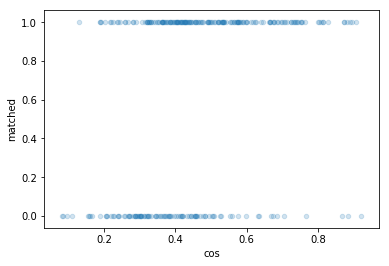

In [13]:
#section, class
df1.plot(kind='scatter', x='cos', y='matched', alpha=0.2)
plt.show()

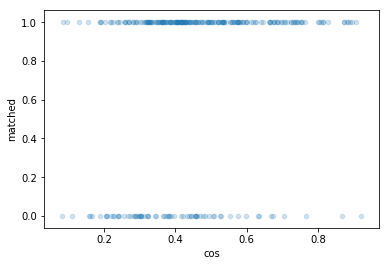

In [12]:
#section
df1.plot(kind='scatter', x='cos', y='matched', alpha=0.2)
plt.show()

# Doc2Vec initialize with wiki words

In [3]:
vectors = gensim.models.KeyedVectors.load_word2vec_format('../data/vectors/ruwikiruscorpora_0_300_20.bin.gz',
                                                         binary=True)
# try ruwikiruscorpora.model.bin.gz - much more words

2017-10-31 23:14:14,701 [MainThread  ] [INFO ]  loading projection weights from ../data/vectors/ruwikiruscorpora_0_300_20.bin.gz
2017-10-31 23:14:39,544 [MainThread  ] [INFO ]  loaded (392339, 300) matrix from ../data/vectors/ruwikiruscorpora_0_300_20.bin.gz


In [4]:
vectors.syn0.shape

(392339, 300)

In [5]:
index2word = [w.split('_')[0] for w in vectors.index2word]

In [6]:
for w in index2word[:10]:
    print(w)

год
весь
человек
время
становиться
первый
мочь
также
город
новый


In [9]:
model = Doc2Vec(size=vectors.syn0.shape[1],window=8,min_count=5,dm=0,workers=cpu_count,iter=10)
model.build_vocab(Documents())

2017-10-30 12:15:01,789 [MainThread  ] [INFO ]  collecting all words and their counts
2017-10-30 12:15:01,793 [MainThread  ] [INFO ]  PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-10-30 12:15:06,037 [MainThread  ] [INFO ]  PROGRESS: at example #10000, processed 8342757 words (1966705/s), 254752 word types, 10000 tags
2017-10-30 12:15:10,417 [MainThread  ] [INFO ]  PROGRESS: at example #20000, processed 16769145 words (1924257/s), 432325 word types, 20000 tags
2017-10-30 12:15:14,680 [MainThread  ] [INFO ]  PROGRESS: at example #30000, processed 24978112 words (1926172/s), 589294 word types, 30000 tags
2017-10-30 12:15:18,992 [MainThread  ] [INFO ]  PROGRESS: at example #40000, processed 33241869 words (1916901/s), 719688 word types, 40000 tags
2017-10-30 12:15:23,460 [MainThread  ] [INFO ]  PROGRESS: at example #50000, processed 41583629 words (1867315/s), 849078 word types, 50000 tags
2017-10-30 12:15:27,927 [MainThread  ] [INFO ]  PROGRESS: at example #6

2017-10-30 12:19:01,813 [MainThread  ] [INFO ]  PROGRESS: at example #550000, processed 456776460 words (1904490/s), 5192699 word types, 550000 tags
2017-10-30 12:19:06,170 [MainThread  ] [INFO ]  PROGRESS: at example #560000, processed 465125508 words (1916478/s), 5263292 word types, 560000 tags
2017-10-30 12:19:10,432 [MainThread  ] [INFO ]  PROGRESS: at example #570000, processed 473212976 words (1898092/s), 5330070 word types, 570000 tags
2017-10-30 12:19:14,736 [MainThread  ] [INFO ]  PROGRESS: at example #580000, processed 481424090 words (1908208/s), 5396133 word types, 580000 tags
2017-10-30 12:19:19,242 [MainThread  ] [INFO ]  PROGRESS: at example #590000, processed 490029372 words (1910194/s), 5465281 word types, 590000 tags
2017-10-30 12:19:23,610 [MainThread  ] [INFO ]  PROGRESS: at example #600000, processed 498335965 words (1902425/s), 5537562 word types, 600000 tags
2017-10-30 12:19:28,166 [MainThread  ] [INFO ]  PROGRESS: at example #610000, processed 506631692 words (1

2017-10-30 12:23:07,259 [MainThread  ] [INFO ]  PROGRESS: at example #1100000, processed 912514897 words (1887981/s), 8638253 word types, 1100000 tags
2017-10-30 12:23:11,693 [MainThread  ] [INFO ]  PROGRESS: at example #1110000, processed 920697149 words (1845816/s), 8693799 word types, 1110000 tags
2017-10-30 12:23:16,258 [MainThread  ] [INFO ]  PROGRESS: at example #1120000, processed 928961794 words (1811049/s), 8752048 word types, 1120000 tags
2017-10-30 12:23:20,799 [MainThread  ] [INFO ]  PROGRESS: at example #1130000, processed 937291338 words (1834739/s), 8806314 word types, 1130000 tags
2017-10-30 12:23:25,454 [MainThread  ] [INFO ]  PROGRESS: at example #1140000, processed 945876674 words (1844588/s), 8860981 word types, 1140000 tags
2017-10-30 12:23:29,800 [MainThread  ] [INFO ]  PROGRESS: at example #1150000, processed 953920771 words (1851592/s), 8915175 word types, 1150000 tags
2017-10-30 12:23:34,331 [MainThread  ] [INFO ]  PROGRESS: at example #1160000, processed 96222

In [11]:
model.save('../data/lingvo/d2v_build_vocab')

2017-10-30 12:26:21,248 [MainThread  ] [INFO ]  saving Doc2Vec object under ../data/d2v_build_vocab, separately None
2017-10-30 12:26:21,250 [MainThread  ] [INFO ]  storing np array 'doctag_syn0' to ../data/d2v_build_vocab.docvecs.doctag_syn0.npy
2017-10-30 12:26:26,649 [MainThread  ] [INFO ]  not storing attribute syn0norm
2017-10-30 12:26:26,893 [MainThread  ] [INFO ]  storing np array 'syn0' to ../data/d2v_build_vocab.wv.syn0.npy
2017-10-30 12:26:41,866 [MainThread  ] [INFO ]  storing np array 'syn1neg' to ../data/d2v_build_vocab.syn1neg.npy
2017-10-30 12:26:55,666 [MainThread  ] [INFO ]  not storing attribute cum_table
2017-10-30 12:27:27,536 [MainThread  ] [INFO ]  saved ../data/d2v_build_vocab


In [7]:
model = Doc2Vec.load('../data/lingvo/d2v_build_vocab')

2017-10-31 23:14:39,807 [MainThread  ] [INFO ]  loading Doc2Vec object from ../data/lingvo/d2v_build_vocab
2017-10-31 23:14:51,591 [MainThread  ] [INFO ]  loading docvecs recursively from ../data/lingvo/d2v_build_vocab.docvecs.* with mmap=None
2017-10-31 23:14:51,593 [MainThread  ] [INFO ]  loading doctag_syn0 from ../data/lingvo/d2v_build_vocab.docvecs.doctag_syn0.npy with mmap=None
2017-10-31 23:14:56,062 [MainThread  ] [INFO ]  loading wv recursively from ../data/lingvo/d2v_build_vocab.wv.* with mmap=None
2017-10-31 23:14:56,064 [MainThread  ] [INFO ]  loading syn0 from ../data/lingvo/d2v_build_vocab.wv.syn0.npy with mmap=None
2017-10-31 23:14:59,635 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-10-31 23:14:59,639 [MainThread  ] [INFO ]  loading syn1neg from ../data/lingvo/d2v_build_vocab.syn1neg.npy with mmap=None
2017-10-31 23:15:09,101 [MainThread  ] [INFO ]  setting ignored attribute cum_table to None
2017-10-31 23:15:09,102 [MainThread  ] [INFO ]  load

In [8]:
for w in model.wv.index2word[:10]:
    print(w)

секунда
содержать
поверхность
сигнал
корпус
температура
вода
время
слой
давление


In [11]:
u'становиться' in index2word

True

In [10]:
_set = set(index2word).intersection(model.wv.index2word)

In [11]:
len(_set)

118284

In [12]:
for i, w in enumerate(tqdm_notebook(model.wv.index2word)):
    if w not in _set:
        continue
    ix = index2word.index(w)
    vec = vectors.wv.syn0[ix]
    model.wv.syn0[i] = vec

In [13]:
# model.train_words = False
model.train(Documents(), total_examples=model.corpus_count, epochs=model.iter)

2017-10-31 23:23:21,796 [MainThread  ] [INFO ]  training model with 4 workers on 1554739 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=8
2017-10-31 23:23:22,808 [MainThread  ] [INFO ]  PROGRESS: at 0.00% examples, 493963 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:23:23,823 [MainThread  ] [INFO ]  PROGRESS: at 0.01% examples, 523764 words/s, in_qsize 6, out_qsize 1
2017-10-31 23:23:24,821 [MainThread  ] [INFO ]  PROGRESS: at 0.02% examples, 535159 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:23:25,832 [MainThread  ] [INFO ]  PROGRESS: at 0.02% examples, 538498 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:23:26,837 [MainThread  ] [INFO ]  PROGRESS: at 0.03% examples, 542084 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:23:27,852 [MainThread  ] [INFO ]  PROGRESS: at 0.03% examples, 542112 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:23:28,884 [MainThread  ] [INFO ]  PROGRESS: at 0.04% examples, 541791 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:

2017-10-31 23:24:32,638 [MainThread  ] [INFO ]  PROGRESS: at 0.37% examples, 526173 words/s, in_qsize 7, out_qsize 1
2017-10-31 23:24:33,649 [MainThread  ] [INFO ]  PROGRESS: at 0.37% examples, 526071 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:24:34,661 [MainThread  ] [INFO ]  PROGRESS: at 0.38% examples, 526548 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:24:35,662 [MainThread  ] [INFO ]  PROGRESS: at 0.38% examples, 527042 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:24:36,675 [MainThread  ] [INFO ]  PROGRESS: at 0.39% examples, 524161 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:24:37,684 [MainThread  ] [INFO ]  PROGRESS: at 0.39% examples, 524689 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:24:38,708 [MainThread  ] [INFO ]  PROGRESS: at 0.40% examples, 524895 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:24:39,722 [MainThread  ] [INFO ]  PROGRESS: at 0.40% examples, 525512 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:24:40,727 [MainThread  ] [INFO ]  PROGRESS: at 0.4

2017-10-31 23:25:44,541 [MainThread  ] [INFO ]  PROGRESS: at 0.77% examples, 546492 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:25:45,558 [MainThread  ] [INFO ]  PROGRESS: at 0.77% examples, 546759 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:25:46,570 [MainThread  ] [INFO ]  PROGRESS: at 0.78% examples, 546956 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:25:47,595 [MainThread  ] [INFO ]  PROGRESS: at 0.78% examples, 547022 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:25:48,601 [MainThread  ] [INFO ]  PROGRESS: at 0.79% examples, 547291 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:25:49,603 [MainThread  ] [INFO ]  PROGRESS: at 0.80% examples, 547444 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:25:50,607 [MainThread  ] [INFO ]  PROGRESS: at 0.80% examples, 547540 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:25:51,616 [MainThread  ] [INFO ]  PROGRESS: at 0.81% examples, 547693 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:25:52,637 [MainThread  ] [INFO ]  PROGRESS: at 0.8

2017-10-31 23:26:56,361 [MainThread  ] [INFO ]  PROGRESS: at 1.17% examples, 555544 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:26:57,367 [MainThread  ] [INFO ]  PROGRESS: at 1.18% examples, 555578 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:26:58,368 [MainThread  ] [INFO ]  PROGRESS: at 1.19% examples, 555707 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:26:59,387 [MainThread  ] [INFO ]  PROGRESS: at 1.19% examples, 555757 words/s, in_qsize 4, out_qsize 2
2017-10-31 23:27:00,407 [MainThread  ] [INFO ]  PROGRESS: at 1.20% examples, 555800 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:27:01,416 [MainThread  ] [INFO ]  PROGRESS: at 1.20% examples, 555911 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:27:02,436 [MainThread  ] [INFO ]  PROGRESS: at 1.21% examples, 556001 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:27:03,443 [MainThread  ] [INFO ]  PROGRESS: at 1.21% examples, 556114 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:27:04,449 [MainThread  ] [INFO ]  PROGRESS: at 1.2

2017-10-31 23:28:08,218 [MainThread  ] [INFO ]  PROGRESS: at 1.58% examples, 561140 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:28:09,236 [MainThread  ] [INFO ]  PROGRESS: at 1.59% examples, 561185 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:28:10,242 [MainThread  ] [INFO ]  PROGRESS: at 1.59% examples, 561263 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:28:11,278 [MainThread  ] [INFO ]  PROGRESS: at 1.60% examples, 561277 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:28:12,280 [MainThread  ] [INFO ]  PROGRESS: at 1.60% examples, 561390 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:28:13,284 [MainThread  ] [INFO ]  PROGRESS: at 1.61% examples, 561437 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:28:14,321 [MainThread  ] [INFO ]  PROGRESS: at 1.62% examples, 561518 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:28:15,333 [MainThread  ] [INFO ]  PROGRESS: at 1.62% examples, 561615 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:28:16,351 [MainThread  ] [INFO ]  PROGRESS: at 1.6

2017-10-31 23:29:20,611 [MainThread  ] [INFO ]  PROGRESS: at 1.99% examples, 561973 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:29:21,627 [MainThread  ] [INFO ]  PROGRESS: at 1.99% examples, 562082 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:29:22,629 [MainThread  ] [INFO ]  PROGRESS: at 2.00% examples, 562122 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:29:23,630 [MainThread  ] [INFO ]  PROGRESS: at 2.01% examples, 562268 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:29:24,648 [MainThread  ] [INFO ]  PROGRESS: at 2.01% examples, 562392 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:29:25,653 [MainThread  ] [INFO ]  PROGRESS: at 2.02% examples, 562482 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:29:26,657 [MainThread  ] [INFO ]  PROGRESS: at 2.02% examples, 562611 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:29:27,657 [MainThread  ] [INFO ]  PROGRESS: at 2.03% examples, 562693 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:29:28,684 [MainThread  ] [INFO ]  PROGRESS: at 2.0

2017-10-31 23:30:32,459 [MainThread  ] [INFO ]  PROGRESS: at 2.41% examples, 568458 words/s, in_qsize 4, out_qsize 1
2017-10-31 23:30:33,472 [MainThread  ] [INFO ]  PROGRESS: at 2.42% examples, 568541 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:30:34,483 [MainThread  ] [INFO ]  PROGRESS: at 2.42% examples, 568653 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:30:35,508 [MainThread  ] [INFO ]  PROGRESS: at 2.43% examples, 568732 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:30:36,523 [MainThread  ] [INFO ]  PROGRESS: at 2.44% examples, 568861 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:30:37,529 [MainThread  ] [INFO ]  PROGRESS: at 2.44% examples, 568971 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:30:38,535 [MainThread  ] [INFO ]  PROGRESS: at 2.45% examples, 569033 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:30:39,538 [MainThread  ] [INFO ]  PROGRESS: at 2.45% examples, 569099 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:30:40,542 [MainThread  ] [INFO ]  PROGRESS: at 2.4

2017-10-31 23:31:44,328 [MainThread  ] [INFO ]  PROGRESS: at 2.84% examples, 573549 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:31:45,335 [MainThread  ] [INFO ]  PROGRESS: at 2.85% examples, 573637 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:31:46,337 [MainThread  ] [INFO ]  PROGRESS: at 2.85% examples, 573683 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:31:47,342 [MainThread  ] [INFO ]  PROGRESS: at 2.86% examples, 573762 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:31:48,345 [MainThread  ] [INFO ]  PROGRESS: at 2.86% examples, 573819 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:31:49,359 [MainThread  ] [INFO ]  PROGRESS: at 2.87% examples, 573898 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:31:50,361 [MainThread  ] [INFO ]  PROGRESS: at 2.88% examples, 573954 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:31:51,372 [MainThread  ] [INFO ]  PROGRESS: at 2.88% examples, 574029 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:31:52,366 [MainThread  ] [INFO ]  PROGRESS: at 2.8

2017-10-31 23:32:55,898 [MainThread  ] [INFO ]  PROGRESS: at 3.26% examples, 577290 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:32:56,918 [MainThread  ] [INFO ]  PROGRESS: at 3.27% examples, 577370 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:32:57,947 [MainThread  ] [INFO ]  PROGRESS: at 3.28% examples, 577406 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:32:58,960 [MainThread  ] [INFO ]  PROGRESS: at 3.28% examples, 577448 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:32:59,965 [MainThread  ] [INFO ]  PROGRESS: at 3.29% examples, 577508 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:33:00,977 [MainThread  ] [INFO ]  PROGRESS: at 3.29% examples, 577545 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:33:01,993 [MainThread  ] [INFO ]  PROGRESS: at 3.30% examples, 577578 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:33:02,999 [MainThread  ] [INFO ]  PROGRESS: at 3.31% examples, 577667 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:33:04,013 [MainThread  ] [INFO ]  PROGRESS: at 3.3

2017-10-31 23:34:07,712 [MainThread  ] [INFO ]  PROGRESS: at 3.70% examples, 580484 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:34:08,725 [MainThread  ] [INFO ]  PROGRESS: at 3.70% examples, 580531 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:34:09,739 [MainThread  ] [INFO ]  PROGRESS: at 3.71% examples, 580562 words/s, in_qsize 6, out_qsize 1
2017-10-31 23:34:10,748 [MainThread  ] [INFO ]  PROGRESS: at 3.72% examples, 580607 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:34:11,761 [MainThread  ] [INFO ]  PROGRESS: at 3.72% examples, 580646 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:34:12,774 [MainThread  ] [INFO ]  PROGRESS: at 3.73% examples, 580673 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:34:13,782 [MainThread  ] [INFO ]  PROGRESS: at 3.73% examples, 580706 words/s, in_qsize 1, out_qsize 1
2017-10-31 23:34:14,815 [MainThread  ] [INFO ]  PROGRESS: at 3.74% examples, 580776 words/s, in_qsize 0, out_qsize 1
2017-10-31 23:34:15,825 [MainThread  ] [INFO ]  PROGRESS: at 3.7

2017-10-31 23:35:19,529 [MainThread  ] [INFO ]  PROGRESS: at 4.12% examples, 583065 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:35:20,540 [MainThread  ] [INFO ]  PROGRESS: at 4.13% examples, 583088 words/s, in_qsize 4, out_qsize 1
2017-10-31 23:35:21,532 [MainThread  ] [INFO ]  PROGRESS: at 4.14% examples, 583136 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:35:22,563 [MainThread  ] [INFO ]  PROGRESS: at 4.14% examples, 583145 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:35:23,575 [MainThread  ] [INFO ]  PROGRESS: at 4.15% examples, 583199 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:35:24,581 [MainThread  ] [INFO ]  PROGRESS: at 4.15% examples, 583197 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:35:25,599 [MainThread  ] [INFO ]  PROGRESS: at 4.16% examples, 583231 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:35:26,610 [MainThread  ] [INFO ]  PROGRESS: at 4.17% examples, 583276 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:35:27,622 [MainThread  ] [INFO ]  PROGRESS: at 4.1

2017-10-31 23:36:31,303 [MainThread  ] [INFO ]  PROGRESS: at 4.55% examples, 585239 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:36:32,299 [MainThread  ] [INFO ]  PROGRESS: at 4.56% examples, 585265 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:36:33,315 [MainThread  ] [INFO ]  PROGRESS: at 4.56% examples, 585299 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:36:34,335 [MainThread  ] [INFO ]  PROGRESS: at 4.57% examples, 585316 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:36:35,338 [MainThread  ] [INFO ]  PROGRESS: at 4.58% examples, 585352 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:36:36,348 [MainThread  ] [INFO ]  PROGRESS: at 4.58% examples, 585382 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:36:37,360 [MainThread  ] [INFO ]  PROGRESS: at 4.59% examples, 585394 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:36:38,396 [MainThread  ] [INFO ]  PROGRESS: at 4.59% examples, 585414 words/s, in_qsize 2, out_qsize 1
2017-10-31 23:36:39,403 [MainThread  ] [INFO ]  PROGRESS: at 4.6

2017-10-31 23:37:43,138 [MainThread  ] [INFO ]  PROGRESS: at 4.98% examples, 587129 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:37:44,149 [MainThread  ] [INFO ]  PROGRESS: at 4.99% examples, 587135 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:37:45,163 [MainThread  ] [INFO ]  PROGRESS: at 4.99% examples, 587173 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:37:46,174 [MainThread  ] [INFO ]  PROGRESS: at 5.00% examples, 587187 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:37:47,181 [MainThread  ] [INFO ]  PROGRESS: at 5.01% examples, 587228 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:37:48,194 [MainThread  ] [INFO ]  PROGRESS: at 5.01% examples, 587255 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:37:49,198 [MainThread  ] [INFO ]  PROGRESS: at 5.02% examples, 587284 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:37:50,200 [MainThread  ] [INFO ]  PROGRESS: at 5.03% examples, 587319 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:37:51,207 [MainThread  ] [INFO ]  PROGRESS: at 5.0

2017-10-31 23:38:54,946 [MainThread  ] [INFO ]  PROGRESS: at 5.42% examples, 588829 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:38:55,979 [MainThread  ] [INFO ]  PROGRESS: at 5.42% examples, 588841 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:38:56,996 [MainThread  ] [INFO ]  PROGRESS: at 5.43% examples, 588874 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:38:58,007 [MainThread  ] [INFO ]  PROGRESS: at 5.43% examples, 588908 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:38:59,008 [MainThread  ] [INFO ]  PROGRESS: at 5.44% examples, 588916 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:39:00,018 [MainThread  ] [INFO ]  PROGRESS: at 5.45% examples, 588927 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:39:01,022 [MainThread  ] [INFO ]  PROGRESS: at 5.45% examples, 588947 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:39:02,024 [MainThread  ] [INFO ]  PROGRESS: at 5.46% examples, 588962 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:39:03,049 [MainThread  ] [INFO ]  PROGRESS: at 5.4

2017-10-31 23:40:06,779 [MainThread  ] [INFO ]  PROGRESS: at 5.85% examples, 590372 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:40:07,782 [MainThread  ] [INFO ]  PROGRESS: at 5.86% examples, 590394 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:40:08,798 [MainThread  ] [INFO ]  PROGRESS: at 5.86% examples, 590405 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:40:09,799 [MainThread  ] [INFO ]  PROGRESS: at 5.87% examples, 590445 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:40:10,801 [MainThread  ] [INFO ]  PROGRESS: at 5.87% examples, 590467 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:40:11,804 [MainThread  ] [INFO ]  PROGRESS: at 5.88% examples, 590473 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:40:12,850 [MainThread  ] [INFO ]  PROGRESS: at 5.89% examples, 590484 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:40:13,855 [MainThread  ] [INFO ]  PROGRESS: at 5.89% examples, 590517 words/s, in_qsize 0, out_qsize 1
2017-10-31 23:40:14,860 [MainThread  ] [INFO ]  PROGRESS: at 5.9

2017-10-31 23:41:18,563 [MainThread  ] [INFO ]  PROGRESS: at 6.29% examples, 591843 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:41:19,569 [MainThread  ] [INFO ]  PROGRESS: at 6.29% examples, 591848 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:41:20,579 [MainThread  ] [INFO ]  PROGRESS: at 6.30% examples, 591869 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:41:21,596 [MainThread  ] [INFO ]  PROGRESS: at 6.31% examples, 591885 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:41:22,603 [MainThread  ] [INFO ]  PROGRESS: at 6.31% examples, 591884 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:41:23,607 [MainThread  ] [INFO ]  PROGRESS: at 6.32% examples, 591913 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:41:24,621 [MainThread  ] [INFO ]  PROGRESS: at 6.32% examples, 591923 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:41:25,630 [MainThread  ] [INFO ]  PROGRESS: at 6.33% examples, 591925 words/s, in_qsize 2, out_qsize 1
2017-10-31 23:41:26,645 [MainThread  ] [INFO ]  PROGRESS: at 6.3

2017-10-31 23:42:30,461 [MainThread  ] [INFO ]  PROGRESS: at 6.72% examples, 592947 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:42:31,473 [MainThread  ] [INFO ]  PROGRESS: at 6.72% examples, 592977 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:42:32,478 [MainThread  ] [INFO ]  PROGRESS: at 6.73% examples, 592991 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:42:33,494 [MainThread  ] [INFO ]  PROGRESS: at 6.74% examples, 593015 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:42:34,502 [MainThread  ] [INFO ]  PROGRESS: at 6.74% examples, 593041 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:42:35,504 [MainThread  ] [INFO ]  PROGRESS: at 6.75% examples, 593061 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:42:36,516 [MainThread  ] [INFO ]  PROGRESS: at 6.75% examples, 593061 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:42:37,537 [MainThread  ] [INFO ]  PROGRESS: at 6.76% examples, 593076 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:42:38,553 [MainThread  ] [INFO ]  PROGRESS: at 6.7

2017-10-31 23:43:42,295 [MainThread  ] [INFO ]  PROGRESS: at 7.15% examples, 594096 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:43:43,305 [MainThread  ] [INFO ]  PROGRESS: at 7.16% examples, 594116 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:43:44,329 [MainThread  ] [INFO ]  PROGRESS: at 7.16% examples, 594121 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:43:45,351 [MainThread  ] [INFO ]  PROGRESS: at 7.17% examples, 594138 words/s, in_qsize 3, out_qsize 2
2017-10-31 23:43:46,361 [MainThread  ] [INFO ]  PROGRESS: at 7.18% examples, 594163 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:43:47,368 [MainThread  ] [INFO ]  PROGRESS: at 7.18% examples, 594171 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:43:48,370 [MainThread  ] [INFO ]  PROGRESS: at 7.19% examples, 594198 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:43:49,373 [MainThread  ] [INFO ]  PROGRESS: at 7.19% examples, 594208 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:43:50,385 [MainThread  ] [INFO ]  PROGRESS: at 7.2

2017-10-31 23:44:54,795 [MainThread  ] [INFO ]  PROGRESS: at 7.58% examples, 594659 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:44:55,810 [MainThread  ] [INFO ]  PROGRESS: at 7.59% examples, 594672 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:44:56,827 [MainThread  ] [INFO ]  PROGRESS: at 7.59% examples, 594693 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:44:57,840 [MainThread  ] [INFO ]  PROGRESS: at 7.60% examples, 594704 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:44:58,859 [MainThread  ] [INFO ]  PROGRESS: at 7.61% examples, 594734 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:44:59,878 [MainThread  ] [INFO ]  PROGRESS: at 7.61% examples, 594747 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:45:00,898 [MainThread  ] [INFO ]  PROGRESS: at 7.62% examples, 594758 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:45:01,918 [MainThread  ] [INFO ]  PROGRESS: at 7.62% examples, 594767 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:45:02,951 [MainThread  ] [INFO ]  PROGRESS: at 7.6

2017-10-31 23:46:06,497 [MainThread  ] [INFO ]  PROGRESS: at 8.02% examples, 595779 words/s, in_qsize 4, out_qsize 3
2017-10-31 23:46:07,494 [MainThread  ] [INFO ]  PROGRESS: at 8.02% examples, 595809 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:46:08,503 [MainThread  ] [INFO ]  PROGRESS: at 8.03% examples, 595832 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:46:09,509 [MainThread  ] [INFO ]  PROGRESS: at 8.03% examples, 595843 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:46:10,527 [MainThread  ] [INFO ]  PROGRESS: at 8.04% examples, 595864 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:46:11,541 [MainThread  ] [INFO ]  PROGRESS: at 8.05% examples, 595872 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:46:12,545 [MainThread  ] [INFO ]  PROGRESS: at 8.05% examples, 595890 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:46:13,564 [MainThread  ] [INFO ]  PROGRESS: at 8.06% examples, 595894 words/s, in_qsize 5, out_qsize 1
2017-10-31 23:46:14,564 [MainThread  ] [INFO ]  PROGRESS: at 8.0

2017-10-31 23:47:18,250 [MainThread  ] [INFO ]  PROGRESS: at 8.45% examples, 596716 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:47:19,265 [MainThread  ] [INFO ]  PROGRESS: at 8.46% examples, 596712 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:47:20,272 [MainThread  ] [INFO ]  PROGRESS: at 8.46% examples, 596727 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:47:21,278 [MainThread  ] [INFO ]  PROGRESS: at 8.47% examples, 596738 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:47:22,301 [MainThread  ] [INFO ]  PROGRESS: at 8.47% examples, 596737 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:47:23,315 [MainThread  ] [INFO ]  PROGRESS: at 8.48% examples, 596761 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:47:24,329 [MainThread  ] [INFO ]  PROGRESS: at 8.49% examples, 596778 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:47:25,331 [MainThread  ] [INFO ]  PROGRESS: at 8.49% examples, 596789 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:47:26,337 [MainThread  ] [INFO ]  PROGRESS: at 8.5

2017-10-31 23:48:29,996 [MainThread  ] [INFO ]  PROGRESS: at 8.88% examples, 597639 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:48:31,010 [MainThread  ] [INFO ]  PROGRESS: at 8.89% examples, 597649 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:48:32,026 [MainThread  ] [INFO ]  PROGRESS: at 8.90% examples, 597658 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:48:33,042 [MainThread  ] [INFO ]  PROGRESS: at 8.90% examples, 597667 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:48:34,050 [MainThread  ] [INFO ]  PROGRESS: at 8.91% examples, 597682 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:48:35,060 [MainThread  ] [INFO ]  PROGRESS: at 8.91% examples, 597695 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:48:36,065 [MainThread  ] [INFO ]  PROGRESS: at 8.92% examples, 597709 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:48:37,076 [MainThread  ] [INFO ]  PROGRESS: at 8.93% examples, 597726 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:48:38,085 [MainThread  ] [INFO ]  PROGRESS: at 8.9

2017-10-31 23:49:41,789 [MainThread  ] [INFO ]  PROGRESS: at 9.32% examples, 598562 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:49:42,832 [MainThread  ] [INFO ]  PROGRESS: at 9.33% examples, 598568 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:49:43,833 [MainThread  ] [INFO ]  PROGRESS: at 9.33% examples, 598585 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:49:44,837 [MainThread  ] [INFO ]  PROGRESS: at 9.34% examples, 598598 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:49:45,874 [MainThread  ] [INFO ]  PROGRESS: at 9.34% examples, 598602 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:49:46,875 [MainThread  ] [INFO ]  PROGRESS: at 9.35% examples, 598626 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:49:47,897 [MainThread  ] [INFO ]  PROGRESS: at 9.36% examples, 598628 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:49:48,920 [MainThread  ] [INFO ]  PROGRESS: at 9.36% examples, 598637 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:49:49,922 [MainThread  ] [INFO ]  PROGRESS: at 9.3

2017-10-31 23:50:53,567 [MainThread  ] [INFO ]  PROGRESS: at 9.75% examples, 599303 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:50:54,570 [MainThread  ] [INFO ]  PROGRESS: at 9.76% examples, 599314 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:50:55,572 [MainThread  ] [INFO ]  PROGRESS: at 9.76% examples, 599327 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:50:56,574 [MainThread  ] [INFO ]  PROGRESS: at 9.77% examples, 599342 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:50:57,576 [MainThread  ] [INFO ]  PROGRESS: at 9.78% examples, 599357 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:50:58,605 [MainThread  ] [INFO ]  PROGRESS: at 9.78% examples, 599357 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:50:59,630 [MainThread  ] [INFO ]  PROGRESS: at 9.79% examples, 599371 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:51:00,641 [MainThread  ] [INFO ]  PROGRESS: at 9.79% examples, 599377 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:51:01,645 [MainThread  ] [INFO ]  PROGRESS: at 9.8

2017-10-31 23:52:04,380 [MainThread  ] [INFO ]  PROGRESS: at 10.19% examples, 600545 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:52:05,402 [MainThread  ] [INFO ]  PROGRESS: at 10.20% examples, 600571 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:52:06,410 [MainThread  ] [INFO ]  PROGRESS: at 10.20% examples, 600604 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:52:07,411 [MainThread  ] [INFO ]  PROGRESS: at 10.21% examples, 600637 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:52:08,417 [MainThread  ] [INFO ]  PROGRESS: at 10.22% examples, 600667 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:52:09,420 [MainThread  ] [INFO ]  PROGRESS: at 10.22% examples, 600698 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:52:10,433 [MainThread  ] [INFO ]  PROGRESS: at 10.23% examples, 600724 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:52:11,443 [MainThread  ] [INFO ]  PROGRESS: at 10.24% examples, 600753 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:52:12,465 [MainThread  ] [INFO ]  PROGRESS

2017-10-31 23:53:15,144 [MainThread  ] [INFO ]  PROGRESS: at 10.64% examples, 602356 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:53:16,156 [MainThread  ] [INFO ]  PROGRESS: at 10.64% examples, 602383 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:53:17,158 [MainThread  ] [INFO ]  PROGRESS: at 10.65% examples, 602412 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:53:18,177 [MainThread  ] [INFO ]  PROGRESS: at 10.66% examples, 602425 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:53:19,183 [MainThread  ] [INFO ]  PROGRESS: at 10.66% examples, 602461 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:53:20,186 [MainThread  ] [INFO ]  PROGRESS: at 10.67% examples, 602484 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:53:21,204 [MainThread  ] [INFO ]  PROGRESS: at 10.67% examples, 602522 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:53:22,212 [MainThread  ] [INFO ]  PROGRESS: at 10.68% examples, 602533 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:53:23,217 [MainThread  ] [INFO ]  PROGRESS

2017-10-31 23:54:25,998 [MainThread  ] [INFO ]  PROGRESS: at 11.09% examples, 603956 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:54:27,020 [MainThread  ] [INFO ]  PROGRESS: at 11.09% examples, 603958 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:54:28,036 [MainThread  ] [INFO ]  PROGRESS: at 11.10% examples, 603980 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:54:29,045 [MainThread  ] [INFO ]  PROGRESS: at 11.11% examples, 604009 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:54:30,045 [MainThread  ] [INFO ]  PROGRESS: at 11.11% examples, 604039 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:54:31,060 [MainThread  ] [INFO ]  PROGRESS: at 11.12% examples, 604068 words/s, in_qsize 6, out_qsize 0
2017-10-31 23:54:32,071 [MainThread  ] [INFO ]  PROGRESS: at 11.13% examples, 604098 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:54:33,082 [MainThread  ] [INFO ]  PROGRESS: at 11.13% examples, 604119 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:54:34,086 [MainThread  ] [INFO ]  PROGRESS

2017-10-31 23:55:36,783 [MainThread  ] [INFO ]  PROGRESS: at 11.54% examples, 605384 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:55:37,791 [MainThread  ] [INFO ]  PROGRESS: at 11.54% examples, 605401 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:55:38,813 [MainThread  ] [INFO ]  PROGRESS: at 11.55% examples, 605429 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:55:39,826 [MainThread  ] [INFO ]  PROGRESS: at 11.55% examples, 605446 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:55:40,830 [MainThread  ] [INFO ]  PROGRESS: at 11.56% examples, 605465 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:55:41,856 [MainThread  ] [INFO ]  PROGRESS: at 11.57% examples, 605483 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:55:42,877 [MainThread  ] [INFO ]  PROGRESS: at 11.57% examples, 605507 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:55:43,905 [MainThread  ] [INFO ]  PROGRESS: at 11.58% examples, 605520 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:55:44,913 [MainThread  ] [INFO ]  PROGRESS

2017-10-31 23:56:47,549 [MainThread  ] [INFO ]  PROGRESS: at 11.98% examples, 606572 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:56:48,574 [MainThread  ] [INFO ]  PROGRESS: at 11.99% examples, 606591 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:56:49,591 [MainThread  ] [INFO ]  PROGRESS: at 12.00% examples, 606606 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:56:50,597 [MainThread  ] [INFO ]  PROGRESS: at 12.00% examples, 606630 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:56:51,598 [MainThread  ] [INFO ]  PROGRESS: at 12.01% examples, 606647 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:56:52,602 [MainThread  ] [INFO ]  PROGRESS: at 12.02% examples, 606666 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:56:53,611 [MainThread  ] [INFO ]  PROGRESS: at 12.02% examples, 606685 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:56:54,630 [MainThread  ] [INFO ]  PROGRESS: at 12.03% examples, 606696 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:56:55,646 [MainThread  ] [INFO ]  PROGRESS

2017-10-31 23:57:58,365 [MainThread  ] [INFO ]  PROGRESS: at 12.43% examples, 607772 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:57:59,376 [MainThread  ] [INFO ]  PROGRESS: at 12.44% examples, 607786 words/s, in_qsize 5, out_qsize 0
2017-10-31 23:58:00,381 [MainThread  ] [INFO ]  PROGRESS: at 12.44% examples, 607808 words/s, in_qsize 1, out_qsize 0
2017-10-31 23:58:01,387 [MainThread  ] [INFO ]  PROGRESS: at 12.45% examples, 607823 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:58:02,401 [MainThread  ] [INFO ]  PROGRESS: at 12.46% examples, 607842 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:58:03,408 [MainThread  ] [INFO ]  PROGRESS: at 12.46% examples, 607853 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:58:04,422 [MainThread  ] [INFO ]  PROGRESS: at 12.47% examples, 607871 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:58:05,429 [MainThread  ] [INFO ]  PROGRESS: at 12.47% examples, 607883 words/s, in_qsize 2, out_qsize 0
2017-10-31 23:58:06,440 [MainThread  ] [INFO ]  PROGRESS

2017-10-31 23:59:10,657 [MainThread  ] [INFO ]  PROGRESS: at 12.86% examples, 607689 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:59:11,681 [MainThread  ] [INFO ]  PROGRESS: at 12.87% examples, 607629 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:59:12,694 [MainThread  ] [INFO ]  PROGRESS: at 12.87% examples, 607570 words/s, in_qsize 7, out_qsize 0
2017-10-31 23:59:13,716 [MainThread  ] [INFO ]  PROGRESS: at 12.88% examples, 607549 words/s, in_qsize 8, out_qsize 0
2017-10-31 23:59:14,717 [MainThread  ] [INFO ]  PROGRESS: at 12.88% examples, 607523 words/s, in_qsize 4, out_qsize 0
2017-10-31 23:59:15,727 [MainThread  ] [INFO ]  PROGRESS: at 12.89% examples, 607547 words/s, in_qsize 3, out_qsize 0
2017-10-31 23:59:16,734 [MainThread  ] [INFO ]  PROGRESS: at 12.90% examples, 607576 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:59:17,737 [MainThread  ] [INFO ]  PROGRESS: at 12.90% examples, 607587 words/s, in_qsize 0, out_qsize 0
2017-10-31 23:59:18,741 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:00:21,498 [MainThread  ] [INFO ]  PROGRESS: at 13.31% examples, 608861 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:00:22,522 [MainThread  ] [INFO ]  PROGRESS: at 13.32% examples, 608870 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:00:23,523 [MainThread  ] [INFO ]  PROGRESS: at 13.33% examples, 608884 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:00:24,542 [MainThread  ] [INFO ]  PROGRESS: at 13.33% examples, 608881 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:00:25,545 [MainThread  ] [INFO ]  PROGRESS: at 13.34% examples, 608913 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:00:26,546 [MainThread  ] [INFO ]  PROGRESS: at 13.34% examples, 608920 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:00:27,562 [MainThread  ] [INFO ]  PROGRESS: at 13.35% examples, 608938 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:00:28,564 [MainThread  ] [INFO ]  PROGRESS: at 13.36% examples, 608961 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:00:29,579 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:01:32,261 [MainThread  ] [INFO ]  PROGRESS: at 13.77% examples, 610082 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:01:33,269 [MainThread  ] [INFO ]  PROGRESS: at 13.77% examples, 610103 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:01:34,275 [MainThread  ] [INFO ]  PROGRESS: at 13.78% examples, 610114 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:01:35,288 [MainThread  ] [INFO ]  PROGRESS: at 13.78% examples, 610137 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:01:36,306 [MainThread  ] [INFO ]  PROGRESS: at 13.79% examples, 610164 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:01:37,311 [MainThread  ] [INFO ]  PROGRESS: at 13.80% examples, 610180 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:01:38,326 [MainThread  ] [INFO ]  PROGRESS: at 13.80% examples, 610206 words/s, in_qsize 2, out_qsize 1
2017-11-01 00:01:39,329 [MainThread  ] [INFO ]  PROGRESS: at 13.81% examples, 610230 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:01:40,348 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:02:42,994 [MainThread  ] [INFO ]  PROGRESS: at 14.22% examples, 611307 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:02:43,993 [MainThread  ] [INFO ]  PROGRESS: at 14.22% examples, 611316 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:02:44,995 [MainThread  ] [INFO ]  PROGRESS: at 14.23% examples, 611340 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:02:46,001 [MainThread  ] [INFO ]  PROGRESS: at 14.24% examples, 611348 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:02:47,013 [MainThread  ] [INFO ]  PROGRESS: at 14.24% examples, 611365 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:02:48,040 [MainThread  ] [INFO ]  PROGRESS: at 14.25% examples, 611378 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:02:49,043 [MainThread  ] [INFO ]  PROGRESS: at 14.26% examples, 611399 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:02:50,055 [MainThread  ] [INFO ]  PROGRESS: at 14.26% examples, 611412 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:02:51,076 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:03:53,864 [MainThread  ] [INFO ]  PROGRESS: at 14.67% examples, 612450 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:03:54,864 [MainThread  ] [INFO ]  PROGRESS: at 14.68% examples, 612472 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:03:55,884 [MainThread  ] [INFO ]  PROGRESS: at 14.68% examples, 612480 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:03:56,889 [MainThread  ] [INFO ]  PROGRESS: at 14.69% examples, 612502 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:03:57,891 [MainThread  ] [INFO ]  PROGRESS: at 14.70% examples, 612519 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:03:58,908 [MainThread  ] [INFO ]  PROGRESS: at 14.70% examples, 612536 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:03:59,914 [MainThread  ] [INFO ]  PROGRESS: at 14.71% examples, 612548 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:04:00,926 [MainThread  ] [INFO ]  PROGRESS: at 14.72% examples, 612546 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:04:01,945 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:05:04,631 [MainThread  ] [INFO ]  PROGRESS: at 15.13% examples, 613487 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:05:05,639 [MainThread  ] [INFO ]  PROGRESS: at 15.13% examples, 613506 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:05:06,640 [MainThread  ] [INFO ]  PROGRESS: at 15.14% examples, 613514 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:05:07,657 [MainThread  ] [INFO ]  PROGRESS: at 15.14% examples, 613530 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:05:08,658 [MainThread  ] [INFO ]  PROGRESS: at 15.15% examples, 613548 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:05:09,661 [MainThread  ] [INFO ]  PROGRESS: at 15.16% examples, 613562 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:05:10,667 [MainThread  ] [INFO ]  PROGRESS: at 15.16% examples, 613570 words/s, in_qsize 2, out_qsize 1
2017-11-01 00:05:11,671 [MainThread  ] [INFO ]  PROGRESS: at 15.17% examples, 613585 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:05:12,677 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:06:15,327 [MainThread  ] [INFO ]  PROGRESS: at 15.58% examples, 614478 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:06:16,341 [MainThread  ] [INFO ]  PROGRESS: at 15.59% examples, 614491 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:06:17,357 [MainThread  ] [INFO ]  PROGRESS: at 15.59% examples, 614507 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:06:18,372 [MainThread  ] [INFO ]  PROGRESS: at 15.60% examples, 614517 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:06:19,377 [MainThread  ] [INFO ]  PROGRESS: at 15.61% examples, 614533 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:06:20,383 [MainThread  ] [INFO ]  PROGRESS: at 15.61% examples, 614550 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:06:21,396 [MainThread  ] [INFO ]  PROGRESS: at 15.62% examples, 614568 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:06:22,416 [MainThread  ] [INFO ]  PROGRESS: at 15.63% examples, 614578 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:06:23,420 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:07:26,109 [MainThread  ] [INFO ]  PROGRESS: at 16.04% examples, 615405 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:07:27,126 [MainThread  ] [INFO ]  PROGRESS: at 16.04% examples, 615418 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:07:28,147 [MainThread  ] [INFO ]  PROGRESS: at 16.05% examples, 615425 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:07:29,154 [MainThread  ] [INFO ]  PROGRESS: at 16.06% examples, 615442 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:07:30,158 [MainThread  ] [INFO ]  PROGRESS: at 16.06% examples, 615451 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:07:31,160 [MainThread  ] [INFO ]  PROGRESS: at 16.07% examples, 615467 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:07:32,163 [MainThread  ] [INFO ]  PROGRESS: at 16.07% examples, 615479 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:07:33,163 [MainThread  ] [INFO ]  PROGRESS: at 16.08% examples, 615493 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:07:34,171 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:08:36,931 [MainThread  ] [INFO ]  PROGRESS: at 16.49% examples, 616232 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:08:37,962 [MainThread  ] [INFO ]  PROGRESS: at 16.50% examples, 616239 words/s, in_qsize 2, out_qsize 2
2017-11-01 00:08:38,976 [MainThread  ] [INFO ]  PROGRESS: at 16.50% examples, 616251 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:08:39,977 [MainThread  ] [INFO ]  PROGRESS: at 16.51% examples, 616271 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:08:40,984 [MainThread  ] [INFO ]  PROGRESS: at 16.51% examples, 616284 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:08:42,002 [MainThread  ] [INFO ]  PROGRESS: at 16.52% examples, 616303 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:08:43,013 [MainThread  ] [INFO ]  PROGRESS: at 16.53% examples, 616318 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:08:44,018 [MainThread  ] [INFO ]  PROGRESS: at 16.53% examples, 616327 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:08:45,021 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:09:47,590 [MainThread  ] [INFO ]  PROGRESS: at 16.94% examples, 617098 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:09:48,591 [MainThread  ] [INFO ]  PROGRESS: at 16.95% examples, 617112 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:09:49,603 [MainThread  ] [INFO ]  PROGRESS: at 16.95% examples, 617118 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:09:50,613 [MainThread  ] [INFO ]  PROGRESS: at 16.96% examples, 617127 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:09:51,650 [MainThread  ] [INFO ]  PROGRESS: at 16.97% examples, 617134 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:09:52,650 [MainThread  ] [INFO ]  PROGRESS: at 16.97% examples, 617146 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:09:53,657 [MainThread  ] [INFO ]  PROGRESS: at 16.98% examples, 617149 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:09:54,661 [MainThread  ] [INFO ]  PROGRESS: at 16.99% examples, 617168 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:09:55,663 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:10:58,267 [MainThread  ] [INFO ]  PROGRESS: at 17.39% examples, 617844 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:10:59,276 [MainThread  ] [INFO ]  PROGRESS: at 17.40% examples, 617853 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:11:00,288 [MainThread  ] [INFO ]  PROGRESS: at 17.40% examples, 617861 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:11:01,292 [MainThread  ] [INFO ]  PROGRESS: at 17.41% examples, 617868 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:11:02,300 [MainThread  ] [INFO ]  PROGRESS: at 17.42% examples, 617873 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:11:03,324 [MainThread  ] [INFO ]  PROGRESS: at 17.42% examples, 617885 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:11:04,343 [MainThread  ] [INFO ]  PROGRESS: at 17.43% examples, 617900 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:11:05,344 [MainThread  ] [INFO ]  PROGRESS: at 17.43% examples, 617912 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:11:06,351 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:12:09,033 [MainThread  ] [INFO ]  PROGRESS: at 17.84% examples, 618564 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:12:10,032 [MainThread  ] [INFO ]  PROGRESS: at 17.85% examples, 618580 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:12:11,048 [MainThread  ] [INFO ]  PROGRESS: at 17.85% examples, 618583 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:12:12,064 [MainThread  ] [INFO ]  PROGRESS: at 17.86% examples, 618591 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:12:13,072 [MainThread  ] [INFO ]  PROGRESS: at 17.86% examples, 618603 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:12:14,081 [MainThread  ] [INFO ]  PROGRESS: at 17.87% examples, 618613 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:12:15,086 [MainThread  ] [INFO ]  PROGRESS: at 17.88% examples, 618628 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:12:16,103 [MainThread  ] [INFO ]  PROGRESS: at 17.88% examples, 618636 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:12:17,110 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:13:19,732 [MainThread  ] [INFO ]  PROGRESS: at 18.29% examples, 619285 words/s, in_qsize 3, out_qsize 1
2017-11-01 00:13:20,752 [MainThread  ] [INFO ]  PROGRESS: at 18.30% examples, 619291 words/s, in_qsize 5, out_qsize 1
2017-11-01 00:13:21,749 [MainThread  ] [INFO ]  PROGRESS: at 18.31% examples, 619306 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:13:22,767 [MainThread  ] [INFO ]  PROGRESS: at 18.31% examples, 619313 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:13:23,769 [MainThread  ] [INFO ]  PROGRESS: at 18.32% examples, 619325 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:13:24,780 [MainThread  ] [INFO ]  PROGRESS: at 18.32% examples, 619336 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:13:25,788 [MainThread  ] [INFO ]  PROGRESS: at 18.33% examples, 619354 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:13:26,798 [MainThread  ] [INFO ]  PROGRESS: at 18.34% examples, 619366 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:13:27,817 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:14:30,442 [MainThread  ] [INFO ]  PROGRESS: at 18.74% examples, 619944 words/s, in_qsize 4, out_qsize 1
2017-11-01 00:14:31,443 [MainThread  ] [INFO ]  PROGRESS: at 18.75% examples, 619955 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:14:32,458 [MainThread  ] [INFO ]  PROGRESS: at 18.76% examples, 619962 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:14:33,464 [MainThread  ] [INFO ]  PROGRESS: at 18.76% examples, 619976 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:14:34,474 [MainThread  ] [INFO ]  PROGRESS: at 18.77% examples, 619985 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:14:35,483 [MainThread  ] [INFO ]  PROGRESS: at 18.78% examples, 619996 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:14:36,504 [MainThread  ] [INFO ]  PROGRESS: at 18.78% examples, 620000 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:14:37,506 [MainThread  ] [INFO ]  PROGRESS: at 18.79% examples, 620008 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:14:38,514 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:15:41,729 [MainThread  ] [INFO ]  PROGRESS: at 19.19% examples, 620334 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:15:42,732 [MainThread  ] [INFO ]  PROGRESS: at 19.20% examples, 620342 words/s, in_qsize 3, out_qsize 1
2017-11-01 00:15:43,734 [MainThread  ] [INFO ]  PROGRESS: at 19.20% examples, 620355 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:15:44,743 [MainThread  ] [INFO ]  PROGRESS: at 19.21% examples, 620362 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:15:45,748 [MainThread  ] [INFO ]  PROGRESS: at 19.22% examples, 620368 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:15:46,775 [MainThread  ] [INFO ]  PROGRESS: at 19.22% examples, 620375 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:15:47,778 [MainThread  ] [INFO ]  PROGRESS: at 19.23% examples, 620385 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:15:48,782 [MainThread  ] [INFO ]  PROGRESS: at 19.24% examples, 620399 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:15:49,806 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:16:52,546 [MainThread  ] [INFO ]  PROGRESS: at 19.64% examples, 620873 words/s, in_qsize 1, out_qsize 1
2017-11-01 00:16:53,552 [MainThread  ] [INFO ]  PROGRESS: at 19.64% examples, 620885 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:16:54,553 [MainThread  ] [INFO ]  PROGRESS: at 19.65% examples, 620892 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:16:55,568 [MainThread  ] [INFO ]  PROGRESS: at 19.66% examples, 620898 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:16:56,598 [MainThread  ] [INFO ]  PROGRESS: at 19.66% examples, 620910 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:16:57,629 [MainThread  ] [INFO ]  PROGRESS: at 19.67% examples, 620916 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:16:58,645 [MainThread  ] [INFO ]  PROGRESS: at 19.67% examples, 620886 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:16:59,656 [MainThread  ] [INFO ]  PROGRESS: at 19.68% examples, 620902 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:17:00,685 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:18:03,438 [MainThread  ] [INFO ]  PROGRESS: at 20.09% examples, 621475 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:18:04,440 [MainThread  ] [INFO ]  PROGRESS: at 20.09% examples, 621482 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:18:05,442 [MainThread  ] [INFO ]  PROGRESS: at 20.10% examples, 621487 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:18:06,454 [MainThread  ] [INFO ]  PROGRESS: at 20.11% examples, 621502 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:18:07,464 [MainThread  ] [INFO ]  PROGRESS: at 20.11% examples, 621518 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:18:08,465 [MainThread  ] [INFO ]  PROGRESS: at 20.12% examples, 621530 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:18:09,494 [MainThread  ] [INFO ]  PROGRESS: at 20.13% examples, 621545 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:18:10,499 [MainThread  ] [INFO ]  PROGRESS: at 20.13% examples, 621560 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:18:11,500 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:19:14,153 [MainThread  ] [INFO ]  PROGRESS: at 20.54% examples, 622249 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:19:15,174 [MainThread  ] [INFO ]  PROGRESS: at 20.55% examples, 622263 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:19:16,216 [MainThread  ] [INFO ]  PROGRESS: at 20.56% examples, 622271 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:19:17,222 [MainThread  ] [INFO ]  PROGRESS: at 20.56% examples, 622293 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:19:18,229 [MainThread  ] [INFO ]  PROGRESS: at 20.57% examples, 622300 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:19:19,245 [MainThread  ] [INFO ]  PROGRESS: at 20.58% examples, 622316 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:19:20,266 [MainThread  ] [INFO ]  PROGRESS: at 20.58% examples, 622330 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:19:21,269 [MainThread  ] [INFO ]  PROGRESS: at 20.59% examples, 622340 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:19:22,271 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:20:24,867 [MainThread  ] [INFO ]  PROGRESS: at 21.00% examples, 623057 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:20:25,881 [MainThread  ] [INFO ]  PROGRESS: at 21.01% examples, 623063 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:20:26,892 [MainThread  ] [INFO ]  PROGRESS: at 21.02% examples, 623072 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:20:27,893 [MainThread  ] [INFO ]  PROGRESS: at 21.02% examples, 623079 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:20:28,899 [MainThread  ] [INFO ]  PROGRESS: at 21.03% examples, 623092 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:20:29,924 [MainThread  ] [INFO ]  PROGRESS: at 21.03% examples, 623106 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:20:30,927 [MainThread  ] [INFO ]  PROGRESS: at 21.04% examples, 623118 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:20:31,956 [MainThread  ] [INFO ]  PROGRESS: at 21.05% examples, 623128 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:20:32,970 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:21:35,492 [MainThread  ] [INFO ]  PROGRESS: at 21.46% examples, 623833 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:21:36,500 [MainThread  ] [INFO ]  PROGRESS: at 21.47% examples, 623843 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:21:37,521 [MainThread  ] [INFO ]  PROGRESS: at 21.48% examples, 623852 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:21:38,528 [MainThread  ] [INFO ]  PROGRESS: at 21.48% examples, 623862 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:21:39,529 [MainThread  ] [INFO ]  PROGRESS: at 21.49% examples, 623868 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:21:40,545 [MainThread  ] [INFO ]  PROGRESS: at 21.50% examples, 623879 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:21:41,566 [MainThread  ] [INFO ]  PROGRESS: at 21.50% examples, 623888 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:21:42,576 [MainThread  ] [INFO ]  PROGRESS: at 21.51% examples, 623896 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:21:43,590 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:22:46,140 [MainThread  ] [INFO ]  PROGRESS: at 21.92% examples, 624553 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:22:47,142 [MainThread  ] [INFO ]  PROGRESS: at 21.93% examples, 624566 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:22:48,144 [MainThread  ] [INFO ]  PROGRESS: at 21.94% examples, 624574 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:22:49,156 [MainThread  ] [INFO ]  PROGRESS: at 21.94% examples, 624585 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:22:50,158 [MainThread  ] [INFO ]  PROGRESS: at 21.95% examples, 624593 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:22:51,166 [MainThread  ] [INFO ]  PROGRESS: at 21.96% examples, 624599 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:22:52,173 [MainThread  ] [INFO ]  PROGRESS: at 21.96% examples, 624609 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:22:53,185 [MainThread  ] [INFO ]  PROGRESS: at 21.97% examples, 624615 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:22:54,187 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:23:56,736 [MainThread  ] [INFO ]  PROGRESS: at 22.38% examples, 625218 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:23:57,735 [MainThread  ] [INFO ]  PROGRESS: at 22.39% examples, 625232 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:23:58,766 [MainThread  ] [INFO ]  PROGRESS: at 22.40% examples, 625236 words/s, in_qsize 5, out_qsize 2
2017-11-01 00:23:59,780 [MainThread  ] [INFO ]  PROGRESS: at 22.40% examples, 625253 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:24:00,782 [MainThread  ] [INFO ]  PROGRESS: at 22.41% examples, 625256 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:24:01,786 [MainThread  ] [INFO ]  PROGRESS: at 22.42% examples, 625271 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:24:02,792 [MainThread  ] [INFO ]  PROGRESS: at 22.42% examples, 625281 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:24:03,796 [MainThread  ] [INFO ]  PROGRESS: at 22.43% examples, 625291 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:24:04,808 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:25:07,388 [MainThread  ] [INFO ]  PROGRESS: at 22.84% examples, 625806 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:25:08,388 [MainThread  ] [INFO ]  PROGRESS: at 22.85% examples, 625815 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:25:09,390 [MainThread  ] [INFO ]  PROGRESS: at 22.85% examples, 625827 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:25:10,413 [MainThread  ] [INFO ]  PROGRESS: at 22.86% examples, 625834 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:25:11,424 [MainThread  ] [INFO ]  PROGRESS: at 22.87% examples, 625841 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:25:12,454 [MainThread  ] [INFO ]  PROGRESS: at 22.87% examples, 625854 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:25:13,456 [MainThread  ] [INFO ]  PROGRESS: at 22.88% examples, 625866 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:25:14,457 [MainThread  ] [INFO ]  PROGRESS: at 22.89% examples, 625872 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:25:15,464 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:26:18,128 [MainThread  ] [INFO ]  PROGRESS: at 23.30% examples, 626468 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:26:19,152 [MainThread  ] [INFO ]  PROGRESS: at 23.31% examples, 626477 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:26:20,170 [MainThread  ] [INFO ]  PROGRESS: at 23.31% examples, 626483 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:26:21,172 [MainThread  ] [INFO ]  PROGRESS: at 23.32% examples, 626497 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:26:22,191 [MainThread  ] [INFO ]  PROGRESS: at 23.33% examples, 626501 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:26:23,199 [MainThread  ] [INFO ]  PROGRESS: at 23.33% examples, 626510 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:26:24,214 [MainThread  ] [INFO ]  PROGRESS: at 23.34% examples, 626503 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:26:25,230 [MainThread  ] [INFO ]  PROGRESS: at 23.35% examples, 626520 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:26:26,231 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:27:28,913 [MainThread  ] [INFO ]  PROGRESS: at 23.76% examples, 627084 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:27:29,927 [MainThread  ] [INFO ]  PROGRESS: at 23.77% examples, 627092 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:27:30,934 [MainThread  ] [INFO ]  PROGRESS: at 23.78% examples, 627102 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:27:31,947 [MainThread  ] [INFO ]  PROGRESS: at 23.78% examples, 627108 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:27:32,961 [MainThread  ] [INFO ]  PROGRESS: at 23.79% examples, 627119 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:27:33,964 [MainThread  ] [INFO ]  PROGRESS: at 23.80% examples, 627131 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:27:34,985 [MainThread  ] [INFO ]  PROGRESS: at 23.80% examples, 627148 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:27:35,992 [MainThread  ] [INFO ]  PROGRESS: at 23.81% examples, 627152 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:27:36,997 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:28:39,656 [MainThread  ] [INFO ]  PROGRESS: at 24.22% examples, 627677 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:28:40,664 [MainThread  ] [INFO ]  PROGRESS: at 24.23% examples, 627690 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:28:41,671 [MainThread  ] [INFO ]  PROGRESS: at 24.24% examples, 627695 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:28:42,673 [MainThread  ] [INFO ]  PROGRESS: at 24.24% examples, 627697 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:28:43,687 [MainThread  ] [INFO ]  PROGRESS: at 24.25% examples, 627705 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:28:44,704 [MainThread  ] [INFO ]  PROGRESS: at 24.26% examples, 627715 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:28:45,701 [MainThread  ] [INFO ]  PROGRESS: at 24.26% examples, 627722 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:28:46,720 [MainThread  ] [INFO ]  PROGRESS: at 24.27% examples, 627738 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:28:47,738 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:29:50,782 [MainThread  ] [INFO ]  PROGRESS: at 24.68% examples, 628079 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:29:51,794 [MainThread  ] [INFO ]  PROGRESS: at 24.68% examples, 628085 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:29:52,801 [MainThread  ] [INFO ]  PROGRESS: at 24.69% examples, 628094 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:29:53,810 [MainThread  ] [INFO ]  PROGRESS: at 24.70% examples, 628105 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:29:54,810 [MainThread  ] [INFO ]  PROGRESS: at 24.70% examples, 628111 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:29:55,830 [MainThread  ] [INFO ]  PROGRESS: at 24.71% examples, 628116 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:29:56,828 [MainThread  ] [INFO ]  PROGRESS: at 24.72% examples, 628127 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:29:57,832 [MainThread  ] [INFO ]  PROGRESS: at 24.72% examples, 628132 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:29:58,834 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:31:01,499 [MainThread  ] [INFO ]  PROGRESS: at 25.14% examples, 628582 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:31:02,516 [MainThread  ] [INFO ]  PROGRESS: at 25.14% examples, 628591 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:31:03,521 [MainThread  ] [INFO ]  PROGRESS: at 25.15% examples, 628597 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:31:04,526 [MainThread  ] [INFO ]  PROGRESS: at 25.16% examples, 628604 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:31:05,529 [MainThread  ] [INFO ]  PROGRESS: at 25.16% examples, 628608 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:31:06,530 [MainThread  ] [INFO ]  PROGRESS: at 25.17% examples, 628620 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:31:07,531 [MainThread  ] [INFO ]  PROGRESS: at 25.18% examples, 628628 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:31:08,536 [MainThread  ] [INFO ]  PROGRESS: at 25.18% examples, 628635 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:31:09,570 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:32:12,278 [MainThread  ] [INFO ]  PROGRESS: at 25.60% examples, 629130 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:32:13,284 [MainThread  ] [INFO ]  PROGRESS: at 25.61% examples, 629136 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:32:14,297 [MainThread  ] [INFO ]  PROGRESS: at 25.61% examples, 629143 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:32:15,312 [MainThread  ] [INFO ]  PROGRESS: at 25.62% examples, 629151 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:32:16,314 [MainThread  ] [INFO ]  PROGRESS: at 25.62% examples, 629161 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:32:17,330 [MainThread  ] [INFO ]  PROGRESS: at 25.63% examples, 629166 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:32:18,334 [MainThread  ] [INFO ]  PROGRESS: at 25.64% examples, 629176 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:32:19,351 [MainThread  ] [INFO ]  PROGRESS: at 25.64% examples, 629177 words/s, in_qsize 5, out_qsize 1
2017-11-01 00:32:20,353 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:33:22,932 [MainThread  ] [INFO ]  PROGRESS: at 26.06% examples, 629626 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:33:23,948 [MainThread  ] [INFO ]  PROGRESS: at 26.07% examples, 629631 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:33:24,957 [MainThread  ] [INFO ]  PROGRESS: at 26.07% examples, 629636 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:33:25,970 [MainThread  ] [INFO ]  PROGRESS: at 26.08% examples, 629644 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:33:26,974 [MainThread  ] [INFO ]  PROGRESS: at 26.09% examples, 629648 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:33:27,972 [MainThread  ] [INFO ]  PROGRESS: at 26.09% examples, 629653 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:33:28,979 [MainThread  ] [INFO ]  PROGRESS: at 26.10% examples, 629658 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:33:29,986 [MainThread  ] [INFO ]  PROGRESS: at 26.11% examples, 629667 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:33:30,987 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:34:33,619 [MainThread  ] [INFO ]  PROGRESS: at 26.52% examples, 630088 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:34:34,638 [MainThread  ] [INFO ]  PROGRESS: at 26.53% examples, 630097 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:34:35,641 [MainThread  ] [INFO ]  PROGRESS: at 26.53% examples, 630105 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:34:36,648 [MainThread  ] [INFO ]  PROGRESS: at 26.54% examples, 630113 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:34:37,688 [MainThread  ] [INFO ]  PROGRESS: at 26.55% examples, 630115 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:34:38,695 [MainThread  ] [INFO ]  PROGRESS: at 26.55% examples, 630125 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:34:39,715 [MainThread  ] [INFO ]  PROGRESS: at 26.56% examples, 630128 words/s, in_qsize 1, out_qsize 1
2017-11-01 00:34:40,737 [MainThread  ] [INFO ]  PROGRESS: at 26.57% examples, 630135 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:34:41,739 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:35:44,364 [MainThread  ] [INFO ]  PROGRESS: at 26.98% examples, 630551 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:35:45,374 [MainThread  ] [INFO ]  PROGRESS: at 26.99% examples, 630557 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:35:46,386 [MainThread  ] [INFO ]  PROGRESS: at 26.99% examples, 630568 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:35:47,393 [MainThread  ] [INFO ]  PROGRESS: at 27.00% examples, 630574 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:35:48,423 [MainThread  ] [INFO ]  PROGRESS: at 27.00% examples, 630582 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:35:49,438 [MainThread  ] [INFO ]  PROGRESS: at 27.01% examples, 630590 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:35:50,442 [MainThread  ] [INFO ]  PROGRESS: at 27.02% examples, 630595 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:35:51,444 [MainThread  ] [INFO ]  PROGRESS: at 27.02% examples, 630607 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:35:52,446 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:36:55,041 [MainThread  ] [INFO ]  PROGRESS: at 27.43% examples, 630987 words/s, in_qsize 5, out_qsize 1
2017-11-01 00:36:56,043 [MainThread  ] [INFO ]  PROGRESS: at 27.44% examples, 630997 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:36:57,048 [MainThread  ] [INFO ]  PROGRESS: at 27.45% examples, 631000 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:36:58,077 [MainThread  ] [INFO ]  PROGRESS: at 27.45% examples, 631004 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:36:59,085 [MainThread  ] [INFO ]  PROGRESS: at 27.46% examples, 631011 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:37:00,139 [MainThread  ] [INFO ]  PROGRESS: at 27.47% examples, 631015 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:37:01,140 [MainThread  ] [INFO ]  PROGRESS: at 27.47% examples, 631026 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:37:02,151 [MainThread  ] [INFO ]  PROGRESS: at 27.48% examples, 631035 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:37:03,155 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:38:05,842 [MainThread  ] [INFO ]  PROGRESS: at 27.89% examples, 631423 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:38:06,848 [MainThread  ] [INFO ]  PROGRESS: at 27.90% examples, 631435 words/s, in_qsize 1, out_qsize 1
2017-11-01 00:38:07,848 [MainThread  ] [INFO ]  PROGRESS: at 27.90% examples, 631443 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:38:08,879 [MainThread  ] [INFO ]  PROGRESS: at 27.91% examples, 631445 words/s, in_qsize 6, out_qsize 1
2017-11-01 00:38:09,879 [MainThread  ] [INFO ]  PROGRESS: at 27.92% examples, 631456 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:38:10,884 [MainThread  ] [INFO ]  PROGRESS: at 27.92% examples, 631460 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:38:11,890 [MainThread  ] [INFO ]  PROGRESS: at 27.93% examples, 631469 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:38:12,916 [MainThread  ] [INFO ]  PROGRESS: at 27.94% examples, 631477 words/s, in_qsize 1, out_qsize 1
2017-11-01 00:38:13,916 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:39:16,475 [MainThread  ] [INFO ]  PROGRESS: at 28.35% examples, 631845 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:39:17,498 [MainThread  ] [INFO ]  PROGRESS: at 28.36% examples, 631849 words/s, in_qsize 2, out_qsize 1
2017-11-01 00:39:18,502 [MainThread  ] [INFO ]  PROGRESS: at 28.36% examples, 631855 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:39:19,513 [MainThread  ] [INFO ]  PROGRESS: at 28.37% examples, 631865 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:39:20,521 [MainThread  ] [INFO ]  PROGRESS: at 28.38% examples, 631869 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:39:21,525 [MainThread  ] [INFO ]  PROGRESS: at 28.38% examples, 631880 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:39:22,531 [MainThread  ] [INFO ]  PROGRESS: at 28.39% examples, 631881 words/s, in_qsize 2, out_qsize 1
2017-11-01 00:39:23,539 [MainThread  ] [INFO ]  PROGRESS: at 28.40% examples, 631887 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:39:24,547 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:40:27,192 [MainThread  ] [INFO ]  PROGRESS: at 28.81% examples, 632199 words/s, in_qsize 3, out_qsize 1
2017-11-01 00:40:28,201 [MainThread  ] [INFO ]  PROGRESS: at 28.81% examples, 632206 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:40:29,217 [MainThread  ] [INFO ]  PROGRESS: at 28.82% examples, 632215 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:40:30,235 [MainThread  ] [INFO ]  PROGRESS: at 28.83% examples, 632218 words/s, in_qsize 1, out_qsize 1
2017-11-01 00:40:31,244 [MainThread  ] [INFO ]  PROGRESS: at 28.83% examples, 632227 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:40:32,247 [MainThread  ] [INFO ]  PROGRESS: at 28.84% examples, 632234 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:40:33,254 [MainThread  ] [INFO ]  PROGRESS: at 28.85% examples, 632241 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:40:34,262 [MainThread  ] [INFO ]  PROGRESS: at 28.85% examples, 632246 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:40:35,265 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:41:37,849 [MainThread  ] [INFO ]  PROGRESS: at 29.27% examples, 632613 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:41:38,853 [MainThread  ] [INFO ]  PROGRESS: at 29.27% examples, 632620 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:41:39,861 [MainThread  ] [INFO ]  PROGRESS: at 29.28% examples, 632627 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:41:40,879 [MainThread  ] [INFO ]  PROGRESS: at 29.28% examples, 632632 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:41:41,880 [MainThread  ] [INFO ]  PROGRESS: at 29.29% examples, 632637 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:41:42,891 [MainThread  ] [INFO ]  PROGRESS: at 29.30% examples, 632640 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:41:43,905 [MainThread  ] [INFO ]  PROGRESS: at 29.30% examples, 632641 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:41:44,923 [MainThread  ] [INFO ]  PROGRESS: at 29.31% examples, 632647 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:41:45,940 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:42:48,573 [MainThread  ] [INFO ]  PROGRESS: at 29.72% examples, 632955 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:42:49,631 [MainThread  ] [INFO ]  PROGRESS: at 29.72% examples, 632958 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:42:50,652 [MainThread  ] [INFO ]  PROGRESS: at 29.73% examples, 632966 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:42:51,672 [MainThread  ] [INFO ]  PROGRESS: at 29.74% examples, 632969 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:42:52,674 [MainThread  ] [INFO ]  PROGRESS: at 29.74% examples, 632974 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:42:53,686 [MainThread  ] [INFO ]  PROGRESS: at 29.75% examples, 632980 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:42:54,699 [MainThread  ] [INFO ]  PROGRESS: at 29.76% examples, 632988 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:42:55,708 [MainThread  ] [INFO ]  PROGRESS: at 29.76% examples, 632994 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:42:56,713 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:43:59,373 [MainThread  ] [INFO ]  PROGRESS: at 30.18% examples, 633347 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:44:00,383 [MainThread  ] [INFO ]  PROGRESS: at 30.18% examples, 633349 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:44:01,407 [MainThread  ] [INFO ]  PROGRESS: at 30.19% examples, 633351 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:44:02,421 [MainThread  ] [INFO ]  PROGRESS: at 30.20% examples, 633356 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:44:03,427 [MainThread  ] [INFO ]  PROGRESS: at 30.20% examples, 633364 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:44:04,427 [MainThread  ] [INFO ]  PROGRESS: at 30.21% examples, 633380 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:44:05,434 [MainThread  ] [INFO ]  PROGRESS: at 30.22% examples, 633382 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:44:06,437 [MainThread  ] [INFO ]  PROGRESS: at 30.22% examples, 633393 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:44:07,455 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:45:10,255 [MainThread  ] [INFO ]  PROGRESS: at 30.63% examples, 633662 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:45:11,266 [MainThread  ] [INFO ]  PROGRESS: at 30.64% examples, 633666 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:45:12,269 [MainThread  ] [INFO ]  PROGRESS: at 30.64% examples, 633673 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:45:13,285 [MainThread  ] [INFO ]  PROGRESS: at 30.65% examples, 633678 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:45:14,288 [MainThread  ] [INFO ]  PROGRESS: at 30.66% examples, 633686 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:45:15,290 [MainThread  ] [INFO ]  PROGRESS: at 30.66% examples, 633697 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:45:16,297 [MainThread  ] [INFO ]  PROGRESS: at 30.67% examples, 633706 words/s, in_qsize 0, out_qsize 1
2017-11-01 00:45:17,313 [MainThread  ] [INFO ]  PROGRESS: at 30.68% examples, 633714 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:45:18,319 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:46:20,942 [MainThread  ] [INFO ]  PROGRESS: at 31.10% examples, 634155 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:46:21,947 [MainThread  ] [INFO ]  PROGRESS: at 31.10% examples, 634157 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:46:22,961 [MainThread  ] [INFO ]  PROGRESS: at 31.11% examples, 634169 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:46:23,969 [MainThread  ] [INFO ]  PROGRESS: at 31.12% examples, 634172 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:46:24,983 [MainThread  ] [INFO ]  PROGRESS: at 31.12% examples, 634173 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:46:25,998 [MainThread  ] [INFO ]  PROGRESS: at 31.13% examples, 634181 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:46:27,012 [MainThread  ] [INFO ]  PROGRESS: at 31.14% examples, 634182 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:46:28,017 [MainThread  ] [INFO ]  PROGRESS: at 31.14% examples, 634191 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:46:29,018 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:47:31,761 [MainThread  ] [INFO ]  PROGRESS: at 31.56% examples, 634597 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:47:32,789 [MainThread  ] [INFO ]  PROGRESS: at 31.57% examples, 634600 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:47:33,797 [MainThread  ] [INFO ]  PROGRESS: at 31.57% examples, 634609 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:47:34,818 [MainThread  ] [INFO ]  PROGRESS: at 31.58% examples, 634614 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:47:35,827 [MainThread  ] [INFO ]  PROGRESS: at 31.59% examples, 634616 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:47:36,847 [MainThread  ] [INFO ]  PROGRESS: at 31.59% examples, 634624 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:47:37,861 [MainThread  ] [INFO ]  PROGRESS: at 31.60% examples, 634631 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:47:38,862 [MainThread  ] [INFO ]  PROGRESS: at 31.61% examples, 634638 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:47:39,893 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:48:42,631 [MainThread  ] [INFO ]  PROGRESS: at 32.03% examples, 635001 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:48:43,633 [MainThread  ] [INFO ]  PROGRESS: at 32.03% examples, 635007 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:48:44,651 [MainThread  ] [INFO ]  PROGRESS: at 32.04% examples, 635016 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:48:45,653 [MainThread  ] [INFO ]  PROGRESS: at 32.05% examples, 635022 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:48:46,664 [MainThread  ] [INFO ]  PROGRESS: at 32.05% examples, 635028 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:48:47,665 [MainThread  ] [INFO ]  PROGRESS: at 32.06% examples, 635033 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:48:48,666 [MainThread  ] [INFO ]  PROGRESS: at 32.07% examples, 635039 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:48:49,670 [MainThread  ] [INFO ]  PROGRESS: at 32.07% examples, 635041 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:48:50,683 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:49:53,272 [MainThread  ] [INFO ]  PROGRESS: at 32.49% examples, 635438 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:49:54,277 [MainThread  ] [INFO ]  PROGRESS: at 32.50% examples, 635446 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:49:55,290 [MainThread  ] [INFO ]  PROGRESS: at 32.50% examples, 635448 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:49:56,307 [MainThread  ] [INFO ]  PROGRESS: at 32.51% examples, 635458 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:49:57,331 [MainThread  ] [INFO ]  PROGRESS: at 32.52% examples, 635466 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:49:58,346 [MainThread  ] [INFO ]  PROGRESS: at 32.52% examples, 635472 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:49:59,350 [MainThread  ] [INFO ]  PROGRESS: at 32.53% examples, 635476 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:50:00,352 [MainThread  ] [INFO ]  PROGRESS: at 32.54% examples, 635475 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:50:01,355 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:51:03,997 [MainThread  ] [INFO ]  PROGRESS: at 32.95% examples, 635808 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:51:05,018 [MainThread  ] [INFO ]  PROGRESS: at 32.96% examples, 635813 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:51:06,031 [MainThread  ] [INFO ]  PROGRESS: at 32.97% examples, 635820 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:51:07,029 [MainThread  ] [INFO ]  PROGRESS: at 32.97% examples, 635827 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:51:08,038 [MainThread  ] [INFO ]  PROGRESS: at 32.98% examples, 635832 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:51:09,045 [MainThread  ] [INFO ]  PROGRESS: at 32.99% examples, 635837 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:51:10,048 [MainThread  ] [INFO ]  PROGRESS: at 32.99% examples, 635850 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:51:11,063 [MainThread  ] [INFO ]  PROGRESS: at 33.00% examples, 635856 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:51:12,079 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:52:14,678 [MainThread  ] [INFO ]  PROGRESS: at 33.42% examples, 636211 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:52:15,698 [MainThread  ] [INFO ]  PROGRESS: at 33.42% examples, 636215 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:52:16,727 [MainThread  ] [INFO ]  PROGRESS: at 33.43% examples, 636219 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:52:17,735 [MainThread  ] [INFO ]  PROGRESS: at 33.44% examples, 636225 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:52:18,752 [MainThread  ] [INFO ]  PROGRESS: at 33.44% examples, 636227 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:52:19,764 [MainThread  ] [INFO ]  PROGRESS: at 33.45% examples, 636235 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:52:20,767 [MainThread  ] [INFO ]  PROGRESS: at 33.46% examples, 636237 words/s, in_qsize 8, out_qsize 0
2017-11-01 00:52:21,776 [MainThread  ] [INFO ]  PROGRESS: at 33.46% examples, 636247 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:52:22,779 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:53:25,429 [MainThread  ] [INFO ]  PROGRESS: at 33.88% examples, 636571 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:53:26,431 [MainThread  ] [INFO ]  PROGRESS: at 33.89% examples, 636573 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:53:27,440 [MainThread  ] [INFO ]  PROGRESS: at 33.89% examples, 636579 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:53:28,479 [MainThread  ] [INFO ]  PROGRESS: at 33.90% examples, 636583 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:53:29,485 [MainThread  ] [INFO ]  PROGRESS: at 33.91% examples, 636591 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:53:30,502 [MainThread  ] [INFO ]  PROGRESS: at 33.91% examples, 636597 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:53:31,505 [MainThread  ] [INFO ]  PROGRESS: at 33.92% examples, 636603 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:53:32,520 [MainThread  ] [INFO ]  PROGRESS: at 33.93% examples, 636606 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:53:33,522 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:54:36,143 [MainThread  ] [INFO ]  PROGRESS: at 34.35% examples, 636932 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:54:37,155 [MainThread  ] [INFO ]  PROGRESS: at 34.35% examples, 636934 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:54:38,154 [MainThread  ] [INFO ]  PROGRESS: at 34.36% examples, 636945 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:54:39,169 [MainThread  ] [INFO ]  PROGRESS: at 34.36% examples, 636948 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:54:40,178 [MainThread  ] [INFO ]  PROGRESS: at 34.37% examples, 636955 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:54:41,184 [MainThread  ] [INFO ]  PROGRESS: at 34.38% examples, 636962 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:54:42,184 [MainThread  ] [INFO ]  PROGRESS: at 34.38% examples, 636968 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:54:43,206 [MainThread  ] [INFO ]  PROGRESS: at 34.39% examples, 636975 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:54:44,221 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:55:46,891 [MainThread  ] [INFO ]  PROGRESS: at 34.80% examples, 637290 words/s, in_qsize 4, out_qsize 0
2017-11-01 00:55:47,896 [MainThread  ] [INFO ]  PROGRESS: at 34.81% examples, 637298 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:55:48,919 [MainThread  ] [INFO ]  PROGRESS: at 34.82% examples, 637302 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:55:49,954 [MainThread  ] [INFO ]  PROGRESS: at 34.82% examples, 637307 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:55:50,963 [MainThread  ] [INFO ]  PROGRESS: at 34.83% examples, 637317 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:55:51,988 [MainThread  ] [INFO ]  PROGRESS: at 34.84% examples, 637322 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:55:53,006 [MainThread  ] [INFO ]  PROGRESS: at 34.85% examples, 637330 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:55:54,025 [MainThread  ] [INFO ]  PROGRESS: at 34.85% examples, 637336 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:55:55,029 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:56:57,647 [MainThread  ] [INFO ]  PROGRESS: at 35.27% examples, 637658 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:56:58,656 [MainThread  ] [INFO ]  PROGRESS: at 35.28% examples, 637656 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:56:59,673 [MainThread  ] [INFO ]  PROGRESS: at 35.28% examples, 637664 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:57:00,685 [MainThread  ] [INFO ]  PROGRESS: at 35.29% examples, 637666 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:57:01,699 [MainThread  ] [INFO ]  PROGRESS: at 35.30% examples, 637671 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:57:02,696 [MainThread  ] [INFO ]  PROGRESS: at 35.30% examples, 637675 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:57:03,713 [MainThread  ] [INFO ]  PROGRESS: at 35.31% examples, 637680 words/s, in_qsize 6, out_qsize 0
2017-11-01 00:57:04,720 [MainThread  ] [INFO ]  PROGRESS: at 35.32% examples, 637687 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:57:05,727 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:58:08,283 [MainThread  ] [INFO ]  PROGRESS: at 35.74% examples, 638014 words/s, in_qsize 3, out_qsize 0
2017-11-01 00:58:09,293 [MainThread  ] [INFO ]  PROGRESS: at 35.74% examples, 638021 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:58:10,313 [MainThread  ] [INFO ]  PROGRESS: at 35.75% examples, 638028 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:58:11,320 [MainThread  ] [INFO ]  PROGRESS: at 35.76% examples, 638032 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:58:12,345 [MainThread  ] [INFO ]  PROGRESS: at 35.76% examples, 638032 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:58:13,351 [MainThread  ] [INFO ]  PROGRESS: at 35.77% examples, 638040 words/s, in_qsize 2, out_qsize 0
2017-11-01 00:58:14,355 [MainThread  ] [INFO ]  PROGRESS: at 35.78% examples, 638043 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:58:15,376 [MainThread  ] [INFO ]  PROGRESS: at 35.78% examples, 638047 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:58:16,385 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 00:59:19,160 [MainThread  ] [INFO ]  PROGRESS: at 36.20% examples, 638255 words/s, in_qsize 7, out_qsize 0
2017-11-01 00:59:20,168 [MainThread  ] [INFO ]  PROGRESS: at 36.21% examples, 638259 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:59:21,193 [MainThread  ] [INFO ]  PROGRESS: at 36.21% examples, 638263 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:59:22,196 [MainThread  ] [INFO ]  PROGRESS: at 36.22% examples, 638262 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:59:23,212 [MainThread  ] [INFO ]  PROGRESS: at 36.23% examples, 638267 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:59:24,219 [MainThread  ] [INFO ]  PROGRESS: at 36.23% examples, 638272 words/s, in_qsize 5, out_qsize 0
2017-11-01 00:59:25,253 [MainThread  ] [INFO ]  PROGRESS: at 36.24% examples, 638277 words/s, in_qsize 1, out_qsize 0
2017-11-01 00:59:26,263 [MainThread  ] [INFO ]  PROGRESS: at 36.25% examples, 638284 words/s, in_qsize 0, out_qsize 0
2017-11-01 00:59:27,264 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:00:30,758 [MainThread  ] [INFO ]  PROGRESS: at 36.66% examples, 638409 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:00:31,768 [MainThread  ] [INFO ]  PROGRESS: at 36.67% examples, 638412 words/s, in_qsize 1, out_qsize 1
2017-11-01 01:00:32,769 [MainThread  ] [INFO ]  PROGRESS: at 36.67% examples, 638417 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:00:33,782 [MainThread  ] [INFO ]  PROGRESS: at 36.68% examples, 638421 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:00:34,803 [MainThread  ] [INFO ]  PROGRESS: at 36.69% examples, 638429 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:00:35,836 [MainThread  ] [INFO ]  PROGRESS: at 36.69% examples, 638431 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:00:36,836 [MainThread  ] [INFO ]  PROGRESS: at 36.70% examples, 638439 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:00:37,839 [MainThread  ] [INFO ]  PROGRESS: at 36.71% examples, 638446 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:00:38,840 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:01:41,431 [MainThread  ] [INFO ]  PROGRESS: at 37.12% examples, 638732 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:01:42,439 [MainThread  ] [INFO ]  PROGRESS: at 37.13% examples, 638738 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:01:43,449 [MainThread  ] [INFO ]  PROGRESS: at 37.13% examples, 638740 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:01:44,480 [MainThread  ] [INFO ]  PROGRESS: at 37.14% examples, 638746 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:01:45,487 [MainThread  ] [INFO ]  PROGRESS: at 37.15% examples, 638752 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:01:46,493 [MainThread  ] [INFO ]  PROGRESS: at 37.16% examples, 638755 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:01:47,499 [MainThread  ] [INFO ]  PROGRESS: at 37.16% examples, 638760 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:01:48,503 [MainThread  ] [INFO ]  PROGRESS: at 37.17% examples, 638766 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:01:49,506 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:02:52,118 [MainThread  ] [INFO ]  PROGRESS: at 37.58% examples, 639003 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:02:53,118 [MainThread  ] [INFO ]  PROGRESS: at 37.59% examples, 639010 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:02:54,136 [MainThread  ] [INFO ]  PROGRESS: at 37.60% examples, 639013 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:02:55,147 [MainThread  ] [INFO ]  PROGRESS: at 37.60% examples, 639021 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:02:56,166 [MainThread  ] [INFO ]  PROGRESS: at 37.61% examples, 639022 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:02:57,172 [MainThread  ] [INFO ]  PROGRESS: at 37.61% examples, 639029 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:02:58,175 [MainThread  ] [INFO ]  PROGRESS: at 37.62% examples, 639031 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:02:59,190 [MainThread  ] [INFO ]  PROGRESS: at 37.63% examples, 639033 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:03:00,205 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:04:02,814 [MainThread  ] [INFO ]  PROGRESS: at 38.04% examples, 639291 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:04:03,828 [MainThread  ] [INFO ]  PROGRESS: at 38.05% examples, 639295 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:04:04,836 [MainThread  ] [INFO ]  PROGRESS: at 38.06% examples, 639298 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:04:05,847 [MainThread  ] [INFO ]  PROGRESS: at 38.06% examples, 639300 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:04:06,854 [MainThread  ] [INFO ]  PROGRESS: at 38.07% examples, 639304 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:04:07,856 [MainThread  ] [INFO ]  PROGRESS: at 38.08% examples, 639308 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:04:08,873 [MainThread  ] [INFO ]  PROGRESS: at 38.08% examples, 639314 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:04:09,889 [MainThread  ] [INFO ]  PROGRESS: at 38.09% examples, 639319 words/s, in_qsize 2, out_qsize 1
2017-11-01 01:04:10,900 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:05:13,619 [MainThread  ] [INFO ]  PROGRESS: at 38.50% examples, 639547 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:05:14,622 [MainThread  ] [INFO ]  PROGRESS: at 38.51% examples, 639550 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:05:15,639 [MainThread  ] [INFO ]  PROGRESS: at 38.52% examples, 639550 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:05:16,675 [MainThread  ] [INFO ]  PROGRESS: at 38.52% examples, 639552 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:05:17,678 [MainThread  ] [INFO ]  PROGRESS: at 38.53% examples, 639558 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:05:18,706 [MainThread  ] [INFO ]  PROGRESS: at 38.54% examples, 639560 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:05:19,713 [MainThread  ] [INFO ]  PROGRESS: at 38.54% examples, 639567 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:05:20,713 [MainThread  ] [INFO ]  PROGRESS: at 38.55% examples, 639568 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:05:21,726 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:06:24,416 [MainThread  ] [INFO ]  PROGRESS: at 38.96% examples, 639802 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:06:25,423 [MainThread  ] [INFO ]  PROGRESS: at 38.97% examples, 639796 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:06:26,430 [MainThread  ] [INFO ]  PROGRESS: at 38.98% examples, 639801 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:06:27,437 [MainThread  ] [INFO ]  PROGRESS: at 38.98% examples, 639801 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:06:28,437 [MainThread  ] [INFO ]  PROGRESS: at 38.99% examples, 639805 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:06:29,445 [MainThread  ] [INFO ]  PROGRESS: at 39.00% examples, 639808 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:06:30,455 [MainThread  ] [INFO ]  PROGRESS: at 39.00% examples, 639811 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:06:31,462 [MainThread  ] [INFO ]  PROGRESS: at 39.01% examples, 639815 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:06:32,469 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:07:35,074 [MainThread  ] [INFO ]  PROGRESS: at 39.42% examples, 640051 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:07:36,085 [MainThread  ] [INFO ]  PROGRESS: at 39.43% examples, 640059 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:07:37,094 [MainThread  ] [INFO ]  PROGRESS: at 39.44% examples, 640062 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:07:38,096 [MainThread  ] [INFO ]  PROGRESS: at 39.44% examples, 640066 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:07:39,104 [MainThread  ] [INFO ]  PROGRESS: at 39.45% examples, 640074 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:07:40,108 [MainThread  ] [INFO ]  PROGRESS: at 39.46% examples, 640078 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:07:41,111 [MainThread  ] [INFO ]  PROGRESS: at 39.46% examples, 640082 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:07:42,131 [MainThread  ] [INFO ]  PROGRESS: at 39.47% examples, 640084 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:07:43,139 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:08:45,787 [MainThread  ] [INFO ]  PROGRESS: at 39.88% examples, 640303 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:08:46,824 [MainThread  ] [INFO ]  PROGRESS: at 39.89% examples, 640302 words/s, in_qsize 0, out_qsize 2
2017-11-01 01:08:47,824 [MainThread  ] [INFO ]  PROGRESS: at 39.89% examples, 640309 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:08:48,833 [MainThread  ] [INFO ]  PROGRESS: at 39.90% examples, 640311 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:08:49,851 [MainThread  ] [INFO ]  PROGRESS: at 39.91% examples, 640314 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:08:50,863 [MainThread  ] [INFO ]  PROGRESS: at 39.91% examples, 640317 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:08:51,885 [MainThread  ] [INFO ]  PROGRESS: at 39.92% examples, 640322 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:08:52,911 [MainThread  ] [INFO ]  PROGRESS: at 39.93% examples, 640325 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:08:53,925 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:09:56,465 [MainThread  ] [INFO ]  PROGRESS: at 40.34% examples, 640592 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:09:57,477 [MainThread  ] [INFO ]  PROGRESS: at 40.35% examples, 640597 words/s, in_qsize 2, out_qsize 2
2017-11-01 01:09:58,494 [MainThread  ] [INFO ]  PROGRESS: at 40.36% examples, 640603 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:09:59,498 [MainThread  ] [INFO ]  PROGRESS: at 40.36% examples, 640607 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:10:00,526 [MainThread  ] [INFO ]  PROGRESS: at 40.37% examples, 640607 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:10:01,528 [MainThread  ] [INFO ]  PROGRESS: at 40.38% examples, 640612 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:10:02,532 [MainThread  ] [INFO ]  PROGRESS: at 40.38% examples, 640617 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:10:03,541 [MainThread  ] [INFO ]  PROGRESS: at 40.39% examples, 640623 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:10:04,542 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:11:07,213 [MainThread  ] [INFO ]  PROGRESS: at 40.81% examples, 640867 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:11:08,214 [MainThread  ] [INFO ]  PROGRESS: at 40.81% examples, 640871 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:11:09,218 [MainThread  ] [INFO ]  PROGRESS: at 40.82% examples, 640877 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:11:10,248 [MainThread  ] [INFO ]  PROGRESS: at 40.83% examples, 640879 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:11:11,255 [MainThread  ] [INFO ]  PROGRESS: at 40.83% examples, 640885 words/s, in_qsize 3, out_qsize 1
2017-11-01 01:11:12,259 [MainThread  ] [INFO ]  PROGRESS: at 40.84% examples, 640892 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:11:13,265 [MainThread  ] [INFO ]  PROGRESS: at 40.85% examples, 640897 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:11:14,269 [MainThread  ] [INFO ]  PROGRESS: at 40.85% examples, 640902 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:11:15,280 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:12:18,010 [MainThread  ] [INFO ]  PROGRESS: at 41.27% examples, 641191 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:12:19,024 [MainThread  ] [INFO ]  PROGRESS: at 41.28% examples, 641196 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:12:20,031 [MainThread  ] [INFO ]  PROGRESS: at 41.29% examples, 641202 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:12:21,042 [MainThread  ] [INFO ]  PROGRESS: at 41.29% examples, 641208 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:12:22,052 [MainThread  ] [INFO ]  PROGRESS: at 41.30% examples, 641209 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:12:23,078 [MainThread  ] [INFO ]  PROGRESS: at 41.31% examples, 641214 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:12:24,104 [MainThread  ] [INFO ]  PROGRESS: at 41.31% examples, 641213 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:12:25,104 [MainThread  ] [INFO ]  PROGRESS: at 41.32% examples, 641215 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:12:26,119 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:13:28,713 [MainThread  ] [INFO ]  PROGRESS: at 41.74% examples, 641473 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:13:29,734 [MainThread  ] [INFO ]  PROGRESS: at 41.75% examples, 641478 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:13:30,739 [MainThread  ] [INFO ]  PROGRESS: at 41.75% examples, 641482 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:13:31,744 [MainThread  ] [INFO ]  PROGRESS: at 41.76% examples, 641486 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:13:32,749 [MainThread  ] [INFO ]  PROGRESS: at 41.77% examples, 641491 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:13:33,776 [MainThread  ] [INFO ]  PROGRESS: at 41.77% examples, 641494 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:13:34,798 [MainThread  ] [INFO ]  PROGRESS: at 41.78% examples, 641500 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:13:35,822 [MainThread  ] [INFO ]  PROGRESS: at 41.79% examples, 641506 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:13:36,829 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:14:39,509 [MainThread  ] [INFO ]  PROGRESS: at 42.21% examples, 641771 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:14:40,543 [MainThread  ] [INFO ]  PROGRESS: at 42.22% examples, 641777 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:14:41,570 [MainThread  ] [INFO ]  PROGRESS: at 42.22% examples, 641781 words/s, in_qsize 3, out_qsize 1
2017-11-01 01:14:42,581 [MainThread  ] [INFO ]  PROGRESS: at 42.23% examples, 641788 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:14:43,596 [MainThread  ] [INFO ]  PROGRESS: at 42.24% examples, 641792 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:14:44,604 [MainThread  ] [INFO ]  PROGRESS: at 42.24% examples, 641797 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:14:45,616 [MainThread  ] [INFO ]  PROGRESS: at 42.25% examples, 641802 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:14:46,627 [MainThread  ] [INFO ]  PROGRESS: at 42.26% examples, 641803 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:14:47,626 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:15:50,767 [MainThread  ] [INFO ]  PROGRESS: at 42.67% examples, 641955 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:15:51,777 [MainThread  ] [INFO ]  PROGRESS: at 42.68% examples, 641960 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:15:52,775 [MainThread  ] [INFO ]  PROGRESS: at 42.68% examples, 641963 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:15:53,789 [MainThread  ] [INFO ]  PROGRESS: at 42.69% examples, 641970 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:15:54,804 [MainThread  ] [INFO ]  PROGRESS: at 42.70% examples, 641971 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:15:55,814 [MainThread  ] [INFO ]  PROGRESS: at 42.70% examples, 641977 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:15:56,827 [MainThread  ] [INFO ]  PROGRESS: at 42.71% examples, 641982 words/s, in_qsize 4, out_qsize 1
2017-11-01 01:15:57,838 [MainThread  ] [INFO ]  PROGRESS: at 42.72% examples, 641988 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:15:58,849 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:17:01,446 [MainThread  ] [INFO ]  PROGRESS: at 43.14% examples, 642256 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:17:02,452 [MainThread  ] [INFO ]  PROGRESS: at 43.15% examples, 642260 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:17:03,491 [MainThread  ] [INFO ]  PROGRESS: at 43.15% examples, 642262 words/s, in_qsize 3, out_qsize 1
2017-11-01 01:17:04,512 [MainThread  ] [INFO ]  PROGRESS: at 43.16% examples, 642267 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:17:05,516 [MainThread  ] [INFO ]  PROGRESS: at 43.17% examples, 642272 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:17:06,535 [MainThread  ] [INFO ]  PROGRESS: at 43.17% examples, 642273 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:17:07,544 [MainThread  ] [INFO ]  PROGRESS: at 43.18% examples, 642279 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:17:08,547 [MainThread  ] [INFO ]  PROGRESS: at 43.19% examples, 642281 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:17:09,550 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:18:12,127 [MainThread  ] [INFO ]  PROGRESS: at 43.61% examples, 642553 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:18:13,133 [MainThread  ] [INFO ]  PROGRESS: at 43.62% examples, 642559 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:18:14,142 [MainThread  ] [INFO ]  PROGRESS: at 43.62% examples, 642566 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:18:15,142 [MainThread  ] [INFO ]  PROGRESS: at 43.63% examples, 642571 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:18:16,145 [MainThread  ] [INFO ]  PROGRESS: at 43.64% examples, 642573 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:18:17,154 [MainThread  ] [INFO ]  PROGRESS: at 43.64% examples, 642580 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:18:18,173 [MainThread  ] [INFO ]  PROGRESS: at 43.65% examples, 642586 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:18:19,179 [MainThread  ] [INFO ]  PROGRESS: at 43.66% examples, 642591 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:18:20,181 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:19:22,993 [MainThread  ] [INFO ]  PROGRESS: at 44.07% examples, 642857 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:19:24,020 [MainThread  ] [INFO ]  PROGRESS: at 44.08% examples, 642863 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:19:25,039 [MainThread  ] [INFO ]  PROGRESS: at 44.09% examples, 642868 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:19:26,073 [MainThread  ] [INFO ]  PROGRESS: at 44.09% examples, 642871 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:19:27,082 [MainThread  ] [INFO ]  PROGRESS: at 44.10% examples, 642878 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:19:28,094 [MainThread  ] [INFO ]  PROGRESS: at 44.11% examples, 642883 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:19:29,114 [MainThread  ] [INFO ]  PROGRESS: at 44.12% examples, 642885 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:19:30,116 [MainThread  ] [INFO ]  PROGRESS: at 44.12% examples, 642888 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:19:31,151 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:20:33,761 [MainThread  ] [INFO ]  PROGRESS: at 44.54% examples, 643151 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:20:34,776 [MainThread  ] [INFO ]  PROGRESS: at 44.55% examples, 643157 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:20:35,780 [MainThread  ] [INFO ]  PROGRESS: at 44.56% examples, 643160 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:20:36,784 [MainThread  ] [INFO ]  PROGRESS: at 44.56% examples, 643163 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:20:37,789 [MainThread  ] [INFO ]  PROGRESS: at 44.57% examples, 643165 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:20:38,836 [MainThread  ] [INFO ]  PROGRESS: at 44.58% examples, 643171 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:20:39,850 [MainThread  ] [INFO ]  PROGRESS: at 44.58% examples, 643176 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:20:40,851 [MainThread  ] [INFO ]  PROGRESS: at 44.59% examples, 643178 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:20:41,853 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:21:44,573 [MainThread  ] [INFO ]  PROGRESS: at 45.01% examples, 643435 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:21:45,589 [MainThread  ] [INFO ]  PROGRESS: at 45.02% examples, 643439 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:21:46,595 [MainThread  ] [INFO ]  PROGRESS: at 45.03% examples, 643442 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:21:47,608 [MainThread  ] [INFO ]  PROGRESS: at 45.03% examples, 643446 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:21:48,610 [MainThread  ] [INFO ]  PROGRESS: at 45.04% examples, 643448 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:21:49,621 [MainThread  ] [INFO ]  PROGRESS: at 45.05% examples, 643452 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:21:50,628 [MainThread  ] [INFO ]  PROGRESS: at 45.05% examples, 643455 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:21:51,628 [MainThread  ] [INFO ]  PROGRESS: at 45.06% examples, 643461 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:21:52,649 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:22:55,315 [MainThread  ] [INFO ]  PROGRESS: at 45.48% examples, 643704 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:22:56,315 [MainThread  ] [INFO ]  PROGRESS: at 45.49% examples, 643708 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:22:57,320 [MainThread  ] [INFO ]  PROGRESS: at 45.50% examples, 643711 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:22:58,322 [MainThread  ] [INFO ]  PROGRESS: at 45.50% examples, 643713 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:22:59,340 [MainThread  ] [INFO ]  PROGRESS: at 45.51% examples, 643717 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:23:00,350 [MainThread  ] [INFO ]  PROGRESS: at 45.51% examples, 643718 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:23:01,359 [MainThread  ] [INFO ]  PROGRESS: at 45.52% examples, 643723 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:23:02,360 [MainThread  ] [INFO ]  PROGRESS: at 45.53% examples, 643725 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:23:03,376 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:24:05,888 [MainThread  ] [INFO ]  PROGRESS: at 45.95% examples, 643976 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:24:06,893 [MainThread  ] [INFO ]  PROGRESS: at 45.96% examples, 643979 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:24:07,899 [MainThread  ] [INFO ]  PROGRESS: at 45.97% examples, 643984 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:24:08,908 [MainThread  ] [INFO ]  PROGRESS: at 45.97% examples, 643986 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:24:09,914 [MainThread  ] [INFO ]  PROGRESS: at 45.98% examples, 643991 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:24:10,925 [MainThread  ] [INFO ]  PROGRESS: at 45.99% examples, 643996 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:24:11,927 [MainThread  ] [INFO ]  PROGRESS: at 45.99% examples, 643999 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:24:12,927 [MainThread  ] [INFO ]  PROGRESS: at 46.00% examples, 644001 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:24:13,929 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:25:16,426 [MainThread  ] [INFO ]  PROGRESS: at 46.42% examples, 644181 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:25:17,442 [MainThread  ] [INFO ]  PROGRESS: at 46.42% examples, 644182 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:25:18,448 [MainThread  ] [INFO ]  PROGRESS: at 46.43% examples, 644187 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:25:19,469 [MainThread  ] [INFO ]  PROGRESS: at 46.44% examples, 644190 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:25:20,495 [MainThread  ] [INFO ]  PROGRESS: at 46.44% examples, 644195 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:25:21,502 [MainThread  ] [INFO ]  PROGRESS: at 46.45% examples, 644195 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:25:22,526 [MainThread  ] [INFO ]  PROGRESS: at 46.46% examples, 644197 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:25:23,544 [MainThread  ] [INFO ]  PROGRESS: at 46.46% examples, 644203 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:25:24,545 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:26:27,123 [MainThread  ] [INFO ]  PROGRESS: at 46.88% examples, 644410 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:26:28,124 [MainThread  ] [INFO ]  PROGRESS: at 46.89% examples, 644416 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:26:29,127 [MainThread  ] [INFO ]  PROGRESS: at 46.90% examples, 644419 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:26:30,144 [MainThread  ] [INFO ]  PROGRESS: at 46.90% examples, 644421 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:26:31,148 [MainThread  ] [INFO ]  PROGRESS: at 46.91% examples, 644424 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:26:32,158 [MainThread  ] [INFO ]  PROGRESS: at 46.92% examples, 644428 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:26:33,176 [MainThread  ] [INFO ]  PROGRESS: at 46.92% examples, 644432 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:26:34,200 [MainThread  ] [INFO ]  PROGRESS: at 46.93% examples, 644437 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:26:35,210 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:27:37,921 [MainThread  ] [INFO ]  PROGRESS: at 47.35% examples, 644653 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:27:38,923 [MainThread  ] [INFO ]  PROGRESS: at 47.35% examples, 644655 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:27:39,944 [MainThread  ] [INFO ]  PROGRESS: at 47.36% examples, 644658 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:27:40,957 [MainThread  ] [INFO ]  PROGRESS: at 47.37% examples, 644664 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:27:41,977 [MainThread  ] [INFO ]  PROGRESS: at 47.37% examples, 644669 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:27:42,984 [MainThread  ] [INFO ]  PROGRESS: at 47.38% examples, 644673 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:27:43,992 [MainThread  ] [INFO ]  PROGRESS: at 47.39% examples, 644678 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:27:44,996 [MainThread  ] [INFO ]  PROGRESS: at 47.40% examples, 644684 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:27:45,994 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:28:48,550 [MainThread  ] [INFO ]  PROGRESS: at 47.81% examples, 644900 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:28:49,566 [MainThread  ] [INFO ]  PROGRESS: at 47.82% examples, 644904 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:28:50,575 [MainThread  ] [INFO ]  PROGRESS: at 47.83% examples, 644907 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:28:51,591 [MainThread  ] [INFO ]  PROGRESS: at 47.83% examples, 644912 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:28:52,607 [MainThread  ] [INFO ]  PROGRESS: at 47.84% examples, 644913 words/s, in_qsize 3, out_qsize 1
2017-11-01 01:28:53,622 [MainThread  ] [INFO ]  PROGRESS: at 47.85% examples, 644919 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:28:54,626 [MainThread  ] [INFO ]  PROGRESS: at 47.85% examples, 644923 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:28:55,646 [MainThread  ] [INFO ]  PROGRESS: at 47.86% examples, 644925 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:28:56,652 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:29:59,277 [MainThread  ] [INFO ]  PROGRESS: at 48.28% examples, 645134 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:30:00,278 [MainThread  ] [INFO ]  PROGRESS: at 48.29% examples, 645136 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:30:01,285 [MainThread  ] [INFO ]  PROGRESS: at 48.29% examples, 645137 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:30:02,290 [MainThread  ] [INFO ]  PROGRESS: at 48.30% examples, 645143 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:30:03,293 [MainThread  ] [INFO ]  PROGRESS: at 48.31% examples, 645145 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:30:04,306 [MainThread  ] [INFO ]  PROGRESS: at 48.31% examples, 645148 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:30:05,315 [MainThread  ] [INFO ]  PROGRESS: at 48.32% examples, 645151 words/s, in_qsize 4, out_qsize 2
2017-11-01 01:30:06,338 [MainThread  ] [INFO ]  PROGRESS: at 48.33% examples, 645156 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:30:07,344 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:31:11,015 [MainThread  ] [INFO ]  PROGRESS: at 48.74% examples, 645228 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:31:12,023 [MainThread  ] [INFO ]  PROGRESS: at 48.75% examples, 645235 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:31:13,029 [MainThread  ] [INFO ]  PROGRESS: at 48.76% examples, 645237 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:31:14,030 [MainThread  ] [INFO ]  PROGRESS: at 48.76% examples, 645239 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:31:15,049 [MainThread  ] [INFO ]  PROGRESS: at 48.77% examples, 645241 words/s, in_qsize 2, out_qsize 1
2017-11-01 01:31:16,047 [MainThread  ] [INFO ]  PROGRESS: at 48.78% examples, 645246 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:31:17,049 [MainThread  ] [INFO ]  PROGRESS: at 48.78% examples, 645249 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:31:18,065 [MainThread  ] [INFO ]  PROGRESS: at 48.79% examples, 645251 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:31:19,071 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:32:21,569 [MainThread  ] [INFO ]  PROGRESS: at 49.21% examples, 645437 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:32:22,570 [MainThread  ] [INFO ]  PROGRESS: at 49.21% examples, 645435 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:32:23,571 [MainThread  ] [INFO ]  PROGRESS: at 49.22% examples, 645440 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:32:24,579 [MainThread  ] [INFO ]  PROGRESS: at 49.23% examples, 645434 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:32:25,580 [MainThread  ] [INFO ]  PROGRESS: at 49.23% examples, 645438 words/s, in_qsize 2, out_qsize 1
2017-11-01 01:32:26,585 [MainThread  ] [INFO ]  PROGRESS: at 49.24% examples, 645440 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:32:27,588 [MainThread  ] [INFO ]  PROGRESS: at 49.25% examples, 645444 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:32:28,594 [MainThread  ] [INFO ]  PROGRESS: at 49.25% examples, 645446 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:32:29,600 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:33:32,180 [MainThread  ] [INFO ]  PROGRESS: at 49.67% examples, 645633 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:33:33,185 [MainThread  ] [INFO ]  PROGRESS: at 49.67% examples, 645635 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:33:34,191 [MainThread  ] [INFO ]  PROGRESS: at 49.68% examples, 645640 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:33:35,207 [MainThread  ] [INFO ]  PROGRESS: at 49.69% examples, 645641 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:33:36,214 [MainThread  ] [INFO ]  PROGRESS: at 49.69% examples, 645648 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:33:37,214 [MainThread  ] [INFO ]  PROGRESS: at 49.70% examples, 645650 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:33:38,224 [MainThread  ] [INFO ]  PROGRESS: at 49.71% examples, 645651 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:33:39,230 [MainThread  ] [INFO ]  PROGRESS: at 49.71% examples, 645653 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:33:40,231 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:34:42,857 [MainThread  ] [INFO ]  PROGRESS: at 50.13% examples, 645830 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:34:43,857 [MainThread  ] [INFO ]  PROGRESS: at 50.14% examples, 645834 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:34:44,860 [MainThread  ] [INFO ]  PROGRESS: at 50.14% examples, 645837 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:34:45,875 [MainThread  ] [INFO ]  PROGRESS: at 50.15% examples, 645838 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:34:46,883 [MainThread  ] [INFO ]  PROGRESS: at 50.16% examples, 645839 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:34:47,881 [MainThread  ] [INFO ]  PROGRESS: at 50.16% examples, 645843 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:34:48,884 [MainThread  ] [INFO ]  PROGRESS: at 50.17% examples, 645846 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:34:49,897 [MainThread  ] [INFO ]  PROGRESS: at 50.18% examples, 645850 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:34:50,902 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:35:53,486 [MainThread  ] [INFO ]  PROGRESS: at 50.60% examples, 646087 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:35:54,494 [MainThread  ] [INFO ]  PROGRESS: at 50.60% examples, 646090 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:35:55,502 [MainThread  ] [INFO ]  PROGRESS: at 50.61% examples, 646092 words/s, in_qsize 4, out_qsize 1
2017-11-01 01:35:56,510 [MainThread  ] [INFO ]  PROGRESS: at 50.62% examples, 646100 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:35:57,511 [MainThread  ] [INFO ]  PROGRESS: at 50.62% examples, 646104 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:35:58,519 [MainThread  ] [INFO ]  PROGRESS: at 50.63% examples, 646107 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:35:59,531 [MainThread  ] [INFO ]  PROGRESS: at 50.64% examples, 646108 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:36:00,540 [MainThread  ] [INFO ]  PROGRESS: at 50.64% examples, 646111 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:36:01,542 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:37:04,078 [MainThread  ] [INFO ]  PROGRESS: at 51.06% examples, 646298 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:37:05,096 [MainThread  ] [INFO ]  PROGRESS: at 51.07% examples, 646300 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:37:06,088 [MainThread  ] [INFO ]  PROGRESS: at 51.08% examples, 646304 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:37:07,094 [MainThread  ] [INFO ]  PROGRESS: at 51.08% examples, 646308 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:37:08,107 [MainThread  ] [INFO ]  PROGRESS: at 51.09% examples, 646311 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:37:09,117 [MainThread  ] [INFO ]  PROGRESS: at 51.10% examples, 646317 words/s, in_qsize 1, out_qsize 1
2017-11-01 01:37:10,136 [MainThread  ] [INFO ]  PROGRESS: at 51.10% examples, 646321 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:37:11,140 [MainThread  ] [INFO ]  PROGRESS: at 51.11% examples, 646325 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:37:12,152 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:38:14,800 [MainThread  ] [INFO ]  PROGRESS: at 51.53% examples, 646556 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:38:15,803 [MainThread  ] [INFO ]  PROGRESS: at 51.54% examples, 646558 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:38:16,817 [MainThread  ] [INFO ]  PROGRESS: at 51.55% examples, 646563 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:38:17,817 [MainThread  ] [INFO ]  PROGRESS: at 51.55% examples, 646567 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:38:18,825 [MainThread  ] [INFO ]  PROGRESS: at 51.56% examples, 646570 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:38:19,843 [MainThread  ] [INFO ]  PROGRESS: at 51.57% examples, 646573 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:38:20,846 [MainThread  ] [INFO ]  PROGRESS: at 51.57% examples, 646577 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:38:21,875 [MainThread  ] [INFO ]  PROGRESS: at 51.58% examples, 646577 words/s, in_qsize 3, out_qsize 1
2017-11-01 01:38:22,890 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:39:25,493 [MainThread  ] [INFO ]  PROGRESS: at 52.00% examples, 646763 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:39:26,499 [MainThread  ] [INFO ]  PROGRESS: at 52.01% examples, 646768 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:39:27,508 [MainThread  ] [INFO ]  PROGRESS: at 52.02% examples, 646772 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:39:28,519 [MainThread  ] [INFO ]  PROGRESS: at 52.02% examples, 646775 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:39:29,523 [MainThread  ] [INFO ]  PROGRESS: at 52.03% examples, 646777 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:39:30,532 [MainThread  ] [INFO ]  PROGRESS: at 52.04% examples, 646780 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:39:31,542 [MainThread  ] [INFO ]  PROGRESS: at 52.04% examples, 646783 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:39:32,553 [MainThread  ] [INFO ]  PROGRESS: at 52.05% examples, 646788 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:39:33,554 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:40:36,188 [MainThread  ] [INFO ]  PROGRESS: at 52.47% examples, 646979 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:40:37,200 [MainThread  ] [INFO ]  PROGRESS: at 52.48% examples, 646984 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:40:38,222 [MainThread  ] [INFO ]  PROGRESS: at 52.48% examples, 646990 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:40:39,222 [MainThread  ] [INFO ]  PROGRESS: at 52.49% examples, 646994 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:40:40,224 [MainThread  ] [INFO ]  PROGRESS: at 52.50% examples, 646996 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:40:41,232 [MainThread  ] [INFO ]  PROGRESS: at 52.50% examples, 646997 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:40:42,234 [MainThread  ] [INFO ]  PROGRESS: at 52.51% examples, 647002 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:40:43,237 [MainThread  ] [INFO ]  PROGRESS: at 52.52% examples, 647005 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:40:44,248 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:41:46,933 [MainThread  ] [INFO ]  PROGRESS: at 52.94% examples, 647211 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:41:47,936 [MainThread  ] [INFO ]  PROGRESS: at 52.95% examples, 647216 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:41:48,950 [MainThread  ] [INFO ]  PROGRESS: at 52.95% examples, 647216 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:41:49,971 [MainThread  ] [INFO ]  PROGRESS: at 52.96% examples, 647219 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:41:50,982 [MainThread  ] [INFO ]  PROGRESS: at 52.97% examples, 647223 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:41:51,987 [MainThread  ] [INFO ]  PROGRESS: at 52.97% examples, 647229 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:41:52,990 [MainThread  ] [INFO ]  PROGRESS: at 52.98% examples, 647232 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:41:54,010 [MainThread  ] [INFO ]  PROGRESS: at 52.99% examples, 647235 words/s, in_qsize 3, out_qsize 1
2017-11-01 01:41:55,038 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:42:57,648 [MainThread  ] [INFO ]  PROGRESS: at 53.41% examples, 647437 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:42:58,651 [MainThread  ] [INFO ]  PROGRESS: at 53.42% examples, 647440 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:42:59,682 [MainThread  ] [INFO ]  PROGRESS: at 53.42% examples, 647441 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:43:00,685 [MainThread  ] [INFO ]  PROGRESS: at 53.43% examples, 647441 words/s, in_qsize 2, out_qsize 1
2017-11-01 01:43:01,689 [MainThread  ] [INFO ]  PROGRESS: at 53.44% examples, 647446 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:43:02,690 [MainThread  ] [INFO ]  PROGRESS: at 53.44% examples, 647448 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:43:03,708 [MainThread  ] [INFO ]  PROGRESS: at 53.45% examples, 647451 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:43:04,709 [MainThread  ] [INFO ]  PROGRESS: at 53.46% examples, 647454 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:43:05,710 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:44:08,259 [MainThread  ] [INFO ]  PROGRESS: at 53.88% examples, 647634 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:44:09,265 [MainThread  ] [INFO ]  PROGRESS: at 53.88% examples, 647635 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:44:10,276 [MainThread  ] [INFO ]  PROGRESS: at 53.89% examples, 647639 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:44:11,287 [MainThread  ] [INFO ]  PROGRESS: at 53.90% examples, 647641 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:44:12,297 [MainThread  ] [INFO ]  PROGRESS: at 53.91% examples, 647645 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:44:13,307 [MainThread  ] [INFO ]  PROGRESS: at 53.91% examples, 647648 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:44:14,312 [MainThread  ] [INFO ]  PROGRESS: at 53.92% examples, 647651 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:44:15,316 [MainThread  ] [INFO ]  PROGRESS: at 53.93% examples, 647654 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:44:16,321 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:45:18,904 [MainThread  ] [INFO ]  PROGRESS: at 54.35% examples, 647843 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:45:19,915 [MainThread  ] [INFO ]  PROGRESS: at 54.35% examples, 647846 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:45:20,934 [MainThread  ] [INFO ]  PROGRESS: at 54.36% examples, 647850 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:45:21,938 [MainThread  ] [INFO ]  PROGRESS: at 54.37% examples, 647853 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:45:22,944 [MainThread  ] [INFO ]  PROGRESS: at 54.37% examples, 647858 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:45:23,960 [MainThread  ] [INFO ]  PROGRESS: at 54.38% examples, 647860 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:45:24,971 [MainThread  ] [INFO ]  PROGRESS: at 54.39% examples, 647863 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:45:25,981 [MainThread  ] [INFO ]  PROGRESS: at 54.39% examples, 647870 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:45:27,757 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:46:30,314 [MainThread  ] [INFO ]  PROGRESS: at 54.81% examples, 647955 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:46:31,331 [MainThread  ] [INFO ]  PROGRESS: at 54.82% examples, 647960 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:46:32,336 [MainThread  ] [INFO ]  PROGRESS: at 54.82% examples, 647962 words/s, in_qsize 1, out_qsize 1
2017-11-01 01:46:33,340 [MainThread  ] [INFO ]  PROGRESS: at 54.83% examples, 647969 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:46:34,359 [MainThread  ] [INFO ]  PROGRESS: at 54.84% examples, 647971 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:46:35,378 [MainThread  ] [INFO ]  PROGRESS: at 54.84% examples, 647975 words/s, in_qsize 6, out_qsize 0
2017-11-01 01:46:36,392 [MainThread  ] [INFO ]  PROGRESS: at 54.85% examples, 647979 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:46:37,395 [MainThread  ] [INFO ]  PROGRESS: at 54.86% examples, 647983 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:46:38,403 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:47:41,069 [MainThread  ] [INFO ]  PROGRESS: at 55.28% examples, 648162 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:47:42,092 [MainThread  ] [INFO ]  PROGRESS: at 55.29% examples, 648164 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:47:43,102 [MainThread  ] [INFO ]  PROGRESS: at 55.29% examples, 648168 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:47:44,106 [MainThread  ] [INFO ]  PROGRESS: at 55.30% examples, 648169 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:47:45,109 [MainThread  ] [INFO ]  PROGRESS: at 55.31% examples, 648172 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:47:46,117 [MainThread  ] [INFO ]  PROGRESS: at 55.31% examples, 648174 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:47:47,126 [MainThread  ] [INFO ]  PROGRESS: at 55.32% examples, 648177 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:47:48,150 [MainThread  ] [INFO ]  PROGRESS: at 55.33% examples, 648181 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:47:49,171 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:48:51,821 [MainThread  ] [INFO ]  PROGRESS: at 55.75% examples, 648356 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:48:52,823 [MainThread  ] [INFO ]  PROGRESS: at 55.76% examples, 648357 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:48:53,825 [MainThread  ] [INFO ]  PROGRESS: at 55.76% examples, 648362 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:48:54,826 [MainThread  ] [INFO ]  PROGRESS: at 55.77% examples, 648363 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:48:55,842 [MainThread  ] [INFO ]  PROGRESS: at 55.78% examples, 648366 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:48:56,844 [MainThread  ] [INFO ]  PROGRESS: at 55.78% examples, 648368 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:48:57,845 [MainThread  ] [INFO ]  PROGRESS: at 55.79% examples, 648370 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:48:58,862 [MainThread  ] [INFO ]  PROGRESS: at 55.80% examples, 648372 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:48:59,875 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:50:02,540 [MainThread  ] [INFO ]  PROGRESS: at 56.23% examples, 648572 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:50:03,539 [MainThread  ] [INFO ]  PROGRESS: at 56.23% examples, 648576 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:50:04,545 [MainThread  ] [INFO ]  PROGRESS: at 56.24% examples, 648579 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:50:05,557 [MainThread  ] [INFO ]  PROGRESS: at 56.25% examples, 648582 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:50:06,562 [MainThread  ] [INFO ]  PROGRESS: at 56.25% examples, 648584 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:50:07,579 [MainThread  ] [INFO ]  PROGRESS: at 56.26% examples, 648585 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:50:08,596 [MainThread  ] [INFO ]  PROGRESS: at 56.27% examples, 648588 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:50:09,603 [MainThread  ] [INFO ]  PROGRESS: at 56.27% examples, 648592 words/s, in_qsize 0, out_qsize 1
2017-11-01 01:50:10,604 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:51:13,297 [MainThread  ] [INFO ]  PROGRESS: at 56.70% examples, 648771 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:51:14,316 [MainThread  ] [INFO ]  PROGRESS: at 56.70% examples, 648775 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:51:15,343 [MainThread  ] [INFO ]  PROGRESS: at 56.71% examples, 648778 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:51:16,343 [MainThread  ] [INFO ]  PROGRESS: at 56.72% examples, 648781 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:51:17,350 [MainThread  ] [INFO ]  PROGRESS: at 56.72% examples, 648784 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:51:18,363 [MainThread  ] [INFO ]  PROGRESS: at 56.73% examples, 648788 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:51:19,368 [MainThread  ] [INFO ]  PROGRESS: at 56.74% examples, 648792 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:51:20,374 [MainThread  ] [INFO ]  PROGRESS: at 56.74% examples, 648797 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:51:21,379 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:52:24,053 [MainThread  ] [INFO ]  PROGRESS: at 57.16% examples, 648969 words/s, in_qsize 8, out_qsize 0
2017-11-01 01:52:25,056 [MainThread  ] [INFO ]  PROGRESS: at 57.17% examples, 648969 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:52:26,061 [MainThread  ] [INFO ]  PROGRESS: at 57.18% examples, 648971 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:52:27,062 [MainThread  ] [INFO ]  PROGRESS: at 57.18% examples, 648972 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:52:28,072 [MainThread  ] [INFO ]  PROGRESS: at 57.19% examples, 648977 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:52:29,072 [MainThread  ] [INFO ]  PROGRESS: at 57.20% examples, 648980 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:52:30,098 [MainThread  ] [INFO ]  PROGRESS: at 57.20% examples, 648982 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:52:31,106 [MainThread  ] [INFO ]  PROGRESS: at 57.21% examples, 648987 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:52:32,116 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:53:34,728 [MainThread  ] [INFO ]  PROGRESS: at 57.63% examples, 649150 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:53:35,731 [MainThread  ] [INFO ]  PROGRESS: at 57.64% examples, 649153 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:53:36,742 [MainThread  ] [INFO ]  PROGRESS: at 57.64% examples, 649153 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:53:37,742 [MainThread  ] [INFO ]  PROGRESS: at 57.65% examples, 649156 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:53:38,763 [MainThread  ] [INFO ]  PROGRESS: at 57.66% examples, 649158 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:53:39,773 [MainThread  ] [INFO ]  PROGRESS: at 57.66% examples, 649164 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:53:40,777 [MainThread  ] [INFO ]  PROGRESS: at 57.67% examples, 649166 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:53:41,785 [MainThread  ] [INFO ]  PROGRESS: at 57.68% examples, 649168 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:53:42,790 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:54:45,421 [MainThread  ] [INFO ]  PROGRESS: at 58.10% examples, 649316 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:54:46,445 [MainThread  ] [INFO ]  PROGRESS: at 58.10% examples, 649320 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:54:47,471 [MainThread  ] [INFO ]  PROGRESS: at 58.11% examples, 649323 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:54:48,487 [MainThread  ] [INFO ]  PROGRESS: at 58.12% examples, 649325 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:54:49,509 [MainThread  ] [INFO ]  PROGRESS: at 58.12% examples, 649328 words/s, in_qsize 7, out_qsize 2
2017-11-01 01:54:50,508 [MainThread  ] [INFO ]  PROGRESS: at 58.13% examples, 649333 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:54:51,516 [MainThread  ] [INFO ]  PROGRESS: at 58.14% examples, 649335 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:54:52,517 [MainThread  ] [INFO ]  PROGRESS: at 58.15% examples, 649339 words/s, in_qsize 1, out_qsize 1
2017-11-01 01:54:53,518 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:55:56,083 [MainThread  ] [INFO ]  PROGRESS: at 58.56% examples, 649499 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:55:57,100 [MainThread  ] [INFO ]  PROGRESS: at 58.57% examples, 649500 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:55:58,104 [MainThread  ] [INFO ]  PROGRESS: at 58.58% examples, 649506 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:55:59,122 [MainThread  ] [INFO ]  PROGRESS: at 58.58% examples, 649509 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:56:00,159 [MainThread  ] [INFO ]  PROGRESS: at 58.59% examples, 649508 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:56:01,168 [MainThread  ] [INFO ]  PROGRESS: at 58.60% examples, 649510 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:56:02,172 [MainThread  ] [INFO ]  PROGRESS: at 58.60% examples, 649512 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:56:03,187 [MainThread  ] [INFO ]  PROGRESS: at 58.61% examples, 649512 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:56:04,195 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:57:06,858 [MainThread  ] [INFO ]  PROGRESS: at 59.03% examples, 649655 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:57:07,865 [MainThread  ] [INFO ]  PROGRESS: at 59.04% examples, 649660 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:57:08,865 [MainThread  ] [INFO ]  PROGRESS: at 59.04% examples, 649661 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:57:09,872 [MainThread  ] [INFO ]  PROGRESS: at 59.05% examples, 649662 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:57:10,874 [MainThread  ] [INFO ]  PROGRESS: at 59.06% examples, 649664 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:57:11,880 [MainThread  ] [INFO ]  PROGRESS: at 59.06% examples, 649665 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:57:12,889 [MainThread  ] [INFO ]  PROGRESS: at 59.07% examples, 649667 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:57:13,895 [MainThread  ] [INFO ]  PROGRESS: at 59.08% examples, 649670 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:57:14,917 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:58:17,474 [MainThread  ] [INFO ]  PROGRESS: at 59.49% examples, 649812 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:58:18,484 [MainThread  ] [INFO ]  PROGRESS: at 59.50% examples, 649815 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:58:19,487 [MainThread  ] [INFO ]  PROGRESS: at 59.51% examples, 649817 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:58:20,491 [MainThread  ] [INFO ]  PROGRESS: at 59.51% examples, 649819 words/s, in_qsize 2, out_qsize 0
2017-11-01 01:58:21,505 [MainThread  ] [INFO ]  PROGRESS: at 59.52% examples, 649823 words/s, in_qsize 4, out_qsize 0
2017-11-01 01:58:22,508 [MainThread  ] [INFO ]  PROGRESS: at 59.53% examples, 649825 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:58:23,527 [MainThread  ] [INFO ]  PROGRESS: at 59.53% examples, 649828 words/s, in_qsize 0, out_qsize 0
2017-11-01 01:58:24,543 [MainThread  ] [INFO ]  PROGRESS: at 59.54% examples, 649821 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:58:25,553 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 01:59:28,203 [MainThread  ] [INFO ]  PROGRESS: at 59.95% examples, 649924 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:59:29,215 [MainThread  ] [INFO ]  PROGRESS: at 59.96% examples, 649928 words/s, in_qsize 7, out_qsize 0
2017-11-01 01:59:30,228 [MainThread  ] [INFO ]  PROGRESS: at 59.97% examples, 649931 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:59:31,227 [MainThread  ] [INFO ]  PROGRESS: at 59.97% examples, 649935 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:59:32,238 [MainThread  ] [INFO ]  PROGRESS: at 59.98% examples, 649936 words/s, in_qsize 3, out_qsize 0
2017-11-01 01:59:33,242 [MainThread  ] [INFO ]  PROGRESS: at 59.99% examples, 649941 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:59:34,281 [MainThread  ] [INFO ]  PROGRESS: at 59.99% examples, 649942 words/s, in_qsize 5, out_qsize 0
2017-11-01 01:59:35,285 [MainThread  ] [INFO ]  PROGRESS: at 60.00% examples, 649946 words/s, in_qsize 1, out_qsize 0
2017-11-01 01:59:36,288 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:00:38,860 [MainThread  ] [INFO ]  PROGRESS: at 60.42% examples, 650104 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:00:39,862 [MainThread  ] [INFO ]  PROGRESS: at 60.43% examples, 650108 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:00:40,864 [MainThread  ] [INFO ]  PROGRESS: at 60.44% examples, 650110 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:00:41,866 [MainThread  ] [INFO ]  PROGRESS: at 60.44% examples, 650111 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:00:42,873 [MainThread  ] [INFO ]  PROGRESS: at 60.45% examples, 650117 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:00:43,895 [MainThread  ] [INFO ]  PROGRESS: at 60.46% examples, 650118 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:00:44,898 [MainThread  ] [INFO ]  PROGRESS: at 60.46% examples, 650120 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:00:45,915 [MainThread  ] [INFO ]  PROGRESS: at 60.47% examples, 650121 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:00:46,932 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:01:50,213 [MainThread  ] [INFO ]  PROGRESS: at 60.89% examples, 650224 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:01:51,218 [MainThread  ] [INFO ]  PROGRESS: at 60.90% examples, 650226 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:01:52,221 [MainThread  ] [INFO ]  PROGRESS: at 60.90% examples, 650229 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:01:53,232 [MainThread  ] [INFO ]  PROGRESS: at 60.91% examples, 650231 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:01:54,249 [MainThread  ] [INFO ]  PROGRESS: at 60.92% examples, 650235 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:01:55,244 [MainThread  ] [INFO ]  PROGRESS: at 60.92% examples, 650237 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:01:56,249 [MainThread  ] [INFO ]  PROGRESS: at 60.93% examples, 650241 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:01:57,251 [MainThread  ] [INFO ]  PROGRESS: at 60.94% examples, 650242 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:01:58,252 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:03:00,859 [MainThread  ] [INFO ]  PROGRESS: at 61.36% examples, 650418 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:03:01,865 [MainThread  ] [INFO ]  PROGRESS: at 61.37% examples, 650420 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:03:02,892 [MainThread  ] [INFO ]  PROGRESS: at 61.37% examples, 650421 words/s, in_qsize 4, out_qsize 1
2017-11-01 02:03:03,895 [MainThread  ] [INFO ]  PROGRESS: at 61.38% examples, 650425 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:03:04,901 [MainThread  ] [INFO ]  PROGRESS: at 61.39% examples, 650429 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:03:05,937 [MainThread  ] [INFO ]  PROGRESS: at 61.39% examples, 650431 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:03:06,942 [MainThread  ] [INFO ]  PROGRESS: at 61.40% examples, 650432 words/s, in_qsize 6, out_qsize 0
2017-11-01 02:03:07,960 [MainThread  ] [INFO ]  PROGRESS: at 61.41% examples, 650435 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:03:08,961 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:04:11,525 [MainThread  ] [INFO ]  PROGRESS: at 61.83% examples, 650610 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:04:12,525 [MainThread  ] [INFO ]  PROGRESS: at 61.84% examples, 650613 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:04:13,533 [MainThread  ] [INFO ]  PROGRESS: at 61.85% examples, 650616 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:04:14,535 [MainThread  ] [INFO ]  PROGRESS: at 61.85% examples, 650619 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:04:15,545 [MainThread  ] [INFO ]  PROGRESS: at 61.86% examples, 650622 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:04:16,549 [MainThread  ] [INFO ]  PROGRESS: at 61.87% examples, 650624 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:04:17,562 [MainThread  ] [INFO ]  PROGRESS: at 61.87% examples, 650626 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:04:18,578 [MainThread  ] [INFO ]  PROGRESS: at 61.88% examples, 650630 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:04:19,580 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:05:22,251 [MainThread  ] [INFO ]  PROGRESS: at 62.30% examples, 650797 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:05:23,284 [MainThread  ] [INFO ]  PROGRESS: at 62.31% examples, 650798 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:05:24,301 [MainThread  ] [INFO ]  PROGRESS: at 62.32% examples, 650802 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:05:25,306 [MainThread  ] [INFO ]  PROGRESS: at 62.33% examples, 650804 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:05:26,310 [MainThread  ] [INFO ]  PROGRESS: at 62.33% examples, 650807 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:05:27,327 [MainThread  ] [INFO ]  PROGRESS: at 62.34% examples, 650810 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:05:28,332 [MainThread  ] [INFO ]  PROGRESS: at 62.35% examples, 650814 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:05:29,343 [MainThread  ] [INFO ]  PROGRESS: at 62.35% examples, 650816 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:05:30,364 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:06:32,982 [MainThread  ] [INFO ]  PROGRESS: at 62.77% examples, 650969 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:06:34,003 [MainThread  ] [INFO ]  PROGRESS: at 62.78% examples, 650971 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:06:35,006 [MainThread  ] [INFO ]  PROGRESS: at 62.79% examples, 650973 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:06:36,015 [MainThread  ] [INFO ]  PROGRESS: at 62.79% examples, 650975 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:06:37,032 [MainThread  ] [INFO ]  PROGRESS: at 62.80% examples, 650975 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:06:38,045 [MainThread  ] [INFO ]  PROGRESS: at 62.81% examples, 650979 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:06:39,050 [MainThread  ] [INFO ]  PROGRESS: at 62.81% examples, 650980 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:06:40,057 [MainThread  ] [INFO ]  PROGRESS: at 62.82% examples, 650983 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:06:41,062 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:07:43,643 [MainThread  ] [INFO ]  PROGRESS: at 63.24% examples, 651134 words/s, in_qsize 7, out_qsize 0
2017-11-01 02:07:44,650 [MainThread  ] [INFO ]  PROGRESS: at 63.25% examples, 651137 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:07:45,667 [MainThread  ] [INFO ]  PROGRESS: at 63.26% examples, 651142 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:07:46,675 [MainThread  ] [INFO ]  PROGRESS: at 63.26% examples, 651147 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:07:47,681 [MainThread  ] [INFO ]  PROGRESS: at 63.27% examples, 651150 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:07:48,726 [MainThread  ] [INFO ]  PROGRESS: at 63.28% examples, 651149 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:07:49,736 [MainThread  ] [INFO ]  PROGRESS: at 63.28% examples, 651152 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:07:50,738 [MainThread  ] [INFO ]  PROGRESS: at 63.29% examples, 651154 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:07:51,741 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:08:54,508 [MainThread  ] [INFO ]  PROGRESS: at 63.72% examples, 651306 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:08:55,509 [MainThread  ] [INFO ]  PROGRESS: at 63.72% examples, 651307 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:08:56,510 [MainThread  ] [INFO ]  PROGRESS: at 63.73% examples, 651309 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:08:57,519 [MainThread  ] [INFO ]  PROGRESS: at 63.74% examples, 651312 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:08:58,521 [MainThread  ] [INFO ]  PROGRESS: at 63.74% examples, 651314 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:08:59,532 [MainThread  ] [INFO ]  PROGRESS: at 63.75% examples, 651317 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:09:00,533 [MainThread  ] [INFO ]  PROGRESS: at 63.76% examples, 651316 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:09:01,552 [MainThread  ] [INFO ]  PROGRESS: at 63.76% examples, 651316 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:09:02,565 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:10:05,156 [MainThread  ] [INFO ]  PROGRESS: at 64.19% examples, 651495 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:10:06,161 [MainThread  ] [INFO ]  PROGRESS: at 64.19% examples, 651498 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:10:07,166 [MainThread  ] [INFO ]  PROGRESS: at 64.20% examples, 651502 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:10:08,166 [MainThread  ] [INFO ]  PROGRESS: at 64.21% examples, 651503 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:10:09,171 [MainThread  ] [INFO ]  PROGRESS: at 64.21% examples, 651505 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:10:10,174 [MainThread  ] [INFO ]  PROGRESS: at 64.22% examples, 651507 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:10:11,180 [MainThread  ] [INFO ]  PROGRESS: at 64.23% examples, 651512 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:10:12,201 [MainThread  ] [INFO ]  PROGRESS: at 64.24% examples, 651513 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:10:13,202 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:11:15,803 [MainThread  ] [INFO ]  PROGRESS: at 64.66% examples, 651669 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:11:16,816 [MainThread  ] [INFO ]  PROGRESS: at 64.66% examples, 651672 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:11:17,818 [MainThread  ] [INFO ]  PROGRESS: at 64.67% examples, 651676 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:11:18,823 [MainThread  ] [INFO ]  PROGRESS: at 64.68% examples, 651678 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:11:19,826 [MainThread  ] [INFO ]  PROGRESS: at 64.68% examples, 651680 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:11:20,834 [MainThread  ] [INFO ]  PROGRESS: at 64.69% examples, 651684 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:11:21,854 [MainThread  ] [INFO ]  PROGRESS: at 64.70% examples, 651688 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:11:22,872 [MainThread  ] [INFO ]  PROGRESS: at 64.70% examples, 651689 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:11:23,885 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:12:26,543 [MainThread  ] [INFO ]  PROGRESS: at 65.13% examples, 651816 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:12:27,560 [MainThread  ] [INFO ]  PROGRESS: at 65.14% examples, 651819 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:12:28,571 [MainThread  ] [INFO ]  PROGRESS: at 65.14% examples, 651822 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:12:29,581 [MainThread  ] [INFO ]  PROGRESS: at 65.15% examples, 651823 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:12:30,581 [MainThread  ] [INFO ]  PROGRESS: at 65.15% examples, 651824 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:12:31,583 [MainThread  ] [INFO ]  PROGRESS: at 65.16% examples, 651826 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:12:32,588 [MainThread  ] [INFO ]  PROGRESS: at 65.17% examples, 651828 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:12:33,606 [MainThread  ] [INFO ]  PROGRESS: at 65.18% examples, 651832 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:12:34,608 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:13:37,226 [MainThread  ] [INFO ]  PROGRESS: at 65.60% examples, 651999 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:13:38,236 [MainThread  ] [INFO ]  PROGRESS: at 65.61% examples, 652002 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:13:39,249 [MainThread  ] [INFO ]  PROGRESS: at 65.62% examples, 652003 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:13:40,271 [MainThread  ] [INFO ]  PROGRESS: at 65.62% examples, 652006 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:13:41,276 [MainThread  ] [INFO ]  PROGRESS: at 65.63% examples, 652010 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:13:42,277 [MainThread  ] [INFO ]  PROGRESS: at 65.64% examples, 652013 words/s, in_qsize 7, out_qsize 0
2017-11-01 02:13:43,283 [MainThread  ] [INFO ]  PROGRESS: at 65.64% examples, 652016 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:13:44,303 [MainThread  ] [INFO ]  PROGRESS: at 65.65% examples, 652017 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:13:45,305 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:14:47,983 [MainThread  ] [INFO ]  PROGRESS: at 66.08% examples, 652159 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:14:48,990 [MainThread  ] [INFO ]  PROGRESS: at 66.08% examples, 652161 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:14:50,001 [MainThread  ] [INFO ]  PROGRESS: at 66.09% examples, 652161 words/s, in_qsize 0, out_qsize 2
2017-11-01 02:14:51,007 [MainThread  ] [INFO ]  PROGRESS: at 66.10% examples, 652165 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:14:52,017 [MainThread  ] [INFO ]  PROGRESS: at 66.10% examples, 652166 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:14:53,026 [MainThread  ] [INFO ]  PROGRESS: at 66.11% examples, 652169 words/s, in_qsize 8, out_qsize 0
2017-11-01 02:14:54,052 [MainThread  ] [INFO ]  PROGRESS: at 66.12% examples, 652173 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:14:55,056 [MainThread  ] [INFO ]  PROGRESS: at 66.12% examples, 652175 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:14:56,063 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:15:58,678 [MainThread  ] [INFO ]  PROGRESS: at 66.55% examples, 652316 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:15:59,684 [MainThread  ] [INFO ]  PROGRESS: at 66.55% examples, 652317 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:16:00,696 [MainThread  ] [INFO ]  PROGRESS: at 66.56% examples, 652316 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:16:01,698 [MainThread  ] [INFO ]  PROGRESS: at 66.57% examples, 652317 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:16:02,709 [MainThread  ] [INFO ]  PROGRESS: at 66.57% examples, 652321 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:16:03,728 [MainThread  ] [INFO ]  PROGRESS: at 66.58% examples, 652323 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:16:04,736 [MainThread  ] [INFO ]  PROGRESS: at 66.59% examples, 652323 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:16:05,741 [MainThread  ] [INFO ]  PROGRESS: at 66.59% examples, 652326 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:16:06,748 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:17:10,250 [MainThread  ] [INFO ]  PROGRESS: at 67.02% examples, 652388 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:17:11,246 [MainThread  ] [INFO ]  PROGRESS: at 67.02% examples, 652391 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:17:12,256 [MainThread  ] [INFO ]  PROGRESS: at 67.03% examples, 652392 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:17:13,262 [MainThread  ] [INFO ]  PROGRESS: at 67.04% examples, 652396 words/s, in_qsize 2, out_qsize 1
2017-11-01 02:17:14,258 [MainThread  ] [INFO ]  PROGRESS: at 67.04% examples, 652397 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:17:15,267 [MainThread  ] [INFO ]  PROGRESS: at 67.05% examples, 652400 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:17:16,278 [MainThread  ] [INFO ]  PROGRESS: at 67.06% examples, 652404 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:17:17,280 [MainThread  ] [INFO ]  PROGRESS: at 67.06% examples, 652407 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:17:18,280 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:18:20,989 [MainThread  ] [INFO ]  PROGRESS: at 67.48% examples, 652555 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:18:22,005 [MainThread  ] [INFO ]  PROGRESS: at 67.49% examples, 652553 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:18:23,005 [MainThread  ] [INFO ]  PROGRESS: at 67.50% examples, 652555 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:18:24,014 [MainThread  ] [INFO ]  PROGRESS: at 67.50% examples, 652553 words/s, in_qsize 6, out_qsize 0
2017-11-01 02:18:25,025 [MainThread  ] [INFO ]  PROGRESS: at 67.51% examples, 652552 words/s, in_qsize 6, out_qsize 0
2017-11-01 02:18:26,030 [MainThread  ] [INFO ]  PROGRESS: at 67.52% examples, 652556 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:18:27,030 [MainThread  ] [INFO ]  PROGRESS: at 67.52% examples, 652557 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:18:28,039 [MainThread  ] [INFO ]  PROGRESS: at 67.53% examples, 652558 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:18:29,042 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:19:31,613 [MainThread  ] [INFO ]  PROGRESS: at 67.95% examples, 652685 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:19:32,620 [MainThread  ] [INFO ]  PROGRESS: at 67.96% examples, 652685 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:19:33,627 [MainThread  ] [INFO ]  PROGRESS: at 67.96% examples, 652687 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:19:34,631 [MainThread  ] [INFO ]  PROGRESS: at 67.97% examples, 652689 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:19:35,642 [MainThread  ] [INFO ]  PROGRESS: at 67.98% examples, 652692 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:19:36,645 [MainThread  ] [INFO ]  PROGRESS: at 67.98% examples, 652694 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:19:37,646 [MainThread  ] [INFO ]  PROGRESS: at 67.99% examples, 652697 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:19:38,679 [MainThread  ] [INFO ]  PROGRESS: at 68.00% examples, 652697 words/s, in_qsize 1, out_qsize 3
2017-11-01 02:19:39,670 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:20:42,273 [MainThread  ] [INFO ]  PROGRESS: at 68.42% examples, 652821 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:20:43,281 [MainThread  ] [INFO ]  PROGRESS: at 68.43% examples, 652824 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:20:44,287 [MainThread  ] [INFO ]  PROGRESS: at 68.43% examples, 652825 words/s, in_qsize 2, out_qsize 1
2017-11-01 02:20:45,292 [MainThread  ] [INFO ]  PROGRESS: at 68.44% examples, 652829 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:20:46,297 [MainThread  ] [INFO ]  PROGRESS: at 68.45% examples, 652830 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:20:47,301 [MainThread  ] [INFO ]  PROGRESS: at 68.45% examples, 652830 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:20:48,328 [MainThread  ] [INFO ]  PROGRESS: at 68.46% examples, 652831 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:20:49,354 [MainThread  ] [INFO ]  PROGRESS: at 68.47% examples, 652834 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:20:50,367 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:21:53,060 [MainThread  ] [INFO ]  PROGRESS: at 68.89% examples, 652962 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:21:54,078 [MainThread  ] [INFO ]  PROGRESS: at 68.90% examples, 652963 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:21:55,078 [MainThread  ] [INFO ]  PROGRESS: at 68.90% examples, 652964 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:21:56,081 [MainThread  ] [INFO ]  PROGRESS: at 68.91% examples, 652964 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:21:57,083 [MainThread  ] [INFO ]  PROGRESS: at 68.91% examples, 652966 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:21:58,101 [MainThread  ] [INFO ]  PROGRESS: at 68.92% examples, 652968 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:21:59,110 [MainThread  ] [INFO ]  PROGRESS: at 68.93% examples, 652971 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:22:00,119 [MainThread  ] [INFO ]  PROGRESS: at 68.94% examples, 652973 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:22:01,129 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:23:03,785 [MainThread  ] [INFO ]  PROGRESS: at 69.35% examples, 653080 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:23:04,804 [MainThread  ] [INFO ]  PROGRESS: at 69.36% examples, 653084 words/s, in_qsize 2, out_qsize 1
2017-11-01 02:23:05,811 [MainThread  ] [INFO ]  PROGRESS: at 69.37% examples, 653086 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:23:06,820 [MainThread  ] [INFO ]  PROGRESS: at 69.37% examples, 653089 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:23:07,825 [MainThread  ] [INFO ]  PROGRESS: at 69.38% examples, 653092 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:23:08,831 [MainThread  ] [INFO ]  PROGRESS: at 69.39% examples, 653095 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:23:09,841 [MainThread  ] [INFO ]  PROGRESS: at 69.39% examples, 653098 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:23:10,844 [MainThread  ] [INFO ]  PROGRESS: at 69.40% examples, 653101 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:23:11,849 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:24:14,347 [MainThread  ] [INFO ]  PROGRESS: at 69.82% examples, 653228 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:24:15,356 [MainThread  ] [INFO ]  PROGRESS: at 69.83% examples, 653230 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:24:16,358 [MainThread  ] [INFO ]  PROGRESS: at 69.83% examples, 653233 words/s, in_qsize 8, out_qsize 0
2017-11-01 02:24:17,368 [MainThread  ] [INFO ]  PROGRESS: at 69.84% examples, 653237 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:24:18,371 [MainThread  ] [INFO ]  PROGRESS: at 69.85% examples, 653239 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:24:19,397 [MainThread  ] [INFO ]  PROGRESS: at 69.85% examples, 653240 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:24:20,421 [MainThread  ] [INFO ]  PROGRESS: at 69.86% examples, 653242 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:24:21,446 [MainThread  ] [INFO ]  PROGRESS: at 69.87% examples, 653244 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:24:22,448 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:25:25,058 [MainThread  ] [INFO ]  PROGRESS: at 70.29% examples, 653371 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:25:26,063 [MainThread  ] [INFO ]  PROGRESS: at 70.30% examples, 653373 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:25:27,083 [MainThread  ] [INFO ]  PROGRESS: at 70.30% examples, 653376 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:25:28,092 [MainThread  ] [INFO ]  PROGRESS: at 70.31% examples, 653379 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:25:29,099 [MainThread  ] [INFO ]  PROGRESS: at 70.32% examples, 653382 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:25:30,108 [MainThread  ] [INFO ]  PROGRESS: at 70.32% examples, 653384 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:25:31,111 [MainThread  ] [INFO ]  PROGRESS: at 70.33% examples, 653384 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:25:32,119 [MainThread  ] [INFO ]  PROGRESS: at 70.34% examples, 653387 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:25:33,123 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:26:35,703 [MainThread  ] [INFO ]  PROGRESS: at 70.76% examples, 653531 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:26:36,723 [MainThread  ] [INFO ]  PROGRESS: at 70.77% examples, 653534 words/s, in_qsize 6, out_qsize 0
2017-11-01 02:26:37,729 [MainThread  ] [INFO ]  PROGRESS: at 70.77% examples, 653538 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:26:38,737 [MainThread  ] [INFO ]  PROGRESS: at 70.78% examples, 653542 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:26:39,753 [MainThread  ] [INFO ]  PROGRESS: at 70.79% examples, 653545 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:26:40,759 [MainThread  ] [INFO ]  PROGRESS: at 70.80% examples, 653548 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:26:41,770 [MainThread  ] [INFO ]  PROGRESS: at 70.80% examples, 653550 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:26:42,774 [MainThread  ] [INFO ]  PROGRESS: at 70.81% examples, 653553 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:26:43,780 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:27:46,453 [MainThread  ] [INFO ]  PROGRESS: at 71.24% examples, 653707 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:27:47,465 [MainThread  ] [INFO ]  PROGRESS: at 71.24% examples, 653709 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:27:48,477 [MainThread  ] [INFO ]  PROGRESS: at 71.25% examples, 653711 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:27:49,503 [MainThread  ] [INFO ]  PROGRESS: at 71.26% examples, 653712 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:27:50,509 [MainThread  ] [INFO ]  PROGRESS: at 71.26% examples, 653713 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:27:51,525 [MainThread  ] [INFO ]  PROGRESS: at 71.27% examples, 653715 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:27:52,530 [MainThread  ] [INFO ]  PROGRESS: at 71.28% examples, 653719 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:27:53,540 [MainThread  ] [INFO ]  PROGRESS: at 71.28% examples, 653721 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:27:54,554 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:28:57,168 [MainThread  ] [INFO ]  PROGRESS: at 71.71% examples, 653848 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:28:58,173 [MainThread  ] [INFO ]  PROGRESS: at 71.71% examples, 653851 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:28:59,179 [MainThread  ] [INFO ]  PROGRESS: at 71.72% examples, 653852 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:29:00,197 [MainThread  ] [INFO ]  PROGRESS: at 71.73% examples, 653850 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:29:01,200 [MainThread  ] [INFO ]  PROGRESS: at 71.73% examples, 653853 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:29:02,205 [MainThread  ] [INFO ]  PROGRESS: at 71.74% examples, 653856 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:29:03,219 [MainThread  ] [INFO ]  PROGRESS: at 71.75% examples, 653857 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:29:04,225 [MainThread  ] [INFO ]  PROGRESS: at 71.75% examples, 653862 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:29:05,229 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:30:07,895 [MainThread  ] [INFO ]  PROGRESS: at 72.18% examples, 653999 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:30:08,897 [MainThread  ] [INFO ]  PROGRESS: at 72.19% examples, 654000 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:30:09,910 [MainThread  ] [INFO ]  PROGRESS: at 72.19% examples, 654001 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:30:10,923 [MainThread  ] [INFO ]  PROGRESS: at 72.20% examples, 654002 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:30:11,930 [MainThread  ] [INFO ]  PROGRESS: at 72.21% examples, 654004 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:30:12,944 [MainThread  ] [INFO ]  PROGRESS: at 72.21% examples, 654006 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:30:13,948 [MainThread  ] [INFO ]  PROGRESS: at 72.22% examples, 654009 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:30:14,957 [MainThread  ] [INFO ]  PROGRESS: at 72.23% examples, 654011 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:30:15,987 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:31:18,787 [MainThread  ] [INFO ]  PROGRESS: at 72.65% examples, 654151 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:31:19,788 [MainThread  ] [INFO ]  PROGRESS: at 72.66% examples, 654154 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:31:20,799 [MainThread  ] [INFO ]  PROGRESS: at 72.67% examples, 654156 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:31:21,802 [MainThread  ] [INFO ]  PROGRESS: at 72.67% examples, 654158 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:31:22,808 [MainThread  ] [INFO ]  PROGRESS: at 72.68% examples, 654159 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:31:23,825 [MainThread  ] [INFO ]  PROGRESS: at 72.69% examples, 654162 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:31:24,830 [MainThread  ] [INFO ]  PROGRESS: at 72.69% examples, 654164 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:31:25,839 [MainThread  ] [INFO ]  PROGRESS: at 72.70% examples, 654166 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:31:26,841 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:32:30,303 [MainThread  ] [INFO ]  PROGRESS: at 73.12% examples, 654221 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:32:31,307 [MainThread  ] [INFO ]  PROGRESS: at 73.13% examples, 654223 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:32:32,317 [MainThread  ] [INFO ]  PROGRESS: at 73.14% examples, 654224 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:32:33,321 [MainThread  ] [INFO ]  PROGRESS: at 73.14% examples, 654225 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:32:34,335 [MainThread  ] [INFO ]  PROGRESS: at 73.15% examples, 654227 words/s, in_qsize 1, out_qsize 2
2017-11-01 02:32:35,337 [MainThread  ] [INFO ]  PROGRESS: at 73.16% examples, 654227 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:32:36,348 [MainThread  ] [INFO ]  PROGRESS: at 73.16% examples, 654231 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:32:37,350 [MainThread  ] [INFO ]  PROGRESS: at 73.17% examples, 654231 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:32:38,399 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:33:41,062 [MainThread  ] [INFO ]  PROGRESS: at 73.60% examples, 654367 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:33:42,068 [MainThread  ] [INFO ]  PROGRESS: at 73.61% examples, 654372 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:33:43,084 [MainThread  ] [INFO ]  PROGRESS: at 73.61% examples, 654374 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:33:44,100 [MainThread  ] [INFO ]  PROGRESS: at 73.62% examples, 654376 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:33:45,101 [MainThread  ] [INFO ]  PROGRESS: at 73.63% examples, 654380 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:33:46,105 [MainThread  ] [INFO ]  PROGRESS: at 73.63% examples, 654382 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:33:47,105 [MainThread  ] [INFO ]  PROGRESS: at 73.64% examples, 654384 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:33:48,140 [MainThread  ] [INFO ]  PROGRESS: at 73.65% examples, 654385 words/s, in_qsize 1, out_qsize 1
2017-11-01 02:33:49,181 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:34:51,876 [MainThread  ] [INFO ]  PROGRESS: at 74.07% examples, 654504 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:34:52,877 [MainThread  ] [INFO ]  PROGRESS: at 74.07% examples, 654507 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:34:53,907 [MainThread  ] [INFO ]  PROGRESS: at 74.08% examples, 654508 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:34:54,934 [MainThread  ] [INFO ]  PROGRESS: at 74.09% examples, 654510 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:34:55,941 [MainThread  ] [INFO ]  PROGRESS: at 74.09% examples, 654512 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:34:56,949 [MainThread  ] [INFO ]  PROGRESS: at 74.10% examples, 654516 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:34:57,960 [MainThread  ] [INFO ]  PROGRESS: at 74.11% examples, 654516 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:34:58,981 [MainThread  ] [INFO ]  PROGRESS: at 74.11% examples, 654517 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:34:59,998 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:36:02,714 [MainThread  ] [INFO ]  PROGRESS: at 74.54% examples, 654642 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:36:03,728 [MainThread  ] [INFO ]  PROGRESS: at 74.55% examples, 654643 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:36:04,736 [MainThread  ] [INFO ]  PROGRESS: at 74.55% examples, 654644 words/s, in_qsize 7, out_qsize 0
2017-11-01 02:36:05,744 [MainThread  ] [INFO ]  PROGRESS: at 74.56% examples, 654647 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:36:06,759 [MainThread  ] [INFO ]  PROGRESS: at 74.57% examples, 654648 words/s, in_qsize 7, out_qsize 0
2017-11-01 02:36:07,762 [MainThread  ] [INFO ]  PROGRESS: at 74.57% examples, 654650 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:36:08,767 [MainThread  ] [INFO ]  PROGRESS: at 74.58% examples, 654653 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:36:09,775 [MainThread  ] [INFO ]  PROGRESS: at 74.59% examples, 654653 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:36:10,777 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:37:13,290 [MainThread  ] [INFO ]  PROGRESS: at 75.01% examples, 654776 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:37:14,292 [MainThread  ] [INFO ]  PROGRESS: at 75.02% examples, 654778 words/s, in_qsize 2, out_qsize 1
2017-11-01 02:37:15,307 [MainThread  ] [INFO ]  PROGRESS: at 75.02% examples, 654780 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:37:16,315 [MainThread  ] [INFO ]  PROGRESS: at 75.03% examples, 654784 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:37:17,319 [MainThread  ] [INFO ]  PROGRESS: at 75.04% examples, 654785 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:37:18,324 [MainThread  ] [INFO ]  PROGRESS: at 75.04% examples, 654788 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:37:19,327 [MainThread  ] [INFO ]  PROGRESS: at 75.05% examples, 654790 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:37:20,339 [MainThread  ] [INFO ]  PROGRESS: at 75.06% examples, 654793 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:37:21,337 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:38:23,847 [MainThread  ] [INFO ]  PROGRESS: at 75.48% examples, 654920 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:38:24,849 [MainThread  ] [INFO ]  PROGRESS: at 75.49% examples, 654912 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:38:25,856 [MainThread  ] [INFO ]  PROGRESS: at 75.50% examples, 654914 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:38:26,867 [MainThread  ] [INFO ]  PROGRESS: at 75.50% examples, 654914 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:38:27,890 [MainThread  ] [INFO ]  PROGRESS: at 75.51% examples, 654916 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:38:28,890 [MainThread  ] [INFO ]  PROGRESS: at 75.52% examples, 654916 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:38:29,892 [MainThread  ] [INFO ]  PROGRESS: at 75.52% examples, 654919 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:38:30,911 [MainThread  ] [INFO ]  PROGRESS: at 75.53% examples, 654922 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:38:31,943 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:39:34,535 [MainThread  ] [INFO ]  PROGRESS: at 75.96% examples, 655049 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:39:35,554 [MainThread  ] [INFO ]  PROGRESS: at 75.97% examples, 655052 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:39:36,559 [MainThread  ] [INFO ]  PROGRESS: at 75.97% examples, 655054 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:39:37,560 [MainThread  ] [INFO ]  PROGRESS: at 75.98% examples, 655057 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:39:38,572 [MainThread  ] [INFO ]  PROGRESS: at 75.99% examples, 655059 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:39:39,588 [MainThread  ] [INFO ]  PROGRESS: at 75.99% examples, 655061 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:39:40,593 [MainThread  ] [INFO ]  PROGRESS: at 76.00% examples, 655065 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:39:41,596 [MainThread  ] [INFO ]  PROGRESS: at 76.01% examples, 655068 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:39:42,603 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:40:45,225 [MainThread  ] [INFO ]  PROGRESS: at 76.43% examples, 655174 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:40:46,234 [MainThread  ] [INFO ]  PROGRESS: at 76.44% examples, 655176 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:40:47,241 [MainThread  ] [INFO ]  PROGRESS: at 76.45% examples, 655177 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:40:48,250 [MainThread  ] [INFO ]  PROGRESS: at 76.45% examples, 655177 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:40:49,275 [MainThread  ] [INFO ]  PROGRESS: at 76.46% examples, 655179 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:40:50,290 [MainThread  ] [INFO ]  PROGRESS: at 76.47% examples, 655181 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:40:51,299 [MainThread  ] [INFO ]  PROGRESS: at 76.47% examples, 655184 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:40:52,327 [MainThread  ] [INFO ]  PROGRESS: at 76.48% examples, 655186 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:40:53,331 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:41:55,963 [MainThread  ] [INFO ]  PROGRESS: at 76.90% examples, 655300 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:41:56,987 [MainThread  ] [INFO ]  PROGRESS: at 76.91% examples, 655300 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:41:57,998 [MainThread  ] [INFO ]  PROGRESS: at 76.92% examples, 655302 words/s, in_qsize 1, out_qsize 2
2017-11-01 02:41:59,007 [MainThread  ] [INFO ]  PROGRESS: at 76.92% examples, 655304 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:42:00,031 [MainThread  ] [INFO ]  PROGRESS: at 76.93% examples, 655306 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:42:01,030 [MainThread  ] [INFO ]  PROGRESS: at 76.94% examples, 655305 words/s, in_qsize 8, out_qsize 0
2017-11-01 02:42:02,034 [MainThread  ] [INFO ]  PROGRESS: at 76.94% examples, 655308 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:42:03,063 [MainThread  ] [INFO ]  PROGRESS: at 76.95% examples, 655311 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:42:04,064 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:43:06,805 [MainThread  ] [INFO ]  PROGRESS: at 77.37% examples, 655415 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:43:07,814 [MainThread  ] [INFO ]  PROGRESS: at 77.38% examples, 655418 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:43:08,821 [MainThread  ] [INFO ]  PROGRESS: at 77.39% examples, 655419 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:43:09,832 [MainThread  ] [INFO ]  PROGRESS: at 77.39% examples, 655423 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:43:10,840 [MainThread  ] [INFO ]  PROGRESS: at 77.40% examples, 655423 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:43:11,856 [MainThread  ] [INFO ]  PROGRESS: at 77.41% examples, 655425 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:43:12,859 [MainThread  ] [INFO ]  PROGRESS: at 77.41% examples, 655427 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:43:13,879 [MainThread  ] [INFO ]  PROGRESS: at 77.42% examples, 655428 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:43:14,884 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:44:17,504 [MainThread  ] [INFO ]  PROGRESS: at 77.84% examples, 655545 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:44:18,506 [MainThread  ] [INFO ]  PROGRESS: at 77.85% examples, 655549 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:44:19,511 [MainThread  ] [INFO ]  PROGRESS: at 77.85% examples, 655549 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:44:20,513 [MainThread  ] [INFO ]  PROGRESS: at 77.86% examples, 655552 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:44:21,528 [MainThread  ] [INFO ]  PROGRESS: at 77.87% examples, 655554 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:44:22,535 [MainThread  ] [INFO ]  PROGRESS: at 77.87% examples, 655555 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:44:23,537 [MainThread  ] [INFO ]  PROGRESS: at 77.88% examples, 655557 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:44:24,561 [MainThread  ] [INFO ]  PROGRESS: at 77.89% examples, 655551 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:44:25,562 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:45:28,168 [MainThread  ] [INFO ]  PROGRESS: at 78.31% examples, 655656 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:45:29,172 [MainThread  ] [INFO ]  PROGRESS: at 78.32% examples, 655658 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:45:30,202 [MainThread  ] [INFO ]  PROGRESS: at 78.33% examples, 655658 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:45:31,215 [MainThread  ] [INFO ]  PROGRESS: at 78.33% examples, 655660 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:45:32,226 [MainThread  ] [INFO ]  PROGRESS: at 78.34% examples, 655660 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:45:33,238 [MainThread  ] [INFO ]  PROGRESS: at 78.35% examples, 655663 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:45:34,242 [MainThread  ] [INFO ]  PROGRESS: at 78.35% examples, 655664 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:45:35,247 [MainThread  ] [INFO ]  PROGRESS: at 78.36% examples, 655666 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:45:36,251 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:46:38,918 [MainThread  ] [INFO ]  PROGRESS: at 78.78% examples, 655764 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:46:39,920 [MainThread  ] [INFO ]  PROGRESS: at 78.79% examples, 655767 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:46:40,922 [MainThread  ] [INFO ]  PROGRESS: at 78.80% examples, 655768 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:46:41,928 [MainThread  ] [INFO ]  PROGRESS: at 78.80% examples, 655770 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:46:42,928 [MainThread  ] [INFO ]  PROGRESS: at 78.81% examples, 655770 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:46:43,941 [MainThread  ] [INFO ]  PROGRESS: at 78.82% examples, 655773 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:46:44,953 [MainThread  ] [INFO ]  PROGRESS: at 78.82% examples, 655775 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:46:45,957 [MainThread  ] [INFO ]  PROGRESS: at 78.83% examples, 655777 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:46:46,962 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:47:50,553 [MainThread  ] [INFO ]  PROGRESS: at 79.25% examples, 655815 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:47:51,555 [MainThread  ] [INFO ]  PROGRESS: at 79.26% examples, 655817 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:47:52,561 [MainThread  ] [INFO ]  PROGRESS: at 79.26% examples, 655818 words/s, in_qsize 4, out_qsize 0
2017-11-01 02:47:53,564 [MainThread  ] [INFO ]  PROGRESS: at 79.27% examples, 655822 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:47:54,565 [MainThread  ] [INFO ]  PROGRESS: at 79.28% examples, 655823 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:47:55,568 [MainThread  ] [INFO ]  PROGRESS: at 79.28% examples, 655826 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:47:56,580 [MainThread  ] [INFO ]  PROGRESS: at 79.29% examples, 655828 words/s, in_qsize 7, out_qsize 0
2017-11-01 02:47:57,585 [MainThread  ] [INFO ]  PROGRESS: at 79.30% examples, 655831 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:47:58,592 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:49:01,203 [MainThread  ] [INFO ]  PROGRESS: at 79.72% examples, 655921 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:49:02,221 [MainThread  ] [INFO ]  PROGRESS: at 79.72% examples, 655925 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:49:03,222 [MainThread  ] [INFO ]  PROGRESS: at 79.73% examples, 655926 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:49:04,231 [MainThread  ] [INFO ]  PROGRESS: at 79.74% examples, 655929 words/s, in_qsize 6, out_qsize 1
2017-11-01 02:49:05,241 [MainThread  ] [INFO ]  PROGRESS: at 79.74% examples, 655931 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:49:06,254 [MainThread  ] [INFO ]  PROGRESS: at 79.75% examples, 655933 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:49:07,273 [MainThread  ] [INFO ]  PROGRESS: at 79.76% examples, 655934 words/s, in_qsize 0, out_qsize 1
2017-11-01 02:49:08,273 [MainThread  ] [INFO ]  PROGRESS: at 79.76% examples, 655936 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:49:09,288 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:50:11,894 [MainThread  ] [INFO ]  PROGRESS: at 80.18% examples, 656041 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:50:12,910 [MainThread  ] [INFO ]  PROGRESS: at 80.19% examples, 656043 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:50:13,922 [MainThread  ] [INFO ]  PROGRESS: at 80.20% examples, 656045 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:50:14,939 [MainThread  ] [INFO ]  PROGRESS: at 80.20% examples, 656047 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:50:15,946 [MainThread  ] [INFO ]  PROGRESS: at 80.21% examples, 656050 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:50:16,954 [MainThread  ] [INFO ]  PROGRESS: at 80.22% examples, 656051 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:50:17,988 [MainThread  ] [INFO ]  PROGRESS: at 80.23% examples, 656052 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:50:18,991 [MainThread  ] [INFO ]  PROGRESS: at 80.23% examples, 656054 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:50:19,996 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:51:22,605 [MainThread  ] [INFO ]  PROGRESS: at 80.65% examples, 656160 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:51:23,614 [MainThread  ] [INFO ]  PROGRESS: at 80.66% examples, 656163 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:51:24,617 [MainThread  ] [INFO ]  PROGRESS: at 80.67% examples, 656166 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:51:25,631 [MainThread  ] [INFO ]  PROGRESS: at 80.67% examples, 656167 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:51:26,654 [MainThread  ] [INFO ]  PROGRESS: at 80.68% examples, 656169 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:51:27,656 [MainThread  ] [INFO ]  PROGRESS: at 80.69% examples, 656173 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:51:28,659 [MainThread  ] [INFO ]  PROGRESS: at 80.69% examples, 656175 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:51:29,672 [MainThread  ] [INFO ]  PROGRESS: at 80.70% examples, 656177 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:51:30,678 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:52:33,321 [MainThread  ] [INFO ]  PROGRESS: at 81.13% examples, 656291 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:52:34,323 [MainThread  ] [INFO ]  PROGRESS: at 81.13% examples, 656292 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:52:35,332 [MainThread  ] [INFO ]  PROGRESS: at 81.14% examples, 656294 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:52:36,336 [MainThread  ] [INFO ]  PROGRESS: at 81.15% examples, 656296 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:52:37,347 [MainThread  ] [INFO ]  PROGRESS: at 81.15% examples, 656298 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:52:38,347 [MainThread  ] [INFO ]  PROGRESS: at 81.16% examples, 656300 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:52:39,367 [MainThread  ] [INFO ]  PROGRESS: at 81.17% examples, 656302 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:52:40,368 [MainThread  ] [INFO ]  PROGRESS: at 81.18% examples, 656303 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:52:41,371 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:53:43,998 [MainThread  ] [INFO ]  PROGRESS: at 81.60% examples, 656412 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:53:45,018 [MainThread  ] [INFO ]  PROGRESS: at 81.61% examples, 656412 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:53:46,041 [MainThread  ] [INFO ]  PROGRESS: at 81.61% examples, 656412 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:53:47,066 [MainThread  ] [INFO ]  PROGRESS: at 81.62% examples, 656415 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:53:48,070 [MainThread  ] [INFO ]  PROGRESS: at 81.63% examples, 656417 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:53:49,072 [MainThread  ] [INFO ]  PROGRESS: at 81.63% examples, 656419 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:53:50,071 [MainThread  ] [INFO ]  PROGRESS: at 81.64% examples, 656421 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:53:51,077 [MainThread  ] [INFO ]  PROGRESS: at 81.65% examples, 656422 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:53:52,085 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:54:54,724 [MainThread  ] [INFO ]  PROGRESS: at 82.07% examples, 656523 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:54:55,727 [MainThread  ] [INFO ]  PROGRESS: at 82.08% examples, 656526 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:54:56,742 [MainThread  ] [INFO ]  PROGRESS: at 82.09% examples, 656529 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:54:57,757 [MainThread  ] [INFO ]  PROGRESS: at 82.09% examples, 656532 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:54:58,766 [MainThread  ] [INFO ]  PROGRESS: at 82.10% examples, 656534 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:54:59,784 [MainThread  ] [INFO ]  PROGRESS: at 82.11% examples, 656536 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:55:00,792 [MainThread  ] [INFO ]  PROGRESS: at 82.11% examples, 656535 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:55:01,812 [MainThread  ] [INFO ]  PROGRESS: at 82.12% examples, 656536 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:55:02,811 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:56:05,451 [MainThread  ] [INFO ]  PROGRESS: at 82.55% examples, 656659 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:56:06,454 [MainThread  ] [INFO ]  PROGRESS: at 82.55% examples, 656661 words/s, in_qsize 7, out_qsize 0
2017-11-01 02:56:07,472 [MainThread  ] [INFO ]  PROGRESS: at 82.56% examples, 656665 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:56:08,479 [MainThread  ] [INFO ]  PROGRESS: at 82.57% examples, 656667 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:56:09,500 [MainThread  ] [INFO ]  PROGRESS: at 82.58% examples, 656668 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:56:10,517 [MainThread  ] [INFO ]  PROGRESS: at 82.58% examples, 656668 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:56:11,543 [MainThread  ] [INFO ]  PROGRESS: at 82.59% examples, 656670 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:56:12,543 [MainThread  ] [INFO ]  PROGRESS: at 82.59% examples, 656673 words/s, in_qsize 3, out_qsize 0
2017-11-01 02:56:13,551 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:57:16,223 [MainThread  ] [INFO ]  PROGRESS: at 83.02% examples, 656772 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:57:17,236 [MainThread  ] [INFO ]  PROGRESS: at 83.03% examples, 656775 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:57:18,240 [MainThread  ] [INFO ]  PROGRESS: at 83.03% examples, 656777 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:57:19,242 [MainThread  ] [INFO ]  PROGRESS: at 83.04% examples, 656779 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:57:20,243 [MainThread  ] [INFO ]  PROGRESS: at 83.05% examples, 656780 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:57:21,260 [MainThread  ] [INFO ]  PROGRESS: at 83.05% examples, 656783 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:57:22,262 [MainThread  ] [INFO ]  PROGRESS: at 83.06% examples, 656784 words/s, in_qsize 5, out_qsize 0
2017-11-01 02:57:23,276 [MainThread  ] [INFO ]  PROGRESS: at 83.07% examples, 656787 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:57:24,285 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:58:26,852 [MainThread  ] [INFO ]  PROGRESS: at 83.49% examples, 656885 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:58:27,856 [MainThread  ] [INFO ]  PROGRESS: at 83.50% examples, 656888 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:58:28,864 [MainThread  ] [INFO ]  PROGRESS: at 83.51% examples, 656887 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:58:29,879 [MainThread  ] [INFO ]  PROGRESS: at 83.51% examples, 656888 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:58:30,886 [MainThread  ] [INFO ]  PROGRESS: at 83.52% examples, 656890 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:58:31,894 [MainThread  ] [INFO ]  PROGRESS: at 83.53% examples, 656890 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:58:32,897 [MainThread  ] [INFO ]  PROGRESS: at 83.53% examples, 656894 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:58:33,928 [MainThread  ] [INFO ]  PROGRESS: at 83.54% examples, 656894 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:58:34,945 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 02:59:37,557 [MainThread  ] [INFO ]  PROGRESS: at 83.96% examples, 656965 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:59:38,571 [MainThread  ] [INFO ]  PROGRESS: at 83.97% examples, 656966 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:59:39,580 [MainThread  ] [INFO ]  PROGRESS: at 83.97% examples, 656967 words/s, in_qsize 1, out_qsize 1
2017-11-01 02:59:40,573 [MainThread  ] [INFO ]  PROGRESS: at 83.98% examples, 656969 words/s, in_qsize 2, out_qsize 0
2017-11-01 02:59:41,574 [MainThread  ] [INFO ]  PROGRESS: at 83.99% examples, 656970 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:59:42,575 [MainThread  ] [INFO ]  PROGRESS: at 83.99% examples, 656973 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:59:43,611 [MainThread  ] [INFO ]  PROGRESS: at 84.00% examples, 656975 words/s, in_qsize 0, out_qsize 0
2017-11-01 02:59:44,625 [MainThread  ] [INFO ]  PROGRESS: at 84.01% examples, 656977 words/s, in_qsize 1, out_qsize 0
2017-11-01 02:59:45,621 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:00:48,302 [MainThread  ] [INFO ]  PROGRESS: at 84.43% examples, 657078 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:00:49,316 [MainThread  ] [INFO ]  PROGRESS: at 84.44% examples, 657079 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:00:50,337 [MainThread  ] [INFO ]  PROGRESS: at 84.45% examples, 657082 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:00:51,354 [MainThread  ] [INFO ]  PROGRESS: at 84.45% examples, 657083 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:00:52,359 [MainThread  ] [INFO ]  PROGRESS: at 84.46% examples, 657086 words/s, in_qsize 0, out_qsize 1
2017-11-01 03:00:53,369 [MainThread  ] [INFO ]  PROGRESS: at 84.47% examples, 657087 words/s, in_qsize 0, out_qsize 1
2017-11-01 03:00:54,396 [MainThread  ] [INFO ]  PROGRESS: at 84.47% examples, 657088 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:00:55,396 [MainThread  ] [INFO ]  PROGRESS: at 84.48% examples, 657089 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:00:56,407 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:01:59,968 [MainThread  ] [INFO ]  PROGRESS: at 84.90% examples, 657125 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:02:00,968 [MainThread  ] [INFO ]  PROGRESS: at 84.90% examples, 657124 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:02:01,972 [MainThread  ] [INFO ]  PROGRESS: at 84.91% examples, 657127 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:02:02,979 [MainThread  ] [INFO ]  PROGRESS: at 84.92% examples, 657129 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:02:03,993 [MainThread  ] [INFO ]  PROGRESS: at 84.92% examples, 657130 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:02:05,004 [MainThread  ] [INFO ]  PROGRESS: at 84.93% examples, 657133 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:02:06,012 [MainThread  ] [INFO ]  PROGRESS: at 84.94% examples, 657135 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:02:07,011 [MainThread  ] [INFO ]  PROGRESS: at 84.95% examples, 657136 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:02:08,018 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:03:10,610 [MainThread  ] [INFO ]  PROGRESS: at 85.37% examples, 657231 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:03:11,612 [MainThread  ] [INFO ]  PROGRESS: at 85.38% examples, 657232 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:03:12,617 [MainThread  ] [INFO ]  PROGRESS: at 85.39% examples, 657235 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:03:13,622 [MainThread  ] [INFO ]  PROGRESS: at 85.39% examples, 657236 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:03:14,623 [MainThread  ] [INFO ]  PROGRESS: at 85.40% examples, 657237 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:03:15,628 [MainThread  ] [INFO ]  PROGRESS: at 85.41% examples, 657239 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:03:16,630 [MainThread  ] [INFO ]  PROGRESS: at 85.41% examples, 657242 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:03:17,636 [MainThread  ] [INFO ]  PROGRESS: at 85.42% examples, 657243 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:03:18,636 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:04:21,308 [MainThread  ] [INFO ]  PROGRESS: at 85.85% examples, 657344 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:04:22,310 [MainThread  ] [INFO ]  PROGRESS: at 85.86% examples, 657344 words/s, in_qsize 8, out_qsize 0
2017-11-01 03:04:23,319 [MainThread  ] [INFO ]  PROGRESS: at 85.86% examples, 657347 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:04:24,320 [MainThread  ] [INFO ]  PROGRESS: at 85.87% examples, 657345 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:04:25,331 [MainThread  ] [INFO ]  PROGRESS: at 85.88% examples, 657346 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:04:26,353 [MainThread  ] [INFO ]  PROGRESS: at 85.88% examples, 657348 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:04:27,388 [MainThread  ] [INFO ]  PROGRESS: at 85.89% examples, 657348 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:04:28,398 [MainThread  ] [INFO ]  PROGRESS: at 85.90% examples, 657351 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:04:29,403 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:05:31,968 [MainThread  ] [INFO ]  PROGRESS: at 86.32% examples, 657440 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:05:32,981 [MainThread  ] [INFO ]  PROGRESS: at 86.33% examples, 657442 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:05:33,985 [MainThread  ] [INFO ]  PROGRESS: at 86.34% examples, 657444 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:05:35,033 [MainThread  ] [INFO ]  PROGRESS: at 86.34% examples, 657446 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:05:36,039 [MainThread  ] [INFO ]  PROGRESS: at 86.35% examples, 657449 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:05:37,041 [MainThread  ] [INFO ]  PROGRESS: at 86.36% examples, 657450 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:05:38,053 [MainThread  ] [INFO ]  PROGRESS: at 86.36% examples, 657451 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:05:39,056 [MainThread  ] [INFO ]  PROGRESS: at 86.37% examples, 657453 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:05:40,063 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:06:42,652 [MainThread  ] [INFO ]  PROGRESS: at 86.79% examples, 657546 words/s, in_qsize 5, out_qsize 0
2017-11-01 03:06:43,661 [MainThread  ] [INFO ]  PROGRESS: at 86.80% examples, 657548 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:06:44,663 [MainThread  ] [INFO ]  PROGRESS: at 86.81% examples, 657551 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:06:45,670 [MainThread  ] [INFO ]  PROGRESS: at 86.81% examples, 657551 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:06:46,683 [MainThread  ] [INFO ]  PROGRESS: at 86.82% examples, 657553 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:06:47,707 [MainThread  ] [INFO ]  PROGRESS: at 86.83% examples, 657554 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:06:48,724 [MainThread  ] [INFO ]  PROGRESS: at 86.84% examples, 657558 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:06:49,727 [MainThread  ] [INFO ]  PROGRESS: at 86.84% examples, 657558 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:06:50,731 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:07:53,511 [MainThread  ] [INFO ]  PROGRESS: at 87.26% examples, 657651 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:07:54,516 [MainThread  ] [INFO ]  PROGRESS: at 87.27% examples, 657652 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:07:55,520 [MainThread  ] [INFO ]  PROGRESS: at 87.28% examples, 657655 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:07:56,529 [MainThread  ] [INFO ]  PROGRESS: at 87.29% examples, 657656 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:07:57,549 [MainThread  ] [INFO ]  PROGRESS: at 87.29% examples, 657658 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:07:58,568 [MainThread  ] [INFO ]  PROGRESS: at 87.30% examples, 657657 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:07:59,578 [MainThread  ] [INFO ]  PROGRESS: at 87.31% examples, 657661 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:08:00,590 [MainThread  ] [INFO ]  PROGRESS: at 87.31% examples, 657660 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:08:01,593 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:09:04,130 [MainThread  ] [INFO ]  PROGRESS: at 87.73% examples, 657753 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:09:05,139 [MainThread  ] [INFO ]  PROGRESS: at 87.74% examples, 657754 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:09:06,150 [MainThread  ] [INFO ]  PROGRESS: at 87.75% examples, 657755 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:09:07,162 [MainThread  ] [INFO ]  PROGRESS: at 87.75% examples, 657757 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:09:08,167 [MainThread  ] [INFO ]  PROGRESS: at 87.76% examples, 657757 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:09:09,200 [MainThread  ] [INFO ]  PROGRESS: at 87.77% examples, 657757 words/s, in_qsize 1, out_qsize 1
2017-11-01 03:09:10,202 [MainThread  ] [INFO ]  PROGRESS: at 87.77% examples, 657760 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:09:11,227 [MainThread  ] [INFO ]  PROGRESS: at 87.78% examples, 657762 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:09:12,235 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:10:14,793 [MainThread  ] [INFO ]  PROGRESS: at 88.21% examples, 657858 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:10:15,800 [MainThread  ] [INFO ]  PROGRESS: at 88.22% examples, 657859 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:10:16,802 [MainThread  ] [INFO ]  PROGRESS: at 88.22% examples, 657860 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:10:17,808 [MainThread  ] [INFO ]  PROGRESS: at 88.23% examples, 657861 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:10:18,817 [MainThread  ] [INFO ]  PROGRESS: at 88.24% examples, 657863 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:10:19,817 [MainThread  ] [INFO ]  PROGRESS: at 88.24% examples, 657866 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:10:20,837 [MainThread  ] [INFO ]  PROGRESS: at 88.25% examples, 657868 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:10:21,850 [MainThread  ] [INFO ]  PROGRESS: at 88.26% examples, 657870 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:10:22,872 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:11:25,496 [MainThread  ] [INFO ]  PROGRESS: at 88.68% examples, 657942 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:11:26,503 [MainThread  ] [INFO ]  PROGRESS: at 88.68% examples, 657943 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:11:27,507 [MainThread  ] [INFO ]  PROGRESS: at 88.69% examples, 657944 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:11:28,516 [MainThread  ] [INFO ]  PROGRESS: at 88.70% examples, 657945 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:11:29,523 [MainThread  ] [INFO ]  PROGRESS: at 88.70% examples, 657947 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:11:30,558 [MainThread  ] [INFO ]  PROGRESS: at 88.71% examples, 657947 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:11:31,567 [MainThread  ] [INFO ]  PROGRESS: at 88.72% examples, 657950 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:11:32,589 [MainThread  ] [INFO ]  PROGRESS: at 88.72% examples, 657950 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:11:33,590 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:12:36,192 [MainThread  ] [INFO ]  PROGRESS: at 89.15% examples, 658026 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:12:37,199 [MainThread  ] [INFO ]  PROGRESS: at 89.15% examples, 658028 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:12:38,225 [MainThread  ] [INFO ]  PROGRESS: at 89.16% examples, 658031 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:12:39,234 [MainThread  ] [INFO ]  PROGRESS: at 89.17% examples, 658033 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:12:40,246 [MainThread  ] [INFO ]  PROGRESS: at 89.17% examples, 658034 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:12:41,252 [MainThread  ] [INFO ]  PROGRESS: at 89.18% examples, 658035 words/s, in_qsize 1, out_qsize 1
2017-11-01 03:12:42,263 [MainThread  ] [INFO ]  PROGRESS: at 89.19% examples, 658035 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:12:43,271 [MainThread  ] [INFO ]  PROGRESS: at 89.19% examples, 658038 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:12:44,288 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:13:47,106 [MainThread  ] [INFO ]  PROGRESS: at 89.56% examples, 657700 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:13:48,130 [MainThread  ] [INFO ]  PROGRESS: at 89.56% examples, 657692 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:13:49,140 [MainThread  ] [INFO ]  PROGRESS: at 89.57% examples, 657684 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:13:50,158 [MainThread  ] [INFO ]  PROGRESS: at 89.57% examples, 657677 words/s, in_qsize 7, out_qsize 1
2017-11-01 03:13:51,168 [MainThread  ] [INFO ]  PROGRESS: at 89.58% examples, 657673 words/s, in_qsize 8, out_qsize 0
2017-11-01 03:13:52,174 [MainThread  ] [INFO ]  PROGRESS: at 89.59% examples, 657670 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:13:53,184 [MainThread  ] [INFO ]  PROGRESS: at 89.59% examples, 657664 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:13:54,187 [MainThread  ] [INFO ]  PROGRESS: at 89.60% examples, 657660 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:13:55,210 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:14:57,892 [MainThread  ] [INFO ]  PROGRESS: at 90.01% examples, 657665 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:14:58,916 [MainThread  ] [INFO ]  PROGRESS: at 90.01% examples, 657666 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:14:59,929 [MainThread  ] [INFO ]  PROGRESS: at 90.02% examples, 657666 words/s, in_qsize 2, out_qsize 1
2017-11-01 03:15:00,926 [MainThread  ] [INFO ]  PROGRESS: at 90.03% examples, 657666 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:15:01,945 [MainThread  ] [INFO ]  PROGRESS: at 90.03% examples, 657665 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:15:02,955 [MainThread  ] [INFO ]  PROGRESS: at 90.04% examples, 657666 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:15:03,959 [MainThread  ] [INFO ]  PROGRESS: at 90.05% examples, 657668 words/s, in_qsize 2, out_qsize 1
2017-11-01 03:15:04,966 [MainThread  ] [INFO ]  PROGRESS: at 90.05% examples, 657668 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:15:05,994 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:16:08,679 [MainThread  ] [INFO ]  PROGRESS: at 90.48% examples, 657762 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:16:09,688 [MainThread  ] [INFO ]  PROGRESS: at 90.49% examples, 657761 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:16:10,701 [MainThread  ] [INFO ]  PROGRESS: at 90.49% examples, 657763 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:16:11,706 [MainThread  ] [INFO ]  PROGRESS: at 90.50% examples, 657764 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:16:12,720 [MainThread  ] [INFO ]  PROGRESS: at 90.51% examples, 657765 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:16:13,721 [MainThread  ] [INFO ]  PROGRESS: at 90.51% examples, 657767 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:16:14,742 [MainThread  ] [INFO ]  PROGRESS: at 90.52% examples, 657769 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:16:15,751 [MainThread  ] [INFO ]  PROGRESS: at 90.53% examples, 657771 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:16:16,752 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:17:19,343 [MainThread  ] [INFO ]  PROGRESS: at 90.95% examples, 657872 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:17:20,361 [MainThread  ] [INFO ]  PROGRESS: at 90.96% examples, 657872 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:17:21,375 [MainThread  ] [INFO ]  PROGRESS: at 90.96% examples, 657874 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:17:22,379 [MainThread  ] [INFO ]  PROGRESS: at 90.97% examples, 657875 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:17:23,390 [MainThread  ] [INFO ]  PROGRESS: at 90.98% examples, 657878 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:17:24,401 [MainThread  ] [INFO ]  PROGRESS: at 90.98% examples, 657879 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:17:25,419 [MainThread  ] [INFO ]  PROGRESS: at 90.99% examples, 657880 words/s, in_qsize 0, out_qsize 2
2017-11-01 03:17:26,423 [MainThread  ] [INFO ]  PROGRESS: at 91.00% examples, 657882 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:17:27,425 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:18:30,358 [MainThread  ] [INFO ]  PROGRESS: at 91.42% examples, 657925 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:18:31,377 [MainThread  ] [INFO ]  PROGRESS: at 91.42% examples, 657926 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:18:32,379 [MainThread  ] [INFO ]  PROGRESS: at 91.43% examples, 657928 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:18:33,379 [MainThread  ] [INFO ]  PROGRESS: at 91.44% examples, 657929 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:18:34,397 [MainThread  ] [INFO ]  PROGRESS: at 91.45% examples, 657931 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:18:35,404 [MainThread  ] [INFO ]  PROGRESS: at 91.45% examples, 657932 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:18:36,442 [MainThread  ] [INFO ]  PROGRESS: at 91.46% examples, 657934 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:18:37,445 [MainThread  ] [INFO ]  PROGRESS: at 91.47% examples, 657936 words/s, in_qsize 4, out_qsize 1
2017-11-01 03:18:38,453 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:19:40,985 [MainThread  ] [INFO ]  PROGRESS: at 91.89% examples, 658023 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:19:41,995 [MainThread  ] [INFO ]  PROGRESS: at 91.90% examples, 658023 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:19:43,012 [MainThread  ] [INFO ]  PROGRESS: at 91.91% examples, 658026 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:19:44,028 [MainThread  ] [INFO ]  PROGRESS: at 91.91% examples, 658028 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:19:45,039 [MainThread  ] [INFO ]  PROGRESS: at 91.92% examples, 658029 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:19:46,045 [MainThread  ] [INFO ]  PROGRESS: at 91.93% examples, 658030 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:19:47,057 [MainThread  ] [INFO ]  PROGRESS: at 91.93% examples, 658032 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:19:48,065 [MainThread  ] [INFO ]  PROGRESS: at 91.94% examples, 658034 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:19:49,077 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:20:51,754 [MainThread  ] [INFO ]  PROGRESS: at 92.36% examples, 658112 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:20:52,769 [MainThread  ] [INFO ]  PROGRESS: at 92.37% examples, 658114 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:20:53,771 [MainThread  ] [INFO ]  PROGRESS: at 92.38% examples, 658115 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:20:54,809 [MainThread  ] [INFO ]  PROGRESS: at 92.38% examples, 658116 words/s, in_qsize 2, out_qsize 2
2017-11-01 03:20:55,831 [MainThread  ] [INFO ]  PROGRESS: at 92.39% examples, 658118 words/s, in_qsize 1, out_qsize 1
2017-11-01 03:20:56,843 [MainThread  ] [INFO ]  PROGRESS: at 92.40% examples, 658121 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:20:57,846 [MainThread  ] [INFO ]  PROGRESS: at 92.40% examples, 658122 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:20:58,849 [MainThread  ] [INFO ]  PROGRESS: at 92.41% examples, 658123 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:20:59,858 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:22:02,425 [MainThread  ] [INFO ]  PROGRESS: at 92.84% examples, 658216 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:22:03,444 [MainThread  ] [INFO ]  PROGRESS: at 92.84% examples, 658218 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:22:04,453 [MainThread  ] [INFO ]  PROGRESS: at 92.85% examples, 658220 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:22:05,462 [MainThread  ] [INFO ]  PROGRESS: at 92.86% examples, 658223 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:22:06,463 [MainThread  ] [INFO ]  PROGRESS: at 92.86% examples, 658225 words/s, in_qsize 5, out_qsize 0
2017-11-01 03:22:07,473 [MainThread  ] [INFO ]  PROGRESS: at 92.87% examples, 658226 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:22:08,485 [MainThread  ] [INFO ]  PROGRESS: at 92.88% examples, 658228 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:22:09,498 [MainThread  ] [INFO ]  PROGRESS: at 92.88% examples, 658230 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:22:10,519 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:23:13,163 [MainThread  ] [INFO ]  PROGRESS: at 93.31% examples, 658323 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:23:14,168 [MainThread  ] [INFO ]  PROGRESS: at 93.32% examples, 658324 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:23:15,172 [MainThread  ] [INFO ]  PROGRESS: at 93.32% examples, 658325 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:23:16,185 [MainThread  ] [INFO ]  PROGRESS: at 93.33% examples, 658326 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:23:17,197 [MainThread  ] [INFO ]  PROGRESS: at 93.34% examples, 658327 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:23:18,205 [MainThread  ] [INFO ]  PROGRESS: at 93.34% examples, 658329 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:23:19,226 [MainThread  ] [INFO ]  PROGRESS: at 93.35% examples, 658331 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:23:20,229 [MainThread  ] [INFO ]  PROGRESS: at 93.36% examples, 658333 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:23:21,242 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:24:23,833 [MainThread  ] [INFO ]  PROGRESS: at 93.78% examples, 658415 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:24:24,835 [MainThread  ] [INFO ]  PROGRESS: at 93.79% examples, 658410 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:24:25,863 [MainThread  ] [INFO ]  PROGRESS: at 93.80% examples, 658412 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:24:26,872 [MainThread  ] [INFO ]  PROGRESS: at 93.80% examples, 658413 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:24:27,894 [MainThread  ] [INFO ]  PROGRESS: at 93.81% examples, 658416 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:24:28,900 [MainThread  ] [INFO ]  PROGRESS: at 93.82% examples, 658417 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:24:29,900 [MainThread  ] [INFO ]  PROGRESS: at 93.82% examples, 658421 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:24:30,905 [MainThread  ] [INFO ]  PROGRESS: at 93.83% examples, 658421 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:24:31,926 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:25:34,477 [MainThread  ] [INFO ]  PROGRESS: at 94.25% examples, 658502 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:25:35,491 [MainThread  ] [INFO ]  PROGRESS: at 94.26% examples, 658502 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:25:36,498 [MainThread  ] [INFO ]  PROGRESS: at 94.27% examples, 658504 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:25:37,511 [MainThread  ] [INFO ]  PROGRESS: at 94.28% examples, 658507 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:25:38,511 [MainThread  ] [INFO ]  PROGRESS: at 94.28% examples, 658508 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:25:39,533 [MainThread  ] [INFO ]  PROGRESS: at 94.29% examples, 658509 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:25:40,534 [MainThread  ] [INFO ]  PROGRESS: at 94.30% examples, 658511 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:25:41,544 [MainThread  ] [INFO ]  PROGRESS: at 94.30% examples, 658512 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:25:42,541 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:26:45,199 [MainThread  ] [INFO ]  PROGRESS: at 94.72% examples, 658596 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:26:46,203 [MainThread  ] [INFO ]  PROGRESS: at 94.73% examples, 658599 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:26:47,212 [MainThread  ] [INFO ]  PROGRESS: at 94.74% examples, 658598 words/s, in_qsize 0, out_qsize 1
2017-11-01 03:26:48,216 [MainThread  ] [INFO ]  PROGRESS: at 94.74% examples, 658601 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:26:49,218 [MainThread  ] [INFO ]  PROGRESS: at 94.75% examples, 658602 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:26:50,228 [MainThread  ] [INFO ]  PROGRESS: at 94.76% examples, 658602 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:26:51,250 [MainThread  ] [INFO ]  PROGRESS: at 94.76% examples, 658602 words/s, in_qsize 0, out_qsize 1
2017-11-01 03:26:52,273 [MainThread  ] [INFO ]  PROGRESS: at 94.77% examples, 658603 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:26:53,300 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:27:55,861 [MainThread  ] [INFO ]  PROGRESS: at 95.20% examples, 658695 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:27:56,865 [MainThread  ] [INFO ]  PROGRESS: at 95.21% examples, 658697 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:27:57,883 [MainThread  ] [INFO ]  PROGRESS: at 95.21% examples, 658699 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:27:58,890 [MainThread  ] [INFO ]  PROGRESS: at 95.22% examples, 658701 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:27:59,896 [MainThread  ] [INFO ]  PROGRESS: at 95.23% examples, 658702 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:28:00,898 [MainThread  ] [INFO ]  PROGRESS: at 95.23% examples, 658701 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:28:01,900 [MainThread  ] [INFO ]  PROGRESS: at 95.24% examples, 658702 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:28:02,911 [MainThread  ] [INFO ]  PROGRESS: at 95.25% examples, 658704 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:28:03,919 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:29:06,563 [MainThread  ] [INFO ]  PROGRESS: at 95.67% examples, 658782 words/s, in_qsize 1, out_qsize 2
2017-11-01 03:29:07,572 [MainThread  ] [INFO ]  PROGRESS: at 95.68% examples, 658784 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:29:08,572 [MainThread  ] [INFO ]  PROGRESS: at 95.68% examples, 658786 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:29:09,580 [MainThread  ] [INFO ]  PROGRESS: at 95.69% examples, 658786 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:29:10,581 [MainThread  ] [INFO ]  PROGRESS: at 95.70% examples, 658788 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:29:11,586 [MainThread  ] [INFO ]  PROGRESS: at 95.71% examples, 658790 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:29:12,595 [MainThread  ] [INFO ]  PROGRESS: at 95.71% examples, 658791 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:29:13,596 [MainThread  ] [INFO ]  PROGRESS: at 95.72% examples, 658793 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:29:14,616 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:30:17,127 [MainThread  ] [INFO ]  PROGRESS: at 96.15% examples, 658879 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:30:18,148 [MainThread  ] [INFO ]  PROGRESS: at 96.16% examples, 658878 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:30:19,168 [MainThread  ] [INFO ]  PROGRESS: at 96.16% examples, 658880 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:30:20,189 [MainThread  ] [INFO ]  PROGRESS: at 96.17% examples, 658882 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:30:21,207 [MainThread  ] [INFO ]  PROGRESS: at 96.18% examples, 658881 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:30:22,216 [MainThread  ] [INFO ]  PROGRESS: at 96.18% examples, 658882 words/s, in_qsize 5, out_qsize 0
2017-11-01 03:30:23,225 [MainThread  ] [INFO ]  PROGRESS: at 96.19% examples, 658883 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:30:24,233 [MainThread  ] [INFO ]  PROGRESS: at 96.19% examples, 658879 words/s, in_qsize 7, out_qsize 0
2017-11-01 03:30:25,241 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:31:27,950 [MainThread  ] [INFO ]  PROGRESS: at 96.62% examples, 658952 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:31:28,958 [MainThread  ] [INFO ]  PROGRESS: at 96.63% examples, 658954 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:31:29,970 [MainThread  ] [INFO ]  PROGRESS: at 96.63% examples, 658956 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:31:30,970 [MainThread  ] [INFO ]  PROGRESS: at 96.64% examples, 658957 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:31:31,981 [MainThread  ] [INFO ]  PROGRESS: at 96.65% examples, 658960 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:31:32,988 [MainThread  ] [INFO ]  PROGRESS: at 96.65% examples, 658962 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:31:33,992 [MainThread  ] [INFO ]  PROGRESS: at 96.66% examples, 658963 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:31:35,016 [MainThread  ] [INFO ]  PROGRESS: at 96.67% examples, 658964 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:31:36,031 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:32:38,695 [MainThread  ] [INFO ]  PROGRESS: at 97.09% examples, 659036 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:32:39,700 [MainThread  ] [INFO ]  PROGRESS: at 97.10% examples, 659037 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:32:40,711 [MainThread  ] [INFO ]  PROGRESS: at 97.10% examples, 659038 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:32:41,715 [MainThread  ] [INFO ]  PROGRESS: at 97.11% examples, 659039 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:32:42,723 [MainThread  ] [INFO ]  PROGRESS: at 97.12% examples, 659041 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:32:43,747 [MainThread  ] [INFO ]  PROGRESS: at 97.12% examples, 659040 words/s, in_qsize 5, out_qsize 0
2017-11-01 03:32:44,757 [MainThread  ] [INFO ]  PROGRESS: at 97.13% examples, 659041 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:32:45,767 [MainThread  ] [INFO ]  PROGRESS: at 97.14% examples, 659041 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:32:46,766 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:33:50,304 [MainThread  ] [INFO ]  PROGRESS: at 97.56% examples, 659061 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:33:51,303 [MainThread  ] [INFO ]  PROGRESS: at 97.56% examples, 659064 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:33:52,306 [MainThread  ] [INFO ]  PROGRESS: at 97.57% examples, 659065 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:33:53,321 [MainThread  ] [INFO ]  PROGRESS: at 97.58% examples, 659065 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:33:54,331 [MainThread  ] [INFO ]  PROGRESS: at 97.58% examples, 659066 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:33:55,333 [MainThread  ] [INFO ]  PROGRESS: at 97.59% examples, 659068 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:33:56,334 [MainThread  ] [INFO ]  PROGRESS: at 97.60% examples, 659068 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:33:57,355 [MainThread  ] [INFO ]  PROGRESS: at 97.60% examples, 659071 words/s, in_qsize 0, out_qsize 1
2017-11-01 03:33:58,366 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:35:01,025 [MainThread  ] [INFO ]  PROGRESS: at 98.03% examples, 659142 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:35:02,028 [MainThread  ] [INFO ]  PROGRESS: at 98.04% examples, 659143 words/s, in_qsize 0, out_qsize 1
2017-11-01 03:35:03,028 [MainThread  ] [INFO ]  PROGRESS: at 98.04% examples, 659144 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:35:04,043 [MainThread  ] [INFO ]  PROGRESS: at 98.05% examples, 659146 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:35:05,046 [MainThread  ] [INFO ]  PROGRESS: at 98.06% examples, 659148 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:35:06,064 [MainThread  ] [INFO ]  PROGRESS: at 98.06% examples, 659148 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:35:07,070 [MainThread  ] [INFO ]  PROGRESS: at 98.07% examples, 659150 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:35:08,081 [MainThread  ] [INFO ]  PROGRESS: at 98.08% examples, 659152 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:35:09,090 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:36:11,691 [MainThread  ] [INFO ]  PROGRESS: at 98.50% examples, 659232 words/s, in_qsize 8, out_qsize 0
2017-11-01 03:36:12,694 [MainThread  ] [INFO ]  PROGRESS: at 98.51% examples, 659232 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:36:13,709 [MainThread  ] [INFO ]  PROGRESS: at 98.51% examples, 659236 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:36:14,714 [MainThread  ] [INFO ]  PROGRESS: at 98.52% examples, 659236 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:36:15,718 [MainThread  ] [INFO ]  PROGRESS: at 98.53% examples, 659238 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:36:16,726 [MainThread  ] [INFO ]  PROGRESS: at 98.53% examples, 659239 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:36:17,728 [MainThread  ] [INFO ]  PROGRESS: at 98.54% examples, 659238 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:36:18,730 [MainThread  ] [INFO ]  PROGRESS: at 98.55% examples, 659239 words/s, in_qsize 5, out_qsize 0
2017-11-01 03:36:19,743 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:37:22,473 [MainThread  ] [INFO ]  PROGRESS: at 98.97% examples, 659303 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:37:23,478 [MainThread  ] [INFO ]  PROGRESS: at 98.98% examples, 659306 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:37:24,483 [MainThread  ] [INFO ]  PROGRESS: at 98.98% examples, 659308 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:37:25,496 [MainThread  ] [INFO ]  PROGRESS: at 98.99% examples, 659309 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:37:26,516 [MainThread  ] [INFO ]  PROGRESS: at 99.00% examples, 659310 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:37:27,528 [MainThread  ] [INFO ]  PROGRESS: at 99.00% examples, 659311 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:37:28,540 [MainThread  ] [INFO ]  PROGRESS: at 99.01% examples, 659313 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:37:29,544 [MainThread  ] [INFO ]  PROGRESS: at 99.02% examples, 659313 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:37:30,551 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:38:33,156 [MainThread  ] [INFO ]  PROGRESS: at 99.44% examples, 659376 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:38:34,159 [MainThread  ] [INFO ]  PROGRESS: at 99.44% examples, 659377 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:38:35,159 [MainThread  ] [INFO ]  PROGRESS: at 99.45% examples, 659380 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:38:36,166 [MainThread  ] [INFO ]  PROGRESS: at 99.46% examples, 659380 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:38:37,169 [MainThread  ] [INFO ]  PROGRESS: at 99.46% examples, 659380 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:38:38,175 [MainThread  ] [INFO ]  PROGRESS: at 99.47% examples, 659382 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:38:39,177 [MainThread  ] [INFO ]  PROGRESS: at 99.48% examples, 659384 words/s, in_qsize 4, out_qsize 0
2017-11-01 03:38:40,185 [MainThread  ] [INFO ]  PROGRESS: at 99.48% examples, 659385 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:38:41,193 [MainThread  ] [INFO ]  PROGRESS

2017-11-01 03:39:43,830 [MainThread  ] [INFO ]  PROGRESS: at 99.90% examples, 659460 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:39:44,833 [MainThread  ] [INFO ]  PROGRESS: at 99.91% examples, 659462 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:39:45,833 [MainThread  ] [INFO ]  PROGRESS: at 99.92% examples, 659462 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:39:46,834 [MainThread  ] [INFO ]  PROGRESS: at 99.92% examples, 659462 words/s, in_qsize 6, out_qsize 0
2017-11-01 03:39:47,835 [MainThread  ] [INFO ]  PROGRESS: at 99.93% examples, 659464 words/s, in_qsize 0, out_qsize 0
2017-11-01 03:39:48,841 [MainThread  ] [INFO ]  PROGRESS: at 99.94% examples, 659464 words/s, in_qsize 3, out_qsize 0
2017-11-01 03:39:49,859 [MainThread  ] [INFO ]  PROGRESS: at 99.94% examples, 659464 words/s, in_qsize 2, out_qsize 0
2017-11-01 03:39:50,879 [MainThread  ] [INFO ]  PROGRESS: at 99.95% examples, 659466 words/s, in_qsize 1, out_qsize 0
2017-11-01 03:39:51,886 [MainThread  ] [INFO ]  PROGRESS

10153577814